<a href="https://colab.research.google.com/github/wonjerry/DCGAN/blob/master/dcgan_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [DCGAN](https://hyeongminlee.github.io/post/gan003_dcgan/)

# Hyper-Parameters
- Image Size = 32x32
- Batch Size = 64 (~32 is OK)
- Learning Rate = 0.0002
- Adam_beta1 = 0.5
- z_dim = 100
- Epoch = 5


In [0]:
import tensorflow as tf
import numpy as np
import os
import scipy.misc
import matplotlib.pyplot as plt
print(tf.VERSION)

1.13.1


In [0]:
from keras.datasets import cifar10
(x_train, y_train_), (x_test, y_test_) = cifar10.load_data()
print(x_train.shape)

Using TensorFlow backend.


(50000, 32, 32, 3)


In [0]:
# Class for batch normalization node
class batch_norm(object):
    def __init__(self, epsilon=1e-5, momentum=0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x, train=True):
        return tf.contrib.layers.batch_norm(x,
                                            decay=self.momentum,
                                            updates_collections=None,
                                            epsilon=self.epsilon,
                                            scale=True,
                                            is_training=train,
                                            scope=self.name,
                                            reuse=tf.AUTO_REUSE  # if tensorflow vesrion < 1.4, delete this line
                                            )

In [0]:
# leaky relu function
def lrelu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

In [0]:
class DCGAN:
    # Network Parameters
    def __init__(self, sess, batch_size):
        self.learning_rate = 0.0002

        self.sess = sess

        self.batch_size = batch_size

        self.image_shape = [32, 32, 3]

        self.dim_z = 100
        self.dim_W1 = 1024
        self.dim_W2 = 512
        self.dim_W3 = 256
        self.dim_W4 = 3


        self.G_W1 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W1, self.dim_z], stddev=0.02), name="G_W1")
        self.G_bn1 = batch_norm(name="G_bn1")

        self.G_W2 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W2, self.dim_W1], stddev=0.02), name='G_W2')
        self.G_bn2 = batch_norm(name="G_bn2")

        self.G_W3 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W3, self.dim_W2], stddev=0.02), name='G_W3')
        self.G_bn3 = batch_norm(name="G_bn3")

        self.G_W4 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W4, self.dim_W3], stddev=0.02), name='G_W4')

        self.D_W1 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W4, self.dim_W3], stddev=0.02), name='D_W1')

        self.D_W2 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W3, self.dim_W2], stddev=0.02), name='D_W2')
        self.D_bn2 = batch_norm(name="D_bn2")

        self.D_W3 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W2, self.dim_W1], stddev=0.02), name='D_W3')
        self.D_bn3 = batch_norm(name="D_bn3")

        self.D_W4 = tf.Variable(tf.truncated_normal([4, 4, self.dim_W1, 1], stddev=0.02), name='D_W4')

        self.gen_params = [
            self.G_W1,
            self.G_W2,
            self.G_W3,
            self.G_W4,
        ]

        self.discrim_params = [
            self.D_W1,
            self.D_W2,
            self.D_W3,
            self.D_W4,
        ]

        self._build_model()
        
    def _build_model(self):
        self.Z = tf.placeholder(tf.float32, [self.batch_size, self.dim_z])

        self.image_real = tf.placeholder(tf.float32, [self.batch_size] + self.image_shape)
        image_gen = self.generate(self.Z)

        d_real = self.discriminate(self.image_real)
        d_gen = self.discriminate(image_gen)

        self.discrim_cost = -tf.reduce_mean(tf.log(d_real) + tf.log(1 - d_gen))

        self.gen_cost = -tf.reduce_mean(tf.log(d_gen))

        self.train_op_discrim = tf.train.AdamOptimizer(self.learning_rate, beta1=0.5).minimize(self.discrim_cost,
                                                                                               var_list=self.discrim_params)
        self.train_op_gen = tf.train.AdamOptimizer(self.learning_rate, beta1=0.5).minimize(self.gen_cost,
                                                                                           var_list=self.gen_params)
        
    def generate(self, Z):
        h1 = tf.reshape(Z, [self.batch_size, 1, 1, self.dim_z])
        h1 = tf.nn.conv2d_transpose(h1, self.G_W1, output_shape=[self.batch_size, 4, 4, self.dim_W1],
                                    strides=[1, 4, 4, 1])
        h1 = tf.nn.relu(self.G_bn1(h1))

        h2 = tf.nn.conv2d_transpose(h1, self.G_W2, output_shape=[self.batch_size, 8, 8, self.dim_W2],
                                    strides=[1, 2, 2, 1])
        h2 = tf.nn.relu(self.G_bn2(h2))

        h3 = tf.nn.conv2d_transpose(h2, self.G_W3, output_shape=[self.batch_size, 16, 16, self.dim_W3],
                                    strides=[1, 2, 2, 1])
        h3 = tf.nn.relu(self.G_bn3(h3))

        h4 = tf.nn.conv2d_transpose(h3, self.G_W4, output_shape=[self.batch_size, 32, 32, self.dim_W4],
                                    strides=[1, 2, 2, 1])
        x = tf.nn.tanh(h4)
        return x
      
    def discriminate(self, image):
        h1 = lrelu(tf.nn.conv2d(image, self.D_W1, strides=[1, 2, 2, 1], padding='SAME'))
        h2 = lrelu(self.D_bn2(tf.nn.conv2d(h1, self.D_W2, strides=[1, 2, 2, 1], padding='SAME')))
        h3 = lrelu(self.D_bn3(tf.nn.conv2d(h2, self.D_W3, strides=[1, 2, 2, 1], padding='SAME')))
        # 4, 4
        h4 = lrelu(tf.nn.conv2d(h3, self.D_W4, strides=[1, 2, 2, 1], padding='SAME'))
        y = tf.nn.sigmoid(h4)
        return y
      
    # Method for generating the fake images
    def sample_generator(self, noise_z, batch_size=1):
        noise_z = np.array(noise_z).reshape([batch_size, self.dim_z])

        Z = tf.placeholder(tf.float32, [batch_size, self.dim_z])
        h1 = tf.reshape(Z, [batch_size, 1, 1, self.dim_z])
        h1 = tf.nn.conv2d_transpose(h1, self.G_W1, output_shape=[batch_size, 4, 4, self.dim_W1],
                                    strides=[1, 4, 4, 1])
        h1 = tf.nn.relu(self.G_bn1(h1))

        output_shape_l2 = [batch_size, 8, 8, self.dim_W2]
        h2 = tf.nn.conv2d_transpose(h1, self.G_W2, output_shape=output_shape_l2, strides=[1, 2, 2, 1])
        h2 = tf.nn.relu(self.G_bn2(h2))

        output_shape_l3 = [batch_size, 16, 16, self.dim_W3]
        h3 = tf.nn.conv2d_transpose(h2, self.G_W3, output_shape=output_shape_l3, strides=[1, 2, 2, 1])
        h3 = tf.nn.relu(self.G_bn3(h3))

        output_shape_l4 = [batch_size, 32, 32, self.dim_W4]
        h4 = tf.nn.conv2d_transpose(h3, self.G_W4, output_shape=output_shape_l4, strides=[1, 2, 2, 1])
        x = tf.nn.tanh(h4)

        generated_samples = self.sess.run(x, feed_dict={Z: noise_z})
        generated_samples = (generated_samples + 1.) / 2.
        return generated_samples
      
    # Train Generator and return the loss
    def train_gen(self, noise_z):
        _, loss_val_G = self.sess.run([self.train_op_gen, self.gen_cost], feed_dict={self.Z: noise_z})
        return loss_val_G

    # Train Discriminator and return the loss
    def train_discrim(self, batch_xs, noise_z):
        _, loss_val_D = self.sess.run([self.train_op_discrim, self.discrim_cost],
                                      feed_dict={self.image_real: batch_xs, self.Z: noise_z})
        return loss_val_D
      
   
      
      


In [0]:

def save_visualization(X, nh_nw, save_path='./vis/sample.jpg'):
    nh, nw = nh_nw
    h, w = X.shape[1], X.shape[2]
    img = np.zeros((h * nh, w * nw, 3))

    for n, x in enumerate(X):
        j = int(n / nw)
        i = int(n % nw)
        img[j * h:j * h + h, i * w:i * w + w, :] = x

    scipy.misc.imsave(save_path, img)

Epoch: [ 1 / 5 ],  Step: [ 707 / 781 ], D_loss:  0.9169384 , G_loss:  1.3773062
Epoch: [ 1 / 5 ],  Step: [ 708 / 781 ], D_loss:  0.78916055 , G_loss:  1.1070155
Epoch: [ 1 / 5 ],  Step: [ 709 / 781 ], D_loss:  0.904022 , G_loss:  1.5002073
(196, 32, 32, 3)


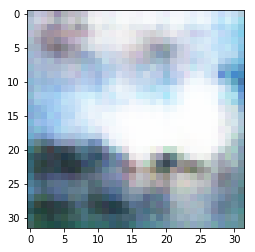

Epoch: [ 1 / 5 ],  Step: [ 710 / 781 ], D_loss:  0.8956927 , G_loss:  1.2174035
Epoch: [ 1 / 5 ],  Step: [ 711 / 781 ], D_loss:  0.9239666 , G_loss:  1.2536218
Epoch: [ 1 / 5 ],  Step: [ 712 / 781 ], D_loss:  0.9161668 , G_loss:  1.1750991
Epoch: [ 1 / 5 ],  Step: [ 713 / 781 ], D_loss:  1.0123209 , G_loss:  1.23007
Epoch: [ 1 / 5 ],  Step: [ 714 / 781 ], D_loss:  0.9644561 , G_loss:  0.94522923
Epoch: [ 1 / 5 ],  Step: [ 715 / 781 ], D_loss:  1.1835223 , G_loss:  1.312434
Epoch: [ 1 / 5 ],  Step: [ 716 / 781 ], D_loss:  0.9485603 , G_loss:  1.2501982
Epoch: [ 1 / 5 ],  Step: [ 717 / 781 ], D_loss:  0.885381 , G_loss:  1.2062639
Epoch: [ 1 / 5 ],  Step: [ 718 / 781 ], D_loss:  0.8521091 , G_loss:  1.2324145
Epoch: [ 1 / 5 ],  Step: [ 719 / 781 ], D_loss:  0.627859 , G_loss:  1.2599869
(196, 32, 32, 3)


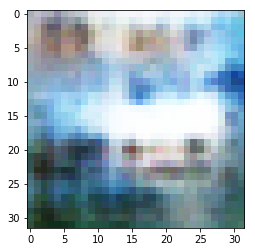

Epoch: [ 1 / 5 ],  Step: [ 720 / 781 ], D_loss:  0.6022588 , G_loss:  1.2378526
Epoch: [ 1 / 5 ],  Step: [ 721 / 781 ], D_loss:  0.6253988 , G_loss:  1.2785378
Epoch: [ 1 / 5 ],  Step: [ 722 / 781 ], D_loss:  0.6527593 , G_loss:  1.1642816
Epoch: [ 1 / 5 ],  Step: [ 723 / 781 ], D_loss:  0.7029858 , G_loss:  1.1799797
Epoch: [ 1 / 5 ],  Step: [ 724 / 781 ], D_loss:  0.70256853 , G_loss:  1.0942998
Epoch: [ 1 / 5 ],  Step: [ 725 / 781 ], D_loss:  0.80114925 , G_loss:  1.2806938
Epoch: [ 1 / 5 ],  Step: [ 726 / 781 ], D_loss:  0.91687775 , G_loss:  1.2032942
Epoch: [ 1 / 5 ],  Step: [ 727 / 781 ], D_loss:  0.8011186 , G_loss:  1.0893824
Epoch: [ 1 / 5 ],  Step: [ 728 / 781 ], D_loss:  0.88279897 , G_loss:  1.382642
Epoch: [ 1 / 5 ],  Step: [ 729 / 781 ], D_loss:  0.9077855 , G_loss:  1.2365835
(196, 32, 32, 3)


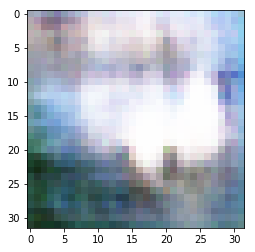

Epoch: [ 1 / 5 ],  Step: [ 730 / 781 ], D_loss:  0.8886975 , G_loss:  0.9935983
Epoch: [ 1 / 5 ],  Step: [ 731 / 781 ], D_loss:  0.8309058 , G_loss:  1.2255949
Epoch: [ 1 / 5 ],  Step: [ 732 / 781 ], D_loss:  0.8271001 , G_loss:  1.0816978
Epoch: [ 1 / 5 ],  Step: [ 733 / 781 ], D_loss:  0.8034958 , G_loss:  1.2959875
Epoch: [ 1 / 5 ],  Step: [ 734 / 781 ], D_loss:  0.83382857 , G_loss:  1.1770747
Epoch: [ 1 / 5 ],  Step: [ 735 / 781 ], D_loss:  0.71500504 , G_loss:  1.2113355
Epoch: [ 1 / 5 ],  Step: [ 736 / 781 ], D_loss:  0.7560607 , G_loss:  1.0663564
Epoch: [ 1 / 5 ],  Step: [ 737 / 781 ], D_loss:  0.75847363 , G_loss:  1.1377655
Epoch: [ 1 / 5 ],  Step: [ 738 / 781 ], D_loss:  0.8073848 , G_loss:  1.2640109
Epoch: [ 1 / 5 ],  Step: [ 739 / 781 ], D_loss:  0.8914932 , G_loss:  1.0857885
(196, 32, 32, 3)


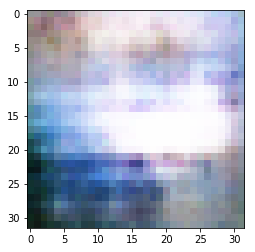

Epoch: [ 1 / 5 ],  Step: [ 740 / 781 ], D_loss:  0.84431076 , G_loss:  1.1862197
Epoch: [ 1 / 5 ],  Step: [ 741 / 781 ], D_loss:  0.85218126 , G_loss:  1.1943269
Epoch: [ 1 / 5 ],  Step: [ 742 / 781 ], D_loss:  0.74700785 , G_loss:  1.0698419
Epoch: [ 1 / 5 ],  Step: [ 743 / 781 ], D_loss:  0.7904012 , G_loss:  1.3292025
Epoch: [ 1 / 5 ],  Step: [ 744 / 781 ], D_loss:  0.7528088 , G_loss:  1.0845762
Epoch: [ 1 / 5 ],  Step: [ 745 / 781 ], D_loss:  0.8585726 , G_loss:  1.2109466
Epoch: [ 1 / 5 ],  Step: [ 746 / 781 ], D_loss:  0.86896133 , G_loss:  1.1547368
Epoch: [ 1 / 5 ],  Step: [ 747 / 781 ], D_loss:  0.78826684 , G_loss:  1.1715138
Epoch: [ 1 / 5 ],  Step: [ 748 / 781 ], D_loss:  1.0123613 , G_loss:  1.0546514
Epoch: [ 1 / 5 ],  Step: [ 749 / 781 ], D_loss:  1.0344346 , G_loss:  1.2224808
(196, 32, 32, 3)


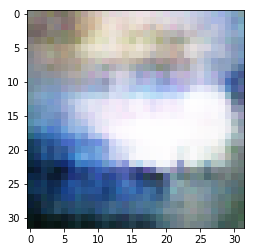

Epoch: [ 1 / 5 ],  Step: [ 750 / 781 ], D_loss:  0.92443174 , G_loss:  1.1387192
Epoch: [ 1 / 5 ],  Step: [ 751 / 781 ], D_loss:  0.7723714 , G_loss:  0.9414034
Epoch: [ 1 / 5 ],  Step: [ 752 / 781 ], D_loss:  0.91151 , G_loss:  1.2410274
Epoch: [ 1 / 5 ],  Step: [ 753 / 781 ], D_loss:  0.82615024 , G_loss:  1.1867857
Epoch: [ 1 / 5 ],  Step: [ 754 / 781 ], D_loss:  0.7921043 , G_loss:  1.1456077
Epoch: [ 1 / 5 ],  Step: [ 755 / 781 ], D_loss:  0.8819552 , G_loss:  1.0673871
Epoch: [ 1 / 5 ],  Step: [ 756 / 781 ], D_loss:  0.87295115 , G_loss:  1.1929358
Epoch: [ 1 / 5 ],  Step: [ 757 / 781 ], D_loss:  0.75205046 , G_loss:  0.9641036
Epoch: [ 1 / 5 ],  Step: [ 758 / 781 ], D_loss:  0.8294334 , G_loss:  1.3442974
Epoch: [ 1 / 5 ],  Step: [ 759 / 781 ], D_loss:  0.89188904 , G_loss:  1.090082
(196, 32, 32, 3)


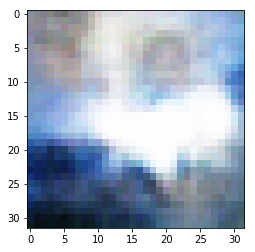

Epoch: [ 1 / 5 ],  Step: [ 760 / 781 ], D_loss:  0.79221004 , G_loss:  1.172848
Epoch: [ 1 / 5 ],  Step: [ 761 / 781 ], D_loss:  0.8777225 , G_loss:  1.0749209
Epoch: [ 1 / 5 ],  Step: [ 762 / 781 ], D_loss:  0.9129652 , G_loss:  1.20532
Epoch: [ 1 / 5 ],  Step: [ 763 / 781 ], D_loss:  0.8105413 , G_loss:  1.0124043
Epoch: [ 1 / 5 ],  Step: [ 764 / 781 ], D_loss:  0.8898056 , G_loss:  1.3270879
Epoch: [ 1 / 5 ],  Step: [ 765 / 781 ], D_loss:  0.7608392 , G_loss:  1.1767306
Epoch: [ 1 / 5 ],  Step: [ 766 / 781 ], D_loss:  0.7743503 , G_loss:  1.3262858
Epoch: [ 1 / 5 ],  Step: [ 767 / 781 ], D_loss:  0.66267645 , G_loss:  1.1890287
Epoch: [ 1 / 5 ],  Step: [ 768 / 781 ], D_loss:  0.74443436 , G_loss:  1.2903675
Epoch: [ 1 / 5 ],  Step: [ 769 / 781 ], D_loss:  0.70359695 , G_loss:  0.8936305
(196, 32, 32, 3)


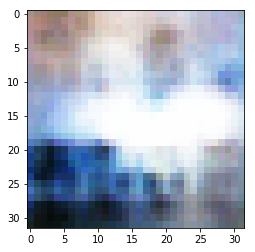

Epoch: [ 1 / 5 ],  Step: [ 770 / 781 ], D_loss:  1.0850751 , G_loss:  0.84900546
Epoch: [ 1 / 5 ],  Step: [ 771 / 781 ], D_loss:  1.1121795 , G_loss:  1.9403435
Epoch: [ 1 / 5 ],  Step: [ 772 / 781 ], D_loss:  1.4989729 , G_loss:  1.8832723
Epoch: [ 1 / 5 ],  Step: [ 773 / 781 ], D_loss:  1.3653499 , G_loss:  1.3623968
Epoch: [ 1 / 5 ],  Step: [ 774 / 781 ], D_loss:  1.3386679 , G_loss:  1.0849049
Epoch: [ 1 / 5 ],  Step: [ 775 / 781 ], D_loss:  1.1575993 , G_loss:  0.9922155
Epoch: [ 1 / 5 ],  Step: [ 776 / 781 ], D_loss:  1.400955 , G_loss:  1.4413811
Epoch: [ 1 / 5 ],  Step: [ 777 / 781 ], D_loss:  1.1056688 , G_loss:  1.3920715
Epoch: [ 1 / 5 ],  Step: [ 778 / 781 ], D_loss:  1.2792552 , G_loss:  1.0442305
Epoch: [ 1 / 5 ],  Step: [ 779 / 781 ], D_loss:  1.336992 , G_loss:  1.3192201
(196, 32, 32, 3)


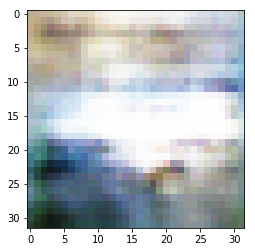

Epoch: [ 1 / 5 ],  Step: [ 780 / 781 ], D_loss:  1.0073223 , G_loss:  1.1008432
Epoch: [ 2 / 5 ],  Step: [ 0 / 781 ], D_loss:  1.0381285 , G_loss:  1.1627
(196, 32, 32, 3)


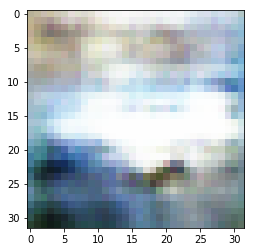

Epoch: [ 2 / 5 ],  Step: [ 1 / 781 ], D_loss:  0.89617556 , G_loss:  0.9933687
Epoch: [ 2 / 5 ],  Step: [ 2 / 781 ], D_loss:  1.0178183 , G_loss:  1.1317976
Epoch: [ 2 / 5 ],  Step: [ 3 / 781 ], D_loss:  1.1133962 , G_loss:  1.2613157
Epoch: [ 2 / 5 ],  Step: [ 4 / 781 ], D_loss:  1.0210513 , G_loss:  1.1172693
Epoch: [ 2 / 5 ],  Step: [ 5 / 781 ], D_loss:  1.1587579 , G_loss:  1.473439
Epoch: [ 2 / 5 ],  Step: [ 6 / 781 ], D_loss:  1.053293 , G_loss:  1.3874301
Epoch: [ 2 / 5 ],  Step: [ 7 / 781 ], D_loss:  0.9371559 , G_loss:  1.0798082
Epoch: [ 2 / 5 ],  Step: [ 8 / 781 ], D_loss:  0.7596878 , G_loss:  1.1090653
Epoch: [ 2 / 5 ],  Step: [ 9 / 781 ], D_loss:  0.6554091 , G_loss:  1.0960673
(196, 32, 32, 3)


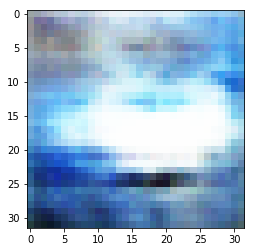

Epoch: [ 2 / 5 ],  Step: [ 10 / 781 ], D_loss:  0.74052966 , G_loss:  1.2550547
Epoch: [ 2 / 5 ],  Step: [ 11 / 781 ], D_loss:  0.72201425 , G_loss:  1.1693357
Epoch: [ 2 / 5 ],  Step: [ 12 / 781 ], D_loss:  0.7344968 , G_loss:  1.1888258
Epoch: [ 2 / 5 ],  Step: [ 13 / 781 ], D_loss:  0.81903577 , G_loss:  1.0721403
Epoch: [ 2 / 5 ],  Step: [ 14 / 781 ], D_loss:  0.80381984 , G_loss:  1.1553836
Epoch: [ 2 / 5 ],  Step: [ 15 / 781 ], D_loss:  0.85561454 , G_loss:  1.2021048
Epoch: [ 2 / 5 ],  Step: [ 16 / 781 ], D_loss:  0.7754474 , G_loss:  1.1695052
Epoch: [ 2 / 5 ],  Step: [ 17 / 781 ], D_loss:  0.8105934 , G_loss:  1.0603913
Epoch: [ 2 / 5 ],  Step: [ 18 / 781 ], D_loss:  0.7941231 , G_loss:  1.478265
Epoch: [ 2 / 5 ],  Step: [ 19 / 781 ], D_loss:  0.8387417 , G_loss:  1.2131584
(196, 32, 32, 3)


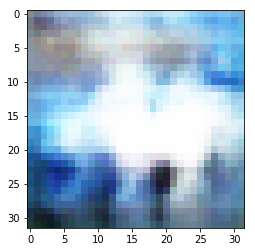

Epoch: [ 2 / 5 ],  Step: [ 20 / 781 ], D_loss:  0.66637635 , G_loss:  1.213366
Epoch: [ 2 / 5 ],  Step: [ 21 / 781 ], D_loss:  0.5934942 , G_loss:  1.3448168
Epoch: [ 2 / 5 ],  Step: [ 22 / 781 ], D_loss:  0.7321311 , G_loss:  1.23524
Epoch: [ 2 / 5 ],  Step: [ 23 / 781 ], D_loss:  0.70675063 , G_loss:  1.1113905
Epoch: [ 2 / 5 ],  Step: [ 24 / 781 ], D_loss:  0.7545991 , G_loss:  1.097864
Epoch: [ 2 / 5 ],  Step: [ 25 / 781 ], D_loss:  0.83222747 , G_loss:  1.0688906
Epoch: [ 2 / 5 ],  Step: [ 26 / 781 ], D_loss:  0.61739165 , G_loss:  1.109669
Epoch: [ 2 / 5 ],  Step: [ 27 / 781 ], D_loss:  0.7491243 , G_loss:  1.2555139
Epoch: [ 2 / 5 ],  Step: [ 28 / 781 ], D_loss:  0.8002308 , G_loss:  1.13604
Epoch: [ 2 / 5 ],  Step: [ 29 / 781 ], D_loss:  0.72905207 , G_loss:  0.97924423
(196, 32, 32, 3)


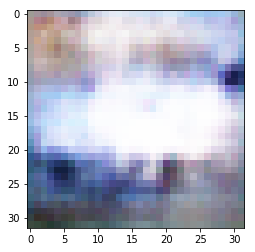

Epoch: [ 2 / 5 ],  Step: [ 30 / 781 ], D_loss:  0.7111076 , G_loss:  1.1428554
Epoch: [ 2 / 5 ],  Step: [ 31 / 781 ], D_loss:  0.85567176 , G_loss:  1.3636254
Epoch: [ 2 / 5 ],  Step: [ 32 / 781 ], D_loss:  0.80577505 , G_loss:  1.128744
Epoch: [ 2 / 5 ],  Step: [ 33 / 781 ], D_loss:  0.7277245 , G_loss:  0.9080464
Epoch: [ 2 / 5 ],  Step: [ 34 / 781 ], D_loss:  0.92239773 , G_loss:  1.2575966
Epoch: [ 2 / 5 ],  Step: [ 35 / 781 ], D_loss:  0.8027681 , G_loss:  0.78829783
Epoch: [ 2 / 5 ],  Step: [ 36 / 781 ], D_loss:  1.1508733 , G_loss:  1.720621
Epoch: [ 2 / 5 ],  Step: [ 37 / 781 ], D_loss:  1.1697261 , G_loss:  0.8794817
Epoch: [ 2 / 5 ],  Step: [ 38 / 781 ], D_loss:  1.4441109 , G_loss:  2.1916993
Epoch: [ 2 / 5 ],  Step: [ 39 / 781 ], D_loss:  1.5457163 , G_loss:  1.939174
(196, 32, 32, 3)


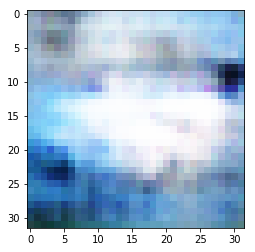

Epoch: [ 2 / 5 ],  Step: [ 40 / 781 ], D_loss:  1.670391 , G_loss:  1.380542
Epoch: [ 2 / 5 ],  Step: [ 41 / 781 ], D_loss:  1.4177527 , G_loss:  1.1252729
Epoch: [ 2 / 5 ],  Step: [ 42 / 781 ], D_loss:  1.2376527 , G_loss:  1.089472
Epoch: [ 2 / 5 ],  Step: [ 43 / 781 ], D_loss:  1.2621129 , G_loss:  1.4391499
Epoch: [ 2 / 5 ],  Step: [ 44 / 781 ], D_loss:  1.2282631 , G_loss:  1.3714534
Epoch: [ 2 / 5 ],  Step: [ 45 / 781 ], D_loss:  1.2930295 , G_loss:  1.0454822
Epoch: [ 2 / 5 ],  Step: [ 46 / 781 ], D_loss:  1.3614252 , G_loss:  1.4756435
Epoch: [ 2 / 5 ],  Step: [ 47 / 781 ], D_loss:  1.1447368 , G_loss:  1.2859421
Epoch: [ 2 / 5 ],  Step: [ 48 / 781 ], D_loss:  1.0895723 , G_loss:  0.96707475
Epoch: [ 2 / 5 ],  Step: [ 49 / 781 ], D_loss:  1.3102179 , G_loss:  1.4235004
(196, 32, 32, 3)


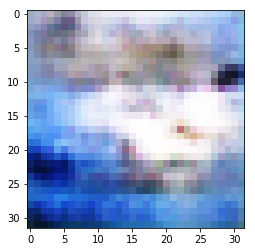

Epoch: [ 2 / 5 ],  Step: [ 50 / 781 ], D_loss:  1.0318475 , G_loss:  1.2774035
Epoch: [ 2 / 5 ],  Step: [ 51 / 781 ], D_loss:  0.9264648 , G_loss:  0.9531864
Epoch: [ 2 / 5 ],  Step: [ 52 / 781 ], D_loss:  1.038203 , G_loss:  1.4749992
Epoch: [ 2 / 5 ],  Step: [ 53 / 781 ], D_loss:  0.9750105 , G_loss:  1.3702209
Epoch: [ 2 / 5 ],  Step: [ 54 / 781 ], D_loss:  0.911407 , G_loss:  1.1160278
Epoch: [ 2 / 5 ],  Step: [ 55 / 781 ], D_loss:  1.0691137 , G_loss:  1.2288796
Epoch: [ 2 / 5 ],  Step: [ 56 / 781 ], D_loss:  1.1735346 , G_loss:  1.2988962
Epoch: [ 2 / 5 ],  Step: [ 57 / 781 ], D_loss:  1.0079801 , G_loss:  1.1319206
Epoch: [ 2 / 5 ],  Step: [ 58 / 781 ], D_loss:  0.9208835 , G_loss:  1.1144055
Epoch: [ 2 / 5 ],  Step: [ 59 / 781 ], D_loss:  0.82644355 , G_loss:  1.3936176
(196, 32, 32, 3)


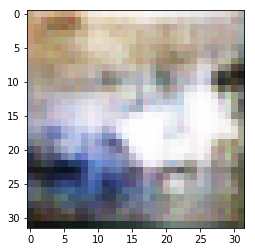

Epoch: [ 2 / 5 ],  Step: [ 60 / 781 ], D_loss:  0.8218364 , G_loss:  1.2285593
Epoch: [ 2 / 5 ],  Step: [ 61 / 781 ], D_loss:  0.71480596 , G_loss:  1.37618
Epoch: [ 2 / 5 ],  Step: [ 62 / 781 ], D_loss:  0.7704169 , G_loss:  1.2119042
Epoch: [ 2 / 5 ],  Step: [ 63 / 781 ], D_loss:  0.81678516 , G_loss:  1.1107001
Epoch: [ 2 / 5 ],  Step: [ 64 / 781 ], D_loss:  0.7636276 , G_loss:  1.0310564
Epoch: [ 2 / 5 ],  Step: [ 65 / 781 ], D_loss:  0.6737657 , G_loss:  1.3285978
Epoch: [ 2 / 5 ],  Step: [ 66 / 781 ], D_loss:  0.74116343 , G_loss:  1.0717351
Epoch: [ 2 / 5 ],  Step: [ 67 / 781 ], D_loss:  0.8419662 , G_loss:  1.2486305
Epoch: [ 2 / 5 ],  Step: [ 68 / 781 ], D_loss:  0.8259498 , G_loss:  1.2066996
Epoch: [ 2 / 5 ],  Step: [ 69 / 781 ], D_loss:  0.76842725 , G_loss:  1.1337487
(196, 32, 32, 3)


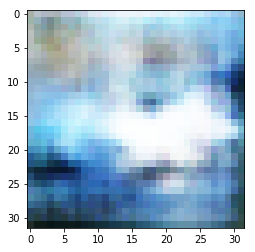

Epoch: [ 2 / 5 ],  Step: [ 70 / 781 ], D_loss:  0.8265878 , G_loss:  1.1279159
Epoch: [ 2 / 5 ],  Step: [ 71 / 781 ], D_loss:  0.797676 , G_loss:  1.0510379
Epoch: [ 2 / 5 ],  Step: [ 72 / 781 ], D_loss:  0.7452773 , G_loss:  1.112031
Epoch: [ 2 / 5 ],  Step: [ 73 / 781 ], D_loss:  0.70664984 , G_loss:  1.1551691
Epoch: [ 2 / 5 ],  Step: [ 74 / 781 ], D_loss:  0.7053661 , G_loss:  1.0739566
Epoch: [ 2 / 5 ],  Step: [ 75 / 781 ], D_loss:  0.6466572 , G_loss:  0.98864794
Epoch: [ 2 / 5 ],  Step: [ 76 / 781 ], D_loss:  0.95098567 , G_loss:  1.2101388
Epoch: [ 2 / 5 ],  Step: [ 77 / 781 ], D_loss:  0.6640327 , G_loss:  1.0800867
Epoch: [ 2 / 5 ],  Step: [ 78 / 781 ], D_loss:  0.84973645 , G_loss:  1.0860035
Epoch: [ 2 / 5 ],  Step: [ 79 / 781 ], D_loss:  0.6932311 , G_loss:  1.1306124
(196, 32, 32, 3)


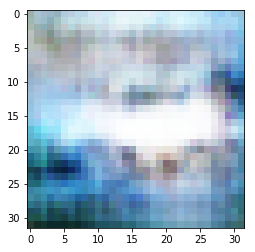

Epoch: [ 2 / 5 ],  Step: [ 80 / 781 ], D_loss:  0.8742886 , G_loss:  1.0173967
Epoch: [ 2 / 5 ],  Step: [ 81 / 781 ], D_loss:  0.80199206 , G_loss:  0.9560708
Epoch: [ 2 / 5 ],  Step: [ 82 / 781 ], D_loss:  0.80052394 , G_loss:  1.1281121
Epoch: [ 2 / 5 ],  Step: [ 83 / 781 ], D_loss:  0.8346765 , G_loss:  1.1289989
Epoch: [ 2 / 5 ],  Step: [ 84 / 781 ], D_loss:  0.7815719 , G_loss:  1.0559049
Epoch: [ 2 / 5 ],  Step: [ 85 / 781 ], D_loss:  0.7693202 , G_loss:  0.9035001
Epoch: [ 2 / 5 ],  Step: [ 86 / 781 ], D_loss:  0.91219103 , G_loss:  1.497927
Epoch: [ 2 / 5 ],  Step: [ 87 / 781 ], D_loss:  0.86250716 , G_loss:  1.3448434
Epoch: [ 2 / 5 ],  Step: [ 88 / 781 ], D_loss:  1.1043739 , G_loss:  0.9979303
Epoch: [ 2 / 5 ],  Step: [ 89 / 781 ], D_loss:  1.0700222 , G_loss:  1.4019165
(196, 32, 32, 3)


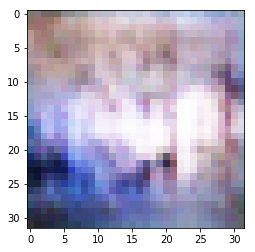

Epoch: [ 2 / 5 ],  Step: [ 90 / 781 ], D_loss:  0.93800366 , G_loss:  1.3577976
Epoch: [ 2 / 5 ],  Step: [ 91 / 781 ], D_loss:  0.7610685 , G_loss:  1.0072572
Epoch: [ 2 / 5 ],  Step: [ 92 / 781 ], D_loss:  0.84613496 , G_loss:  1.4179585
Epoch: [ 2 / 5 ],  Step: [ 93 / 781 ], D_loss:  0.65005016 , G_loss:  1.3871881
Epoch: [ 2 / 5 ],  Step: [ 94 / 781 ], D_loss:  0.71423924 , G_loss:  1.0988687
Epoch: [ 2 / 5 ],  Step: [ 95 / 781 ], D_loss:  0.6591294 , G_loss:  1.1832155
Epoch: [ 2 / 5 ],  Step: [ 96 / 781 ], D_loss:  0.69207996 , G_loss:  1.3113921
Epoch: [ 2 / 5 ],  Step: [ 97 / 781 ], D_loss:  0.7273903 , G_loss:  1.1846187
Epoch: [ 2 / 5 ],  Step: [ 98 / 781 ], D_loss:  0.7657243 , G_loss:  1.322164
Epoch: [ 2 / 5 ],  Step: [ 99 / 781 ], D_loss:  0.7298017 , G_loss:  0.9735273
(196, 32, 32, 3)


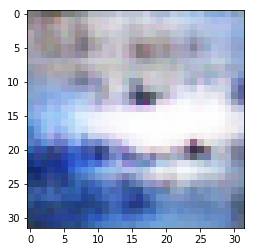

Epoch: [ 2 / 5 ],  Step: [ 100 / 781 ], D_loss:  0.85902053 , G_loss:  1.4807501
Epoch: [ 2 / 5 ],  Step: [ 101 / 781 ], D_loss:  0.94942594 , G_loss:  0.9988937
Epoch: [ 2 / 5 ],  Step: [ 102 / 781 ], D_loss:  1.4810865 , G_loss:  2.063196
Epoch: [ 2 / 5 ],  Step: [ 103 / 781 ], D_loss:  1.2464316 , G_loss:  1.9653249
Epoch: [ 2 / 5 ],  Step: [ 104 / 781 ], D_loss:  1.3048809 , G_loss:  1.486683
Epoch: [ 2 / 5 ],  Step: [ 105 / 781 ], D_loss:  1.0696322 , G_loss:  1.052174
Epoch: [ 2 / 5 ],  Step: [ 106 / 781 ], D_loss:  1.2107155 , G_loss:  1.4154867
Epoch: [ 2 / 5 ],  Step: [ 107 / 781 ], D_loss:  0.93559986 , G_loss:  1.3020245
Epoch: [ 2 / 5 ],  Step: [ 108 / 781 ], D_loss:  0.74113846 , G_loss:  1.1210114
Epoch: [ 2 / 5 ],  Step: [ 109 / 781 ], D_loss:  0.901983 , G_loss:  1.4374592
(196, 32, 32, 3)


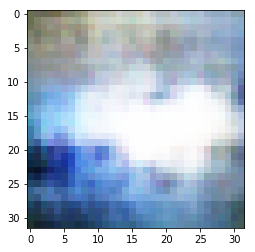

Epoch: [ 2 / 5 ],  Step: [ 110 / 781 ], D_loss:  0.7255168 , G_loss:  1.1960275
Epoch: [ 2 / 5 ],  Step: [ 111 / 781 ], D_loss:  0.92573416 , G_loss:  1.2102218
Epoch: [ 2 / 5 ],  Step: [ 112 / 781 ], D_loss:  0.89406484 , G_loss:  1.1188253
Epoch: [ 2 / 5 ],  Step: [ 113 / 781 ], D_loss:  0.8203101 , G_loss:  1.0122634
Epoch: [ 2 / 5 ],  Step: [ 114 / 781 ], D_loss:  0.8089852 , G_loss:  1.2739582
Epoch: [ 2 / 5 ],  Step: [ 115 / 781 ], D_loss:  0.83618665 , G_loss:  1.2838516
Epoch: [ 2 / 5 ],  Step: [ 116 / 781 ], D_loss:  0.6507468 , G_loss:  1.2893068
Epoch: [ 2 / 5 ],  Step: [ 117 / 781 ], D_loss:  0.5817004 , G_loss:  1.1602187
Epoch: [ 2 / 5 ],  Step: [ 118 / 781 ], D_loss:  0.60337466 , G_loss:  1.1172588
Epoch: [ 2 / 5 ],  Step: [ 119 / 781 ], D_loss:  0.72547776 , G_loss:  1.4169942
(196, 32, 32, 3)


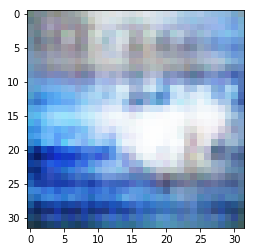

Epoch: [ 2 / 5 ],  Step: [ 120 / 781 ], D_loss:  0.69202536 , G_loss:  1.3991048
Epoch: [ 2 / 5 ],  Step: [ 121 / 781 ], D_loss:  0.74639964 , G_loss:  1.1480523
Epoch: [ 2 / 5 ],  Step: [ 122 / 781 ], D_loss:  0.7724852 , G_loss:  1.2660317
Epoch: [ 2 / 5 ],  Step: [ 123 / 781 ], D_loss:  0.8068588 , G_loss:  1.189342
Epoch: [ 2 / 5 ],  Step: [ 124 / 781 ], D_loss:  0.8988404 , G_loss:  1.3915362
Epoch: [ 2 / 5 ],  Step: [ 125 / 781 ], D_loss:  1.0017818 , G_loss:  1.5525376
Epoch: [ 2 / 5 ],  Step: [ 126 / 781 ], D_loss:  0.96144164 , G_loss:  1.317082
Epoch: [ 2 / 5 ],  Step: [ 127 / 781 ], D_loss:  0.7389319 , G_loss:  1.2659211
Epoch: [ 2 / 5 ],  Step: [ 128 / 781 ], D_loss:  0.5307963 , G_loss:  1.4805382
Epoch: [ 2 / 5 ],  Step: [ 129 / 781 ], D_loss:  0.5429729 , G_loss:  1.2965602
(196, 32, 32, 3)


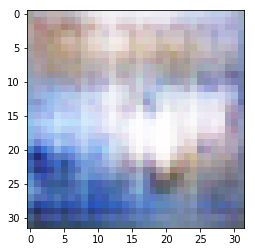

Epoch: [ 2 / 5 ],  Step: [ 130 / 781 ], D_loss:  0.69264805 , G_loss:  1.4356055
Epoch: [ 2 / 5 ],  Step: [ 131 / 781 ], D_loss:  0.7462777 , G_loss:  1.2987247
Epoch: [ 2 / 5 ],  Step: [ 132 / 781 ], D_loss:  0.7878854 , G_loss:  1.1117488
Epoch: [ 2 / 5 ],  Step: [ 133 / 781 ], D_loss:  0.70768595 , G_loss:  1.2816318
Epoch: [ 2 / 5 ],  Step: [ 134 / 781 ], D_loss:  1.0167187 , G_loss:  1.1607822
Epoch: [ 2 / 5 ],  Step: [ 135 / 781 ], D_loss:  0.78375345 , G_loss:  1.1076978
Epoch: [ 2 / 5 ],  Step: [ 136 / 781 ], D_loss:  0.7858808 , G_loss:  1.3121136
Epoch: [ 2 / 5 ],  Step: [ 137 / 781 ], D_loss:  0.71857774 , G_loss:  1.1302563
Epoch: [ 2 / 5 ],  Step: [ 138 / 781 ], D_loss:  0.72939324 , G_loss:  1.3686683
Epoch: [ 2 / 5 ],  Step: [ 139 / 781 ], D_loss:  0.7246263 , G_loss:  1.2407
(196, 32, 32, 3)


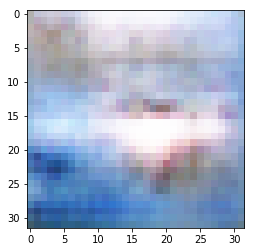

Epoch: [ 2 / 5 ],  Step: [ 140 / 781 ], D_loss:  0.69395816 , G_loss:  1.2460027
Epoch: [ 2 / 5 ],  Step: [ 141 / 781 ], D_loss:  0.70279664 , G_loss:  1.2282823
Epoch: [ 2 / 5 ],  Step: [ 142 / 781 ], D_loss:  0.7218934 , G_loss:  1.2573224
Epoch: [ 2 / 5 ],  Step: [ 143 / 781 ], D_loss:  0.7102644 , G_loss:  1.0938987
Epoch: [ 2 / 5 ],  Step: [ 144 / 781 ], D_loss:  0.7146814 , G_loss:  1.2053514
Epoch: [ 2 / 5 ],  Step: [ 145 / 781 ], D_loss:  0.5396749 , G_loss:  1.1233026
Epoch: [ 2 / 5 ],  Step: [ 146 / 781 ], D_loss:  0.5024461 , G_loss:  1.3121241
Epoch: [ 2 / 5 ],  Step: [ 147 / 781 ], D_loss:  0.6107042 , G_loss:  1.0917869
Epoch: [ 2 / 5 ],  Step: [ 148 / 781 ], D_loss:  0.6972621 , G_loss:  1.2617075
Epoch: [ 2 / 5 ],  Step: [ 149 / 781 ], D_loss:  0.8250151 , G_loss:  1.1818634
(196, 32, 32, 3)


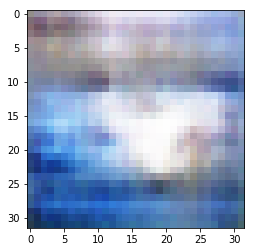

Epoch: [ 2 / 5 ],  Step: [ 150 / 781 ], D_loss:  0.77552176 , G_loss:  1.0002964
Epoch: [ 2 / 5 ],  Step: [ 151 / 781 ], D_loss:  1.0135663 , G_loss:  1.0803427
Epoch: [ 2 / 5 ],  Step: [ 152 / 781 ], D_loss:  0.866391 , G_loss:  0.948768
Epoch: [ 2 / 5 ],  Step: [ 153 / 781 ], D_loss:  0.7394663 , G_loss:  1.0714736
Epoch: [ 2 / 5 ],  Step: [ 154 / 781 ], D_loss:  0.7494957 , G_loss:  1.1847494
Epoch: [ 2 / 5 ],  Step: [ 155 / 781 ], D_loss:  0.6953767 , G_loss:  1.3380115
Epoch: [ 2 / 5 ],  Step: [ 156 / 781 ], D_loss:  0.7980262 , G_loss:  1.069363
Epoch: [ 2 / 5 ],  Step: [ 157 / 781 ], D_loss:  0.8796488 , G_loss:  1.2962779
Epoch: [ 2 / 5 ],  Step: [ 158 / 781 ], D_loss:  0.91192776 , G_loss:  1.2412317
Epoch: [ 2 / 5 ],  Step: [ 159 / 781 ], D_loss:  0.8792733 , G_loss:  1.1650846
(196, 32, 32, 3)


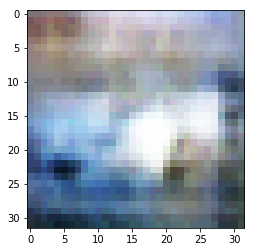

Epoch: [ 2 / 5 ],  Step: [ 160 / 781 ], D_loss:  0.6698957 , G_loss:  1.0498861
Epoch: [ 2 / 5 ],  Step: [ 161 / 781 ], D_loss:  0.70694846 , G_loss:  1.2588974
Epoch: [ 2 / 5 ],  Step: [ 162 / 781 ], D_loss:  0.68631697 , G_loss:  1.0737906
Epoch: [ 2 / 5 ],  Step: [ 163 / 781 ], D_loss:  0.5873342 , G_loss:  1.3070011
Epoch: [ 2 / 5 ],  Step: [ 164 / 781 ], D_loss:  0.6120523 , G_loss:  1.1464945
Epoch: [ 2 / 5 ],  Step: [ 165 / 781 ], D_loss:  0.56908584 , G_loss:  1.141394
Epoch: [ 2 / 5 ],  Step: [ 166 / 781 ], D_loss:  0.6838243 , G_loss:  1.1173477
Epoch: [ 2 / 5 ],  Step: [ 167 / 781 ], D_loss:  0.64088506 , G_loss:  1.1525128
Epoch: [ 2 / 5 ],  Step: [ 168 / 781 ], D_loss:  0.53290707 , G_loss:  1.1475006
Epoch: [ 2 / 5 ],  Step: [ 169 / 781 ], D_loss:  0.5478581 , G_loss:  1.2901134
(196, 32, 32, 3)


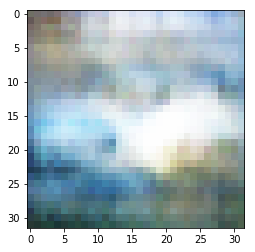

Epoch: [ 2 / 5 ],  Step: [ 170 / 781 ], D_loss:  0.5557127 , G_loss:  1.1064596
Epoch: [ 2 / 5 ],  Step: [ 171 / 781 ], D_loss:  0.6477796 , G_loss:  1.4194793
Epoch: [ 2 / 5 ],  Step: [ 172 / 781 ], D_loss:  0.7339685 , G_loss:  1.2592574
Epoch: [ 2 / 5 ],  Step: [ 173 / 781 ], D_loss:  0.6879765 , G_loss:  1.1292249
Epoch: [ 2 / 5 ],  Step: [ 174 / 781 ], D_loss:  0.6753299 , G_loss:  0.8439921
Epoch: [ 2 / 5 ],  Step: [ 175 / 781 ], D_loss:  0.92987627 , G_loss:  1.4866538
Epoch: [ 2 / 5 ],  Step: [ 176 / 781 ], D_loss:  0.9087923 , G_loss:  1.1162469
Epoch: [ 2 / 5 ],  Step: [ 177 / 781 ], D_loss:  0.83184737 , G_loss:  1.1570276
Epoch: [ 2 / 5 ],  Step: [ 178 / 781 ], D_loss:  0.82835937 , G_loss:  1.3868724
Epoch: [ 2 / 5 ],  Step: [ 179 / 781 ], D_loss:  0.7814722 , G_loss:  0.9852576
(196, 32, 32, 3)


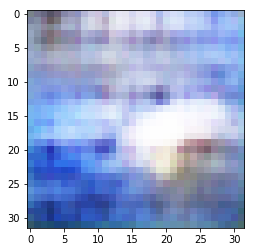

Epoch: [ 2 / 5 ],  Step: [ 180 / 781 ], D_loss:  0.805524 , G_loss:  1.2040125
Epoch: [ 2 / 5 ],  Step: [ 181 / 781 ], D_loss:  0.76100844 , G_loss:  1.1676422
Epoch: [ 2 / 5 ],  Step: [ 182 / 781 ], D_loss:  0.7493765 , G_loss:  1.2853017
Epoch: [ 2 / 5 ],  Step: [ 183 / 781 ], D_loss:  0.7429178 , G_loss:  1.112891
Epoch: [ 2 / 5 ],  Step: [ 184 / 781 ], D_loss:  0.7430615 , G_loss:  1.1787052
Epoch: [ 2 / 5 ],  Step: [ 185 / 781 ], D_loss:  0.6688998 , G_loss:  1.1710502
Epoch: [ 2 / 5 ],  Step: [ 186 / 781 ], D_loss:  0.6051354 , G_loss:  1.1628749
Epoch: [ 2 / 5 ],  Step: [ 187 / 781 ], D_loss:  0.573164 , G_loss:  1.1484417
Epoch: [ 2 / 5 ],  Step: [ 188 / 781 ], D_loss:  0.62717915 , G_loss:  1.3251157
Epoch: [ 2 / 5 ],  Step: [ 189 / 781 ], D_loss:  0.6264398 , G_loss:  1.1507888
(196, 32, 32, 3)


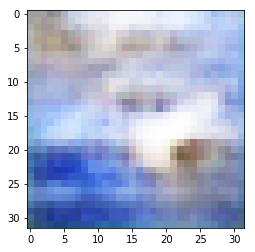

Epoch: [ 2 / 5 ],  Step: [ 190 / 781 ], D_loss:  0.6141711 , G_loss:  1.4489315
Epoch: [ 2 / 5 ],  Step: [ 191 / 781 ], D_loss:  0.6952101 , G_loss:  1.1269839
Epoch: [ 2 / 5 ],  Step: [ 192 / 781 ], D_loss:  0.87074006 , G_loss:  1.1275339
Epoch: [ 2 / 5 ],  Step: [ 193 / 781 ], D_loss:  0.7702169 , G_loss:  1.375401
Epoch: [ 2 / 5 ],  Step: [ 194 / 781 ], D_loss:  0.73683083 , G_loss:  1.1213531
Epoch: [ 2 / 5 ],  Step: [ 195 / 781 ], D_loss:  0.6272873 , G_loss:  1.3658956
Epoch: [ 2 / 5 ],  Step: [ 196 / 781 ], D_loss:  0.60122204 , G_loss:  1.5902442
Epoch: [ 2 / 5 ],  Step: [ 197 / 781 ], D_loss:  0.6543486 , G_loss:  1.2139809
Epoch: [ 2 / 5 ],  Step: [ 198 / 781 ], D_loss:  0.70382035 , G_loss:  0.9589789
Epoch: [ 2 / 5 ],  Step: [ 199 / 781 ], D_loss:  0.92327523 , G_loss:  1.7057714
(196, 32, 32, 3)


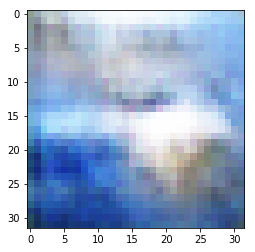

Epoch: [ 2 / 5 ],  Step: [ 200 / 781 ], D_loss:  1.0861037 , G_loss:  1.2902936
Epoch: [ 2 / 5 ],  Step: [ 201 / 781 ], D_loss:  1.0177999 , G_loss:  1.0646192
Epoch: [ 2 / 5 ],  Step: [ 202 / 781 ], D_loss:  1.0054623 , G_loss:  1.3487437
Epoch: [ 2 / 5 ],  Step: [ 203 / 781 ], D_loss:  0.96590126 , G_loss:  1.2777815
Epoch: [ 2 / 5 ],  Step: [ 204 / 781 ], D_loss:  0.93239844 , G_loss:  1.5721138
Epoch: [ 2 / 5 ],  Step: [ 205 / 781 ], D_loss:  0.9489339 , G_loss:  1.3321794
Epoch: [ 2 / 5 ],  Step: [ 206 / 781 ], D_loss:  0.84878314 , G_loss:  1.3949157
Epoch: [ 2 / 5 ],  Step: [ 207 / 781 ], D_loss:  0.82869124 , G_loss:  1.2771385
Epoch: [ 2 / 5 ],  Step: [ 208 / 781 ], D_loss:  0.6030739 , G_loss:  1.1766545
Epoch: [ 2 / 5 ],  Step: [ 209 / 781 ], D_loss:  0.6573494 , G_loss:  1.4090538
(196, 32, 32, 3)


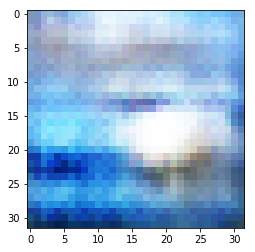

Epoch: [ 2 / 5 ],  Step: [ 210 / 781 ], D_loss:  0.5812697 , G_loss:  1.2751946
Epoch: [ 2 / 5 ],  Step: [ 211 / 781 ], D_loss:  0.5845646 , G_loss:  1.1835053
Epoch: [ 2 / 5 ],  Step: [ 212 / 781 ], D_loss:  0.61536455 , G_loss:  1.0936476
Epoch: [ 2 / 5 ],  Step: [ 213 / 781 ], D_loss:  0.6439887 , G_loss:  1.3157318
Epoch: [ 2 / 5 ],  Step: [ 214 / 781 ], D_loss:  0.8128441 , G_loss:  1.039248
Epoch: [ 2 / 5 ],  Step: [ 215 / 781 ], D_loss:  0.792053 , G_loss:  1.4163586
Epoch: [ 2 / 5 ],  Step: [ 216 / 781 ], D_loss:  0.8387943 , G_loss:  1.3129084
Epoch: [ 2 / 5 ],  Step: [ 217 / 781 ], D_loss:  0.7594722 , G_loss:  0.8743885
Epoch: [ 2 / 5 ],  Step: [ 218 / 781 ], D_loss:  1.3481016 , G_loss:  1.515423
Epoch: [ 2 / 5 ],  Step: [ 219 / 781 ], D_loss:  0.9658321 , G_loss:  0.9174497
(196, 32, 32, 3)


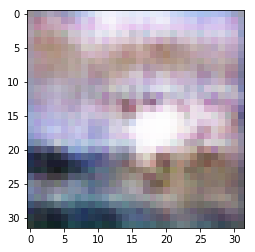

Epoch: [ 2 / 5 ],  Step: [ 220 / 781 ], D_loss:  1.2543485 , G_loss:  1.7178643
Epoch: [ 2 / 5 ],  Step: [ 221 / 781 ], D_loss:  1.3265609 , G_loss:  1.7204804
Epoch: [ 2 / 5 ],  Step: [ 222 / 781 ], D_loss:  1.4841495 , G_loss:  1.4979684
Epoch: [ 2 / 5 ],  Step: [ 223 / 781 ], D_loss:  1.2585362 , G_loss:  1.1637784
Epoch: [ 2 / 5 ],  Step: [ 224 / 781 ], D_loss:  1.0546886 , G_loss:  0.9506432
Epoch: [ 2 / 5 ],  Step: [ 225 / 781 ], D_loss:  1.2237042 , G_loss:  1.2826827
Epoch: [ 2 / 5 ],  Step: [ 226 / 781 ], D_loss:  1.1723382 , G_loss:  1.3032277
Epoch: [ 2 / 5 ],  Step: [ 227 / 781 ], D_loss:  1.0935072 , G_loss:  1.1452359
Epoch: [ 2 / 5 ],  Step: [ 228 / 781 ], D_loss:  0.98584205 , G_loss:  0.91298634
Epoch: [ 2 / 5 ],  Step: [ 229 / 781 ], D_loss:  1.2355037 , G_loss:  1.4721394
(196, 32, 32, 3)


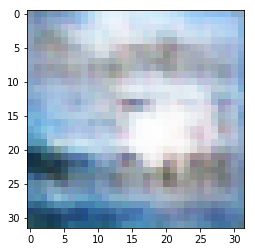

Epoch: [ 2 / 5 ],  Step: [ 230 / 781 ], D_loss:  1.0858505 , G_loss:  1.432574
Epoch: [ 2 / 5 ],  Step: [ 231 / 781 ], D_loss:  1.3098218 , G_loss:  1.4776219
Epoch: [ 2 / 5 ],  Step: [ 232 / 781 ], D_loss:  1.0377455 , G_loss:  1.2036138
Epoch: [ 2 / 5 ],  Step: [ 233 / 781 ], D_loss:  1.1935285 , G_loss:  1.3361062
Epoch: [ 2 / 5 ],  Step: [ 234 / 781 ], D_loss:  0.9432977 , G_loss:  1.1550013
Epoch: [ 2 / 5 ],  Step: [ 235 / 781 ], D_loss:  0.92384833 , G_loss:  0.98185956
Epoch: [ 2 / 5 ],  Step: [ 236 / 781 ], D_loss:  0.84382606 , G_loss:  1.2359748
Epoch: [ 2 / 5 ],  Step: [ 237 / 781 ], D_loss:  0.83148 , G_loss:  1.1686796
Epoch: [ 2 / 5 ],  Step: [ 238 / 781 ], D_loss:  0.7492364 , G_loss:  1.1282431
Epoch: [ 2 / 5 ],  Step: [ 239 / 781 ], D_loss:  0.90645754 , G_loss:  1.2041588
(196, 32, 32, 3)


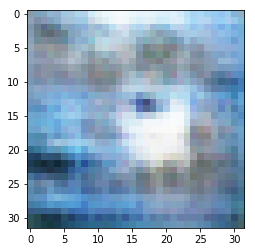

Epoch: [ 2 / 5 ],  Step: [ 240 / 781 ], D_loss:  0.91541636 , G_loss:  1.2332057
Epoch: [ 2 / 5 ],  Step: [ 241 / 781 ], D_loss:  0.963235 , G_loss:  1.0228093
Epoch: [ 2 / 5 ],  Step: [ 242 / 781 ], D_loss:  1.1095881 , G_loss:  1.6612731
Epoch: [ 2 / 5 ],  Step: [ 243 / 781 ], D_loss:  0.9941321 , G_loss:  1.4161372
Epoch: [ 2 / 5 ],  Step: [ 244 / 781 ], D_loss:  0.94345677 , G_loss:  0.9496005
Epoch: [ 2 / 5 ],  Step: [ 245 / 781 ], D_loss:  1.2635279 , G_loss:  2.223735
Epoch: [ 2 / 5 ],  Step: [ 246 / 781 ], D_loss:  1.1018246 , G_loss:  1.6128142
Epoch: [ 2 / 5 ],  Step: [ 247 / 781 ], D_loss:  1.0639632 , G_loss:  0.9302176
Epoch: [ 2 / 5 ],  Step: [ 248 / 781 ], D_loss:  1.6641512 , G_loss:  2.3416634
Epoch: [ 2 / 5 ],  Step: [ 249 / 781 ], D_loss:  1.6155918 , G_loss:  2.2274642
(196, 32, 32, 3)


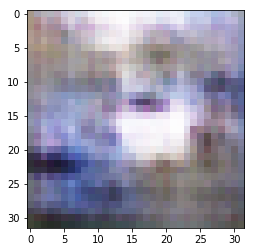

Epoch: [ 2 / 5 ],  Step: [ 250 / 781 ], D_loss:  1.5228773 , G_loss:  1.8438731
Epoch: [ 2 / 5 ],  Step: [ 251 / 781 ], D_loss:  1.2742518 , G_loss:  1.3026438
Epoch: [ 2 / 5 ],  Step: [ 252 / 781 ], D_loss:  1.4690855 , G_loss:  1.6521046
Epoch: [ 2 / 5 ],  Step: [ 253 / 781 ], D_loss:  1.2364732 , G_loss:  1.4817537
Epoch: [ 2 / 5 ],  Step: [ 254 / 781 ], D_loss:  1.4001188 , G_loss:  1.3037394
Epoch: [ 2 / 5 ],  Step: [ 255 / 781 ], D_loss:  1.2226492 , G_loss:  1.2472935
Epoch: [ 2 / 5 ],  Step: [ 256 / 781 ], D_loss:  1.151758 , G_loss:  1.2451206
Epoch: [ 2 / 5 ],  Step: [ 257 / 781 ], D_loss:  1.0427667 , G_loss:  1.061851
Epoch: [ 2 / 5 ],  Step: [ 258 / 781 ], D_loss:  0.76118517 , G_loss:  1.0915598
Epoch: [ 2 / 5 ],  Step: [ 259 / 781 ], D_loss:  0.94484425 , G_loss:  1.4493712
(196, 32, 32, 3)


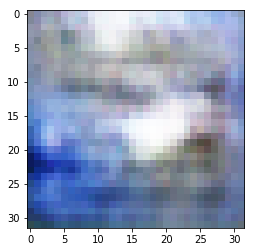

Epoch: [ 2 / 5 ],  Step: [ 260 / 781 ], D_loss:  0.8258104 , G_loss:  1.3333044
Epoch: [ 2 / 5 ],  Step: [ 261 / 781 ], D_loss:  0.7096083 , G_loss:  1.1389099
Epoch: [ 2 / 5 ],  Step: [ 262 / 781 ], D_loss:  0.77280384 , G_loss:  1.4517032
Epoch: [ 2 / 5 ],  Step: [ 263 / 781 ], D_loss:  0.7032404 , G_loss:  1.4351039
Epoch: [ 2 / 5 ],  Step: [ 264 / 781 ], D_loss:  0.7274976 , G_loss:  1.273609
Epoch: [ 2 / 5 ],  Step: [ 265 / 781 ], D_loss:  0.8516676 , G_loss:  1.1449467
Epoch: [ 2 / 5 ],  Step: [ 266 / 781 ], D_loss:  1.0701829 , G_loss:  1.39903
Epoch: [ 2 / 5 ],  Step: [ 267 / 781 ], D_loss:  0.7620935 , G_loss:  1.3460712
Epoch: [ 2 / 5 ],  Step: [ 268 / 781 ], D_loss:  0.82874817 , G_loss:  1.0278581
Epoch: [ 2 / 5 ],  Step: [ 269 / 781 ], D_loss:  0.8399689 , G_loss:  1.3238387
(196, 32, 32, 3)


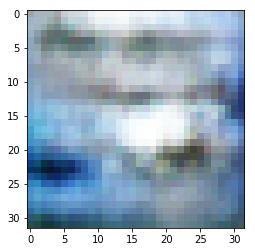

Epoch: [ 2 / 5 ],  Step: [ 270 / 781 ], D_loss:  0.83659786 , G_loss:  1.3448476
Epoch: [ 2 / 5 ],  Step: [ 271 / 781 ], D_loss:  0.9326769 , G_loss:  1.1653258
Epoch: [ 2 / 5 ],  Step: [ 272 / 781 ], D_loss:  0.9578808 , G_loss:  1.2957027
Epoch: [ 2 / 5 ],  Step: [ 273 / 781 ], D_loss:  0.7626551 , G_loss:  1.1958112
Epoch: [ 2 / 5 ],  Step: [ 274 / 781 ], D_loss:  0.72337097 , G_loss:  1.2115431
Epoch: [ 2 / 5 ],  Step: [ 275 / 781 ], D_loss:  0.6459523 , G_loss:  1.1127654
Epoch: [ 2 / 5 ],  Step: [ 276 / 781 ], D_loss:  0.63096285 , G_loss:  1.1776075
Epoch: [ 2 / 5 ],  Step: [ 277 / 781 ], D_loss:  0.6077029 , G_loss:  1.4726746
Epoch: [ 2 / 5 ],  Step: [ 278 / 781 ], D_loss:  0.55735743 , G_loss:  1.3316213
Epoch: [ 2 / 5 ],  Step: [ 279 / 781 ], D_loss:  0.76840097 , G_loss:  1.2707267
(196, 32, 32, 3)


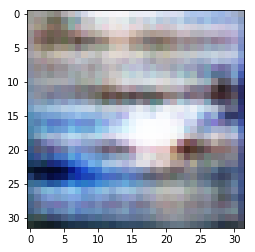

Epoch: [ 2 / 5 ],  Step: [ 280 / 781 ], D_loss:  0.87740695 , G_loss:  1.192316
Epoch: [ 2 / 5 ],  Step: [ 281 / 781 ], D_loss:  0.70848423 , G_loss:  1.3390832
Epoch: [ 2 / 5 ],  Step: [ 282 / 781 ], D_loss:  0.66500926 , G_loss:  1.220409
Epoch: [ 2 / 5 ],  Step: [ 283 / 781 ], D_loss:  0.61334753 , G_loss:  1.1687622
Epoch: [ 2 / 5 ],  Step: [ 284 / 781 ], D_loss:  0.71896714 , G_loss:  1.5534171
Epoch: [ 2 / 5 ],  Step: [ 285 / 781 ], D_loss:  0.6153173 , G_loss:  1.2576792
Epoch: [ 2 / 5 ],  Step: [ 286 / 781 ], D_loss:  0.6819706 , G_loss:  1.1498325
Epoch: [ 2 / 5 ],  Step: [ 287 / 781 ], D_loss:  0.87116796 , G_loss:  1.3645644
Epoch: [ 2 / 5 ],  Step: [ 288 / 781 ], D_loss:  0.84188884 , G_loss:  1.3155423
Epoch: [ 2 / 5 ],  Step: [ 289 / 781 ], D_loss:  0.9280446 , G_loss:  1.379462
(196, 32, 32, 3)


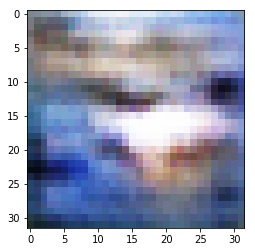

Epoch: [ 2 / 5 ],  Step: [ 290 / 781 ], D_loss:  0.6872197 , G_loss:  1.3447835
Epoch: [ 2 / 5 ],  Step: [ 291 / 781 ], D_loss:  0.52560806 , G_loss:  1.2492646
Epoch: [ 2 / 5 ],  Step: [ 292 / 781 ], D_loss:  0.7304968 , G_loss:  1.5705997
Epoch: [ 2 / 5 ],  Step: [ 293 / 781 ], D_loss:  0.55732733 , G_loss:  1.5046546
Epoch: [ 2 / 5 ],  Step: [ 294 / 781 ], D_loss:  0.72325194 , G_loss:  1.1527214
Epoch: [ 2 / 5 ],  Step: [ 295 / 781 ], D_loss:  0.70900655 , G_loss:  1.316325
Epoch: [ 2 / 5 ],  Step: [ 296 / 781 ], D_loss:  0.7494006 , G_loss:  1.1258761
Epoch: [ 2 / 5 ],  Step: [ 297 / 781 ], D_loss:  0.7225564 , G_loss:  1.3343022
Epoch: [ 2 / 5 ],  Step: [ 298 / 781 ], D_loss:  0.66382235 , G_loss:  1.1093185
Epoch: [ 2 / 5 ],  Step: [ 299 / 781 ], D_loss:  0.7130363 , G_loss:  1.2952919
(196, 32, 32, 3)


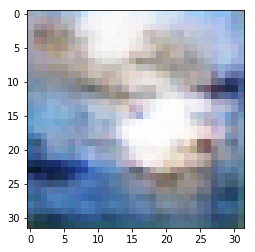

Epoch: [ 2 / 5 ],  Step: [ 300 / 781 ], D_loss:  0.61889267 , G_loss:  1.2340243
Epoch: [ 2 / 5 ],  Step: [ 301 / 781 ], D_loss:  0.5964669 , G_loss:  1.2175813
Epoch: [ 2 / 5 ],  Step: [ 302 / 781 ], D_loss:  0.60153157 , G_loss:  1.3488089
Epoch: [ 2 / 5 ],  Step: [ 303 / 781 ], D_loss:  0.48120913 , G_loss:  1.355447
Epoch: [ 2 / 5 ],  Step: [ 304 / 781 ], D_loss:  0.826895 , G_loss:  1.14177
Epoch: [ 2 / 5 ],  Step: [ 305 / 781 ], D_loss:  0.7004671 , G_loss:  1.118784
Epoch: [ 2 / 5 ],  Step: [ 306 / 781 ], D_loss:  0.68937236 , G_loss:  1.2287264
Epoch: [ 2 / 5 ],  Step: [ 307 / 781 ], D_loss:  0.6669383 , G_loss:  1.1118662
Epoch: [ 2 / 5 ],  Step: [ 308 / 781 ], D_loss:  0.60185254 , G_loss:  1.4026654
Epoch: [ 2 / 5 ],  Step: [ 309 / 781 ], D_loss:  0.5285093 , G_loss:  1.2895235
(196, 32, 32, 3)


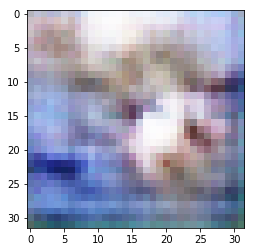

Epoch: [ 2 / 5 ],  Step: [ 310 / 781 ], D_loss:  0.5897055 , G_loss:  1.100519
Epoch: [ 2 / 5 ],  Step: [ 311 / 781 ], D_loss:  0.811188 , G_loss:  1.8157655
Epoch: [ 2 / 5 ],  Step: [ 312 / 781 ], D_loss:  0.9009262 , G_loss:  1.5982844
Epoch: [ 2 / 5 ],  Step: [ 313 / 781 ], D_loss:  0.65137494 , G_loss:  1.0864524
Epoch: [ 2 / 5 ],  Step: [ 314 / 781 ], D_loss:  0.7502187 , G_loss:  1.5536225
Epoch: [ 2 / 5 ],  Step: [ 315 / 781 ], D_loss:  0.6544848 , G_loss:  1.3807186
Epoch: [ 2 / 5 ],  Step: [ 316 / 781 ], D_loss:  0.71438354 , G_loss:  1.2566999
Epoch: [ 2 / 5 ],  Step: [ 317 / 781 ], D_loss:  0.71485835 , G_loss:  1.5444605
Epoch: [ 2 / 5 ],  Step: [ 318 / 781 ], D_loss:  0.7768087 , G_loss:  1.2979554
Epoch: [ 2 / 5 ],  Step: [ 319 / 781 ], D_loss:  0.64043444 , G_loss:  1.1002928
(196, 32, 32, 3)


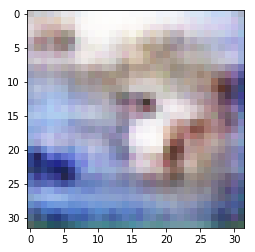

Epoch: [ 2 / 5 ],  Step: [ 320 / 781 ], D_loss:  0.7325523 , G_loss:  1.3969927
Epoch: [ 2 / 5 ],  Step: [ 321 / 781 ], D_loss:  0.9099713 , G_loss:  1.16606
Epoch: [ 2 / 5 ],  Step: [ 322 / 781 ], D_loss:  0.6635098 , G_loss:  1.2155945
Epoch: [ 2 / 5 ],  Step: [ 323 / 781 ], D_loss:  0.59179807 , G_loss:  1.2980694
Epoch: [ 2 / 5 ],  Step: [ 324 / 781 ], D_loss:  0.690515 , G_loss:  1.0631557
Epoch: [ 2 / 5 ],  Step: [ 325 / 781 ], D_loss:  0.67808175 , G_loss:  1.3210671
Epoch: [ 2 / 5 ],  Step: [ 326 / 781 ], D_loss:  0.679395 , G_loss:  1.106761
Epoch: [ 2 / 5 ],  Step: [ 327 / 781 ], D_loss:  0.66592205 , G_loss:  0.9577174
Epoch: [ 2 / 5 ],  Step: [ 328 / 781 ], D_loss:  0.83545786 , G_loss:  1.0633245
Epoch: [ 2 / 5 ],  Step: [ 329 / 781 ], D_loss:  0.8774856 , G_loss:  1.0471711
(196, 32, 32, 3)


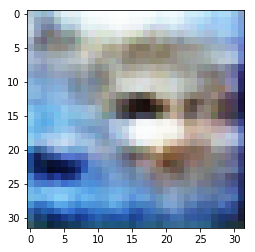

Epoch: [ 2 / 5 ],  Step: [ 330 / 781 ], D_loss:  0.82383317 , G_loss:  1.2508931
Epoch: [ 2 / 5 ],  Step: [ 331 / 781 ], D_loss:  0.82555574 , G_loss:  1.4859319
Epoch: [ 2 / 5 ],  Step: [ 332 / 781 ], D_loss:  0.7577139 , G_loss:  1.2448728
Epoch: [ 2 / 5 ],  Step: [ 333 / 781 ], D_loss:  0.80987406 , G_loss:  1.0462639
Epoch: [ 2 / 5 ],  Step: [ 334 / 781 ], D_loss:  0.69122106 , G_loss:  1.5676453
Epoch: [ 2 / 5 ],  Step: [ 335 / 781 ], D_loss:  0.68908185 , G_loss:  1.3070853
Epoch: [ 2 / 5 ],  Step: [ 336 / 781 ], D_loss:  0.64380753 , G_loss:  1.1900762
Epoch: [ 2 / 5 ],  Step: [ 337 / 781 ], D_loss:  0.8164762 , G_loss:  1.5265276
Epoch: [ 2 / 5 ],  Step: [ 338 / 781 ], D_loss:  0.6736593 , G_loss:  1.3389255
Epoch: [ 2 / 5 ],  Step: [ 339 / 781 ], D_loss:  0.8063784 , G_loss:  1.1671164
(196, 32, 32, 3)


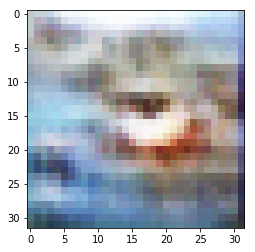

Epoch: [ 2 / 5 ],  Step: [ 340 / 781 ], D_loss:  0.6656647 , G_loss:  1.3381398
Epoch: [ 2 / 5 ],  Step: [ 341 / 781 ], D_loss:  0.49693996 , G_loss:  1.4403372
Epoch: [ 2 / 5 ],  Step: [ 342 / 781 ], D_loss:  0.5557409 , G_loss:  1.2249177
Epoch: [ 2 / 5 ],  Step: [ 343 / 781 ], D_loss:  0.7048733 , G_loss:  1.4533961
Epoch: [ 2 / 5 ],  Step: [ 344 / 781 ], D_loss:  0.6494224 , G_loss:  1.2377601
Epoch: [ 2 / 5 ],  Step: [ 345 / 781 ], D_loss:  0.95216805 , G_loss:  1.2181075
Epoch: [ 2 / 5 ],  Step: [ 346 / 781 ], D_loss:  1.5077684 , G_loss:  2.077457
Epoch: [ 2 / 5 ],  Step: [ 347 / 781 ], D_loss:  1.2256064 , G_loss:  1.7336484
Epoch: [ 2 / 5 ],  Step: [ 348 / 781 ], D_loss:  1.2000749 , G_loss:  1.4631126
Epoch: [ 2 / 5 ],  Step: [ 349 / 781 ], D_loss:  1.0741632 , G_loss:  1.2802674
(196, 32, 32, 3)


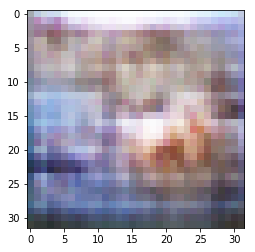

Epoch: [ 2 / 5 ],  Step: [ 350 / 781 ], D_loss:  1.1526443 , G_loss:  1.2843927
Epoch: [ 2 / 5 ],  Step: [ 351 / 781 ], D_loss:  0.8867469 , G_loss:  1.1489602
Epoch: [ 2 / 5 ],  Step: [ 352 / 781 ], D_loss:  1.0756338 , G_loss:  1.7675259
Epoch: [ 2 / 5 ],  Step: [ 353 / 781 ], D_loss:  1.0733515 , G_loss:  1.3890357
Epoch: [ 2 / 5 ],  Step: [ 354 / 781 ], D_loss:  1.0423347 , G_loss:  1.3910615
Epoch: [ 2 / 5 ],  Step: [ 355 / 781 ], D_loss:  0.9991981 , G_loss:  1.1525615
Epoch: [ 2 / 5 ],  Step: [ 356 / 781 ], D_loss:  0.7190695 , G_loss:  1.1912409
Epoch: [ 2 / 5 ],  Step: [ 357 / 781 ], D_loss:  0.8385263 , G_loss:  1.4034035
Epoch: [ 2 / 5 ],  Step: [ 358 / 781 ], D_loss:  0.9265116 , G_loss:  1.2234422
Epoch: [ 2 / 5 ],  Step: [ 359 / 781 ], D_loss:  0.7540335 , G_loss:  1.0471067
(196, 32, 32, 3)


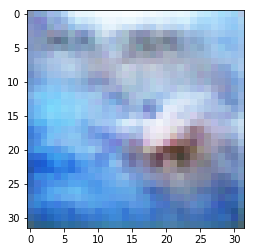

Epoch: [ 2 / 5 ],  Step: [ 360 / 781 ], D_loss:  0.7663628 , G_loss:  1.3607936
Epoch: [ 2 / 5 ],  Step: [ 361 / 781 ], D_loss:  0.629982 , G_loss:  1.2729874
Epoch: [ 2 / 5 ],  Step: [ 362 / 781 ], D_loss:  0.66372997 , G_loss:  1.331207
Epoch: [ 2 / 5 ],  Step: [ 363 / 781 ], D_loss:  0.6450825 , G_loss:  1.2870717
Epoch: [ 2 / 5 ],  Step: [ 364 / 781 ], D_loss:  0.58606046 , G_loss:  1.2023808
Epoch: [ 2 / 5 ],  Step: [ 365 / 781 ], D_loss:  0.73631155 , G_loss:  1.3965857
Epoch: [ 2 / 5 ],  Step: [ 366 / 781 ], D_loss:  0.75836784 , G_loss:  1.2091005
Epoch: [ 2 / 5 ],  Step: [ 367 / 781 ], D_loss:  0.64036185 , G_loss:  1.4267163
Epoch: [ 2 / 5 ],  Step: [ 368 / 781 ], D_loss:  0.75669247 , G_loss:  1.0673866
Epoch: [ 2 / 5 ],  Step: [ 369 / 781 ], D_loss:  0.8059393 , G_loss:  1.812299
(196, 32, 32, 3)


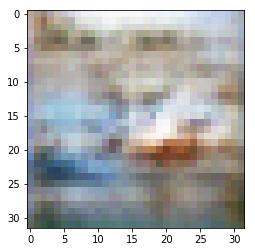

Epoch: [ 2 / 5 ],  Step: [ 370 / 781 ], D_loss:  0.75869995 , G_loss:  1.5505961
Epoch: [ 2 / 5 ],  Step: [ 371 / 781 ], D_loss:  0.86043864 , G_loss:  1.1275437
Epoch: [ 2 / 5 ],  Step: [ 372 / 781 ], D_loss:  1.0864551 , G_loss:  1.456531
Epoch: [ 2 / 5 ],  Step: [ 373 / 781 ], D_loss:  0.8812201 , G_loss:  1.4633842
Epoch: [ 2 / 5 ],  Step: [ 374 / 781 ], D_loss:  1.0129755 , G_loss:  1.3496917
Epoch: [ 2 / 5 ],  Step: [ 375 / 781 ], D_loss:  0.73992324 , G_loss:  1.1994401
Epoch: [ 2 / 5 ],  Step: [ 376 / 781 ], D_loss:  0.7458309 , G_loss:  1.3974527
Epoch: [ 2 / 5 ],  Step: [ 377 / 781 ], D_loss:  0.68843114 , G_loss:  1.2042229
Epoch: [ 2 / 5 ],  Step: [ 378 / 781 ], D_loss:  0.84112597 , G_loss:  1.7899631
Epoch: [ 2 / 5 ],  Step: [ 379 / 781 ], D_loss:  0.8583778 , G_loss:  1.5177089
(196, 32, 32, 3)


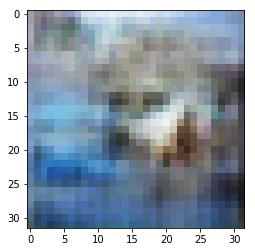

Epoch: [ 2 / 5 ],  Step: [ 380 / 781 ], D_loss:  0.7857991 , G_loss:  1.1244726
Epoch: [ 2 / 5 ],  Step: [ 381 / 781 ], D_loss:  0.8294366 , G_loss:  1.7749033
Epoch: [ 2 / 5 ],  Step: [ 382 / 781 ], D_loss:  0.63902193 , G_loss:  1.4354075
Epoch: [ 2 / 5 ],  Step: [ 383 / 781 ], D_loss:  0.7347921 , G_loss:  1.0877385
Epoch: [ 2 / 5 ],  Step: [ 384 / 781 ], D_loss:  1.0054964 , G_loss:  2.1168306
Epoch: [ 2 / 5 ],  Step: [ 385 / 781 ], D_loss:  0.9858365 , G_loss:  1.7965117
Epoch: [ 2 / 5 ],  Step: [ 386 / 781 ], D_loss:  0.9449407 , G_loss:  1.3014474
Epoch: [ 2 / 5 ],  Step: [ 387 / 781 ], D_loss:  0.8926576 , G_loss:  1.6965045
Epoch: [ 2 / 5 ],  Step: [ 388 / 781 ], D_loss:  0.7972194 , G_loss:  1.2985554
Epoch: [ 2 / 5 ],  Step: [ 389 / 781 ], D_loss:  0.8618821 , G_loss:  1.3930917
(196, 32, 32, 3)


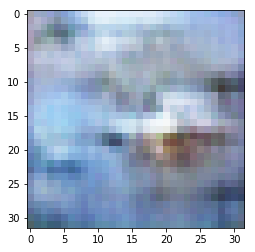

Epoch: [ 2 / 5 ],  Step: [ 390 / 781 ], D_loss:  0.8486767 , G_loss:  1.3039213
Epoch: [ 2 / 5 ],  Step: [ 391 / 781 ], D_loss:  0.7863123 , G_loss:  1.0532851
Epoch: [ 2 / 5 ],  Step: [ 392 / 781 ], D_loss:  0.9581367 , G_loss:  1.422354
Epoch: [ 2 / 5 ],  Step: [ 393 / 781 ], D_loss:  0.7949474 , G_loss:  1.2150364
Epoch: [ 2 / 5 ],  Step: [ 394 / 781 ], D_loss:  0.77273124 , G_loss:  1.1594465
Epoch: [ 2 / 5 ],  Step: [ 395 / 781 ], D_loss:  0.823944 , G_loss:  1.5294733
Epoch: [ 2 / 5 ],  Step: [ 396 / 781 ], D_loss:  0.81220853 , G_loss:  1.3467278
Epoch: [ 2 / 5 ],  Step: [ 397 / 781 ], D_loss:  0.6925831 , G_loss:  1.1304408
Epoch: [ 2 / 5 ],  Step: [ 398 / 781 ], D_loss:  0.66447705 , G_loss:  1.3324156
Epoch: [ 2 / 5 ],  Step: [ 399 / 781 ], D_loss:  0.7198362 , G_loss:  1.1898866
(196, 32, 32, 3)


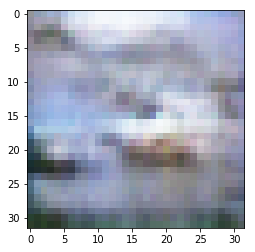

Epoch: [ 2 / 5 ],  Step: [ 400 / 781 ], D_loss:  0.78730094 , G_loss:  1.1903737
Epoch: [ 2 / 5 ],  Step: [ 401 / 781 ], D_loss:  0.89048696 , G_loss:  1.2306921
Epoch: [ 2 / 5 ],  Step: [ 402 / 781 ], D_loss:  0.7297868 , G_loss:  1.3486972
Epoch: [ 2 / 5 ],  Step: [ 403 / 781 ], D_loss:  0.6646137 , G_loss:  1.287739
Epoch: [ 2 / 5 ],  Step: [ 404 / 781 ], D_loss:  0.7776446 , G_loss:  1.4175352
Epoch: [ 2 / 5 ],  Step: [ 405 / 781 ], D_loss:  0.81464684 , G_loss:  1.2383178
Epoch: [ 2 / 5 ],  Step: [ 406 / 781 ], D_loss:  0.6398748 , G_loss:  1.3138001
Epoch: [ 2 / 5 ],  Step: [ 407 / 781 ], D_loss:  0.6805537 , G_loss:  1.3359984
Epoch: [ 2 / 5 ],  Step: [ 408 / 781 ], D_loss:  0.5772904 , G_loss:  1.1239376
Epoch: [ 2 / 5 ],  Step: [ 409 / 781 ], D_loss:  0.72423536 , G_loss:  1.5087647
(196, 32, 32, 3)


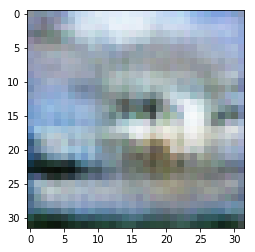

Epoch: [ 2 / 5 ],  Step: [ 410 / 781 ], D_loss:  0.66700923 , G_loss:  1.3605715
Epoch: [ 2 / 5 ],  Step: [ 411 / 781 ], D_loss:  0.6761828 , G_loss:  1.2714566
Epoch: [ 2 / 5 ],  Step: [ 412 / 781 ], D_loss:  0.6507719 , G_loss:  1.1725512
Epoch: [ 2 / 5 ],  Step: [ 413 / 781 ], D_loss:  0.8825275 , G_loss:  1.6512784
Epoch: [ 2 / 5 ],  Step: [ 414 / 781 ], D_loss:  0.6580358 , G_loss:  1.5095918
Epoch: [ 2 / 5 ],  Step: [ 415 / 781 ], D_loss:  0.5191253 , G_loss:  1.1277666
Epoch: [ 2 / 5 ],  Step: [ 416 / 781 ], D_loss:  0.78212404 , G_loss:  1.6639293
Epoch: [ 2 / 5 ],  Step: [ 417 / 781 ], D_loss:  0.6296684 , G_loss:  1.491389
Epoch: [ 2 / 5 ],  Step: [ 418 / 781 ], D_loss:  0.8410596 , G_loss:  1.2651678
Epoch: [ 2 / 5 ],  Step: [ 419 / 781 ], D_loss:  0.9144011 , G_loss:  1.2552543
(196, 32, 32, 3)


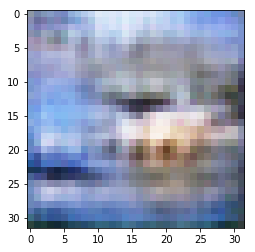

Epoch: [ 2 / 5 ],  Step: [ 420 / 781 ], D_loss:  0.9017533 , G_loss:  1.0918074
Epoch: [ 2 / 5 ],  Step: [ 421 / 781 ], D_loss:  0.9333187 , G_loss:  1.5220221
Epoch: [ 2 / 5 ],  Step: [ 422 / 781 ], D_loss:  0.7180395 , G_loss:  1.2060896
Epoch: [ 2 / 5 ],  Step: [ 423 / 781 ], D_loss:  0.8845184 , G_loss:  1.0799193
Epoch: [ 2 / 5 ],  Step: [ 424 / 781 ], D_loss:  0.70930946 , G_loss:  1.6098146
Epoch: [ 2 / 5 ],  Step: [ 425 / 781 ], D_loss:  0.77316415 , G_loss:  1.3803523
Epoch: [ 2 / 5 ],  Step: [ 426 / 781 ], D_loss:  0.6153438 , G_loss:  1.0691711
Epoch: [ 2 / 5 ],  Step: [ 427 / 781 ], D_loss:  0.6630704 , G_loss:  0.93482655
Epoch: [ 2 / 5 ],  Step: [ 428 / 781 ], D_loss:  1.0301225 , G_loss:  1.8436131
Epoch: [ 2 / 5 ],  Step: [ 429 / 781 ], D_loss:  1.0358566 , G_loss:  1.4303684
(196, 32, 32, 3)


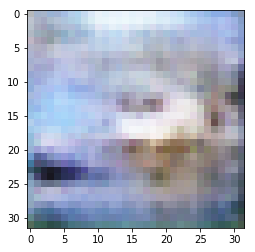

Epoch: [ 2 / 5 ],  Step: [ 430 / 781 ], D_loss:  0.9449746 , G_loss:  0.9661149
Epoch: [ 2 / 5 ],  Step: [ 431 / 781 ], D_loss:  1.1581584 , G_loss:  2.1851544
Epoch: [ 2 / 5 ],  Step: [ 432 / 781 ], D_loss:  1.286137 , G_loss:  1.7869337
Epoch: [ 2 / 5 ],  Step: [ 433 / 781 ], D_loss:  1.2186387 , G_loss:  0.9853463
Epoch: [ 2 / 5 ],  Step: [ 434 / 781 ], D_loss:  1.3416014 , G_loss:  1.794038
Epoch: [ 2 / 5 ],  Step: [ 435 / 781 ], D_loss:  1.1935515 , G_loss:  1.6651659
Epoch: [ 2 / 5 ],  Step: [ 436 / 781 ], D_loss:  0.8543542 , G_loss:  1.0589362
Epoch: [ 2 / 5 ],  Step: [ 437 / 781 ], D_loss:  1.3073459 , G_loss:  1.7458881
Epoch: [ 2 / 5 ],  Step: [ 438 / 781 ], D_loss:  1.1058075 , G_loss:  1.5313582
Epoch: [ 2 / 5 ],  Step: [ 439 / 781 ], D_loss:  1.0797651 , G_loss:  1.5532057
(196, 32, 32, 3)


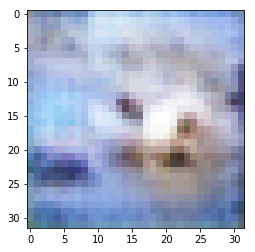

Epoch: [ 2 / 5 ],  Step: [ 440 / 781 ], D_loss:  0.9117116 , G_loss:  1.2634197
Epoch: [ 2 / 5 ],  Step: [ 441 / 781 ], D_loss:  0.73932487 , G_loss:  1.2940596
Epoch: [ 2 / 5 ],  Step: [ 442 / 781 ], D_loss:  0.77619845 , G_loss:  1.1813961
Epoch: [ 2 / 5 ],  Step: [ 443 / 781 ], D_loss:  0.74490047 , G_loss:  1.1657411
Epoch: [ 2 / 5 ],  Step: [ 444 / 781 ], D_loss:  0.46480787 , G_loss:  1.2295518
Epoch: [ 2 / 5 ],  Step: [ 445 / 781 ], D_loss:  0.7200366 , G_loss:  1.1587518
Epoch: [ 2 / 5 ],  Step: [ 446 / 781 ], D_loss:  0.9125533 , G_loss:  1.3368117
Epoch: [ 2 / 5 ],  Step: [ 447 / 781 ], D_loss:  0.7410299 , G_loss:  1.2770133
Epoch: [ 2 / 5 ],  Step: [ 448 / 781 ], D_loss:  0.6032004 , G_loss:  1.177598
Epoch: [ 2 / 5 ],  Step: [ 449 / 781 ], D_loss:  0.55706424 , G_loss:  1.2909464
(196, 32, 32, 3)


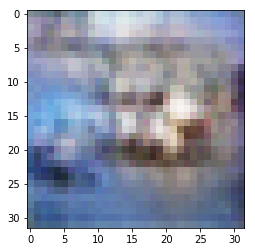

Epoch: [ 2 / 5 ],  Step: [ 450 / 781 ], D_loss:  0.51206934 , G_loss:  1.1886985
Epoch: [ 2 / 5 ],  Step: [ 451 / 781 ], D_loss:  0.7410892 , G_loss:  1.3487921
Epoch: [ 2 / 5 ],  Step: [ 452 / 781 ], D_loss:  0.810682 , G_loss:  1.3596092
Epoch: [ 2 / 5 ],  Step: [ 453 / 781 ], D_loss:  0.66880345 , G_loss:  1.162505
Epoch: [ 2 / 5 ],  Step: [ 454 / 781 ], D_loss:  0.79608923 , G_loss:  1.1275989
Epoch: [ 2 / 5 ],  Step: [ 455 / 781 ], D_loss:  0.76997024 , G_loss:  1.2867556
Epoch: [ 2 / 5 ],  Step: [ 456 / 781 ], D_loss:  0.72807324 , G_loss:  1.2379591
Epoch: [ 2 / 5 ],  Step: [ 457 / 781 ], D_loss:  0.8070873 , G_loss:  1.130261
Epoch: [ 2 / 5 ],  Step: [ 458 / 781 ], D_loss:  0.7729535 , G_loss:  0.99444354
Epoch: [ 2 / 5 ],  Step: [ 459 / 781 ], D_loss:  0.83097035 , G_loss:  1.5704316
(196, 32, 32, 3)


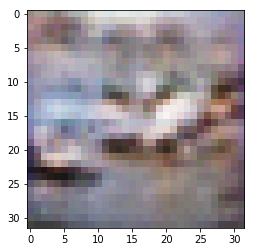

Epoch: [ 2 / 5 ],  Step: [ 460 / 781 ], D_loss:  0.7173098 , G_loss:  1.4588764
Epoch: [ 2 / 5 ],  Step: [ 461 / 781 ], D_loss:  0.6922144 , G_loss:  1.2765379
Epoch: [ 2 / 5 ],  Step: [ 462 / 781 ], D_loss:  0.6467452 , G_loss:  1.2555629
Epoch: [ 2 / 5 ],  Step: [ 463 / 781 ], D_loss:  0.7121796 , G_loss:  1.4595528
Epoch: [ 2 / 5 ],  Step: [ 464 / 781 ], D_loss:  0.5430875 , G_loss:  1.4174113
Epoch: [ 2 / 5 ],  Step: [ 465 / 781 ], D_loss:  0.68654037 , G_loss:  1.153225
Epoch: [ 2 / 5 ],  Step: [ 466 / 781 ], D_loss:  0.74802154 , G_loss:  1.3481303
Epoch: [ 2 / 5 ],  Step: [ 467 / 781 ], D_loss:  0.67655313 , G_loss:  1.2874322
Epoch: [ 2 / 5 ],  Step: [ 468 / 781 ], D_loss:  0.714095 , G_loss:  1.0938327
Epoch: [ 2 / 5 ],  Step: [ 469 / 781 ], D_loss:  0.86323524 , G_loss:  1.6636361
(196, 32, 32, 3)


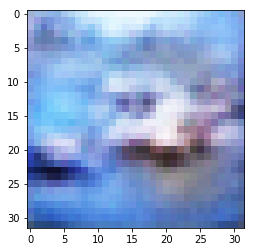

Epoch: [ 2 / 5 ],  Step: [ 470 / 781 ], D_loss:  1.1190546 , G_loss:  1.564131
Epoch: [ 2 / 5 ],  Step: [ 471 / 781 ], D_loss:  1.1301327 , G_loss:  0.936652
Epoch: [ 2 / 5 ],  Step: [ 472 / 781 ], D_loss:  1.6019483 , G_loss:  2.3496594
Epoch: [ 2 / 5 ],  Step: [ 473 / 781 ], D_loss:  1.3178384 , G_loss:  2.3477361
Epoch: [ 2 / 5 ],  Step: [ 474 / 781 ], D_loss:  1.0654465 , G_loss:  1.484641
Epoch: [ 2 / 5 ],  Step: [ 475 / 781 ], D_loss:  0.92249954 , G_loss:  1.1411898
Epoch: [ 2 / 5 ],  Step: [ 476 / 781 ], D_loss:  1.2212017 , G_loss:  1.7905633
Epoch: [ 2 / 5 ],  Step: [ 477 / 781 ], D_loss:  1.181935 , G_loss:  1.6891211
Epoch: [ 2 / 5 ],  Step: [ 478 / 781 ], D_loss:  1.1426938 , G_loss:  1.0958693
Epoch: [ 2 / 5 ],  Step: [ 479 / 781 ], D_loss:  1.098468 , G_loss:  1.8839548
(196, 32, 32, 3)


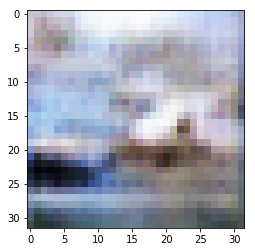

Epoch: [ 2 / 5 ],  Step: [ 480 / 781 ], D_loss:  1.0393646 , G_loss:  1.4089178
Epoch: [ 2 / 5 ],  Step: [ 481 / 781 ], D_loss:  1.0447692 , G_loss:  1.2580588
Epoch: [ 2 / 5 ],  Step: [ 482 / 781 ], D_loss:  1.0086308 , G_loss:  1.6161401
Epoch: [ 2 / 5 ],  Step: [ 483 / 781 ], D_loss:  1.0330131 , G_loss:  1.4666997
Epoch: [ 2 / 5 ],  Step: [ 484 / 781 ], D_loss:  1.0211513 , G_loss:  1.1137407
Epoch: [ 2 / 5 ],  Step: [ 485 / 781 ], D_loss:  1.0019852 , G_loss:  1.4078586
Epoch: [ 2 / 5 ],  Step: [ 486 / 781 ], D_loss:  0.7949494 , G_loss:  1.2486557
Epoch: [ 2 / 5 ],  Step: [ 487 / 781 ], D_loss:  0.7461354 , G_loss:  1.1589171
Epoch: [ 2 / 5 ],  Step: [ 488 / 781 ], D_loss:  0.77991796 , G_loss:  1.3054588
Epoch: [ 2 / 5 ],  Step: [ 489 / 781 ], D_loss:  0.83010936 , G_loss:  1.1207619
(196, 32, 32, 3)


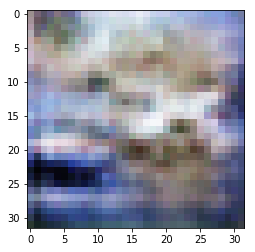

Epoch: [ 2 / 5 ],  Step: [ 490 / 781 ], D_loss:  0.8604027 , G_loss:  1.1919292
Epoch: [ 2 / 5 ],  Step: [ 491 / 781 ], D_loss:  1.0528958 , G_loss:  1.4218143
Epoch: [ 2 / 5 ],  Step: [ 492 / 781 ], D_loss:  1.053559 , G_loss:  1.6866498
Epoch: [ 2 / 5 ],  Step: [ 493 / 781 ], D_loss:  1.0554907 , G_loss:  1.3209865
Epoch: [ 2 / 5 ],  Step: [ 494 / 781 ], D_loss:  0.7600013 , G_loss:  1.0088636
Epoch: [ 2 / 5 ],  Step: [ 495 / 781 ], D_loss:  1.1296434 , G_loss:  2.2070615
Epoch: [ 2 / 5 ],  Step: [ 496 / 781 ], D_loss:  1.2773348 , G_loss:  2.0933545
Epoch: [ 2 / 5 ],  Step: [ 497 / 781 ], D_loss:  1.3383737 , G_loss:  1.5745343
Epoch: [ 2 / 5 ],  Step: [ 498 / 781 ], D_loss:  1.2012094 , G_loss:  1.0260826
Epoch: [ 2 / 5 ],  Step: [ 499 / 781 ], D_loss:  0.9081903 , G_loss:  1.0463681
(196, 32, 32, 3)


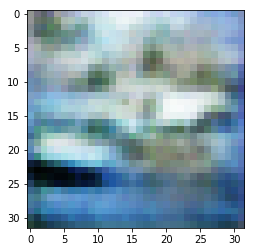

Epoch: [ 2 / 5 ],  Step: [ 500 / 781 ], D_loss:  0.9978931 , G_loss:  1.5260663
Epoch: [ 2 / 5 ],  Step: [ 501 / 781 ], D_loss:  0.93737686 , G_loss:  1.2236254
Epoch: [ 2 / 5 ],  Step: [ 502 / 781 ], D_loss:  0.7584419 , G_loss:  1.0400915
Epoch: [ 2 / 5 ],  Step: [ 503 / 781 ], D_loss:  0.8045207 , G_loss:  1.2801027
Epoch: [ 2 / 5 ],  Step: [ 504 / 781 ], D_loss:  0.73409903 , G_loss:  1.1950119
Epoch: [ 2 / 5 ],  Step: [ 505 / 781 ], D_loss:  0.9654142 , G_loss:  1.0199999
Epoch: [ 2 / 5 ],  Step: [ 506 / 781 ], D_loss:  1.1461523 , G_loss:  1.6588986
Epoch: [ 2 / 5 ],  Step: [ 507 / 781 ], D_loss:  1.0474783 , G_loss:  1.4626673
Epoch: [ 2 / 5 ],  Step: [ 508 / 781 ], D_loss:  1.0249484 , G_loss:  0.9458739
Epoch: [ 2 / 5 ],  Step: [ 509 / 781 ], D_loss:  1.1488953 , G_loss:  1.4389731
(196, 32, 32, 3)


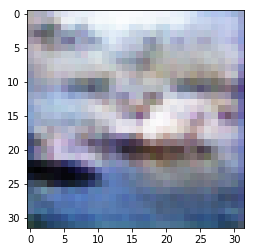

Epoch: [ 2 / 5 ],  Step: [ 510 / 781 ], D_loss:  0.8981161 , G_loss:  1.3583848
Epoch: [ 2 / 5 ],  Step: [ 511 / 781 ], D_loss:  1.0488832 , G_loss:  1.3123331
Epoch: [ 2 / 5 ],  Step: [ 512 / 781 ], D_loss:  0.9785409 , G_loss:  0.9947867
Epoch: [ 2 / 5 ],  Step: [ 513 / 781 ], D_loss:  1.0233699 , G_loss:  1.1535578
Epoch: [ 2 / 5 ],  Step: [ 514 / 781 ], D_loss:  0.7507111 , G_loss:  1.0964162
Epoch: [ 2 / 5 ],  Step: [ 515 / 781 ], D_loss:  0.79046535 , G_loss:  1.3281335
Epoch: [ 2 / 5 ],  Step: [ 516 / 781 ], D_loss:  0.8691737 , G_loss:  1.2378771
Epoch: [ 2 / 5 ],  Step: [ 517 / 781 ], D_loss:  0.7426525 , G_loss:  1.0027848
Epoch: [ 2 / 5 ],  Step: [ 518 / 781 ], D_loss:  0.78863144 , G_loss:  1.0231574
Epoch: [ 2 / 5 ],  Step: [ 519 / 781 ], D_loss:  0.77890265 , G_loss:  1.2573524
(196, 32, 32, 3)


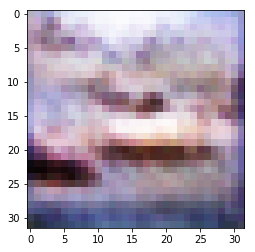

Epoch: [ 2 / 5 ],  Step: [ 520 / 781 ], D_loss:  0.8986768 , G_loss:  0.9950963
Epoch: [ 2 / 5 ],  Step: [ 521 / 781 ], D_loss:  0.8936095 , G_loss:  1.1149457
Epoch: [ 2 / 5 ],  Step: [ 522 / 781 ], D_loss:  0.801564 , G_loss:  1.2169666
Epoch: [ 2 / 5 ],  Step: [ 523 / 781 ], D_loss:  0.8678399 , G_loss:  0.8297992
Epoch: [ 2 / 5 ],  Step: [ 524 / 781 ], D_loss:  0.94749457 , G_loss:  1.6260164
Epoch: [ 2 / 5 ],  Step: [ 525 / 781 ], D_loss:  0.97691417 , G_loss:  1.4445877
Epoch: [ 2 / 5 ],  Step: [ 526 / 781 ], D_loss:  0.9456666 , G_loss:  0.94142663
Epoch: [ 2 / 5 ],  Step: [ 527 / 781 ], D_loss:  1.122209 , G_loss:  1.7554588
Epoch: [ 2 / 5 ],  Step: [ 528 / 781 ], D_loss:  0.97007155 , G_loss:  1.5085602
Epoch: [ 2 / 5 ],  Step: [ 529 / 781 ], D_loss:  0.8037671 , G_loss:  1.0369177
(196, 32, 32, 3)


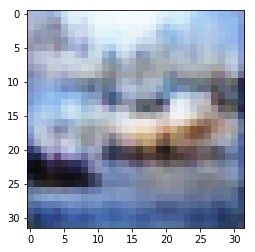

Epoch: [ 2 / 5 ],  Step: [ 530 / 781 ], D_loss:  0.79239696 , G_loss:  1.2076069
Epoch: [ 2 / 5 ],  Step: [ 531 / 781 ], D_loss:  0.8591144 , G_loss:  1.2116387
Epoch: [ 2 / 5 ],  Step: [ 532 / 781 ], D_loss:  0.7151349 , G_loss:  1.122511
Epoch: [ 2 / 5 ],  Step: [ 533 / 781 ], D_loss:  0.7087626 , G_loss:  1.1777847
Epoch: [ 2 / 5 ],  Step: [ 534 / 781 ], D_loss:  0.81048614 , G_loss:  1.1800891
Epoch: [ 2 / 5 ],  Step: [ 535 / 781 ], D_loss:  0.67338896 , G_loss:  1.3816763
Epoch: [ 2 / 5 ],  Step: [ 536 / 781 ], D_loss:  0.76187 , G_loss:  1.138934
Epoch: [ 2 / 5 ],  Step: [ 537 / 781 ], D_loss:  0.7450037 , G_loss:  1.0605302
Epoch: [ 2 / 5 ],  Step: [ 538 / 781 ], D_loss:  0.70513415 , G_loss:  1.1687491
Epoch: [ 2 / 5 ],  Step: [ 539 / 781 ], D_loss:  0.74364877 , G_loss:  1.103128
(196, 32, 32, 3)


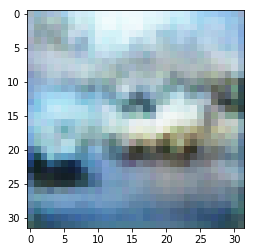

Epoch: [ 2 / 5 ],  Step: [ 540 / 781 ], D_loss:  0.6463757 , G_loss:  1.5659374
Epoch: [ 2 / 5 ],  Step: [ 541 / 781 ], D_loss:  0.82301944 , G_loss:  1.2766511
Epoch: [ 2 / 5 ],  Step: [ 542 / 781 ], D_loss:  0.6481629 , G_loss:  1.0136973
Epoch: [ 2 / 5 ],  Step: [ 543 / 781 ], D_loss:  0.8657465 , G_loss:  1.2689748
Epoch: [ 2 / 5 ],  Step: [ 544 / 781 ], D_loss:  0.64176476 , G_loss:  1.2156996
Epoch: [ 2 / 5 ],  Step: [ 545 / 781 ], D_loss:  0.9640053 , G_loss:  1.0096102
Epoch: [ 2 / 5 ],  Step: [ 546 / 781 ], D_loss:  0.85561985 , G_loss:  1.1498454
Epoch: [ 2 / 5 ],  Step: [ 547 / 781 ], D_loss:  0.7251477 , G_loss:  1.1864066
Epoch: [ 2 / 5 ],  Step: [ 548 / 781 ], D_loss:  0.8336191 , G_loss:  0.99078417
Epoch: [ 2 / 5 ],  Step: [ 549 / 781 ], D_loss:  0.8609446 , G_loss:  1.4610091
(196, 32, 32, 3)


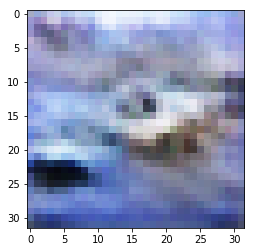

Epoch: [ 2 / 5 ],  Step: [ 550 / 781 ], D_loss:  0.92133486 , G_loss:  1.4105226
Epoch: [ 2 / 5 ],  Step: [ 551 / 781 ], D_loss:  1.0064329 , G_loss:  1.0810215
Epoch: [ 2 / 5 ],  Step: [ 552 / 781 ], D_loss:  0.76028264 , G_loss:  1.0618825
Epoch: [ 2 / 5 ],  Step: [ 553 / 781 ], D_loss:  0.72194636 , G_loss:  1.1330637
Epoch: [ 2 / 5 ],  Step: [ 554 / 781 ], D_loss:  0.8202164 , G_loss:  0.9325872
Epoch: [ 2 / 5 ],  Step: [ 555 / 781 ], D_loss:  0.90302414 , G_loss:  1.613323
Epoch: [ 2 / 5 ],  Step: [ 556 / 781 ], D_loss:  0.93926746 , G_loss:  1.3843145
Epoch: [ 2 / 5 ],  Step: [ 557 / 781 ], D_loss:  0.6830888 , G_loss:  0.83371645
Epoch: [ 2 / 5 ],  Step: [ 558 / 781 ], D_loss:  1.218819 , G_loss:  1.8686446
Epoch: [ 2 / 5 ],  Step: [ 559 / 781 ], D_loss:  1.0356593 , G_loss:  1.0733558
(196, 32, 32, 3)


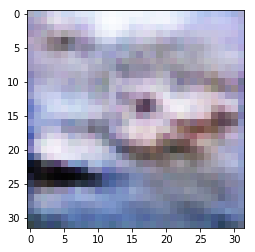

Epoch: [ 2 / 5 ],  Step: [ 560 / 781 ], D_loss:  1.0210075 , G_loss:  1.2299178
Epoch: [ 2 / 5 ],  Step: [ 561 / 781 ], D_loss:  1.1908389 , G_loss:  1.154307
Epoch: [ 2 / 5 ],  Step: [ 562 / 781 ], D_loss:  0.9687767 , G_loss:  1.0662045
Epoch: [ 2 / 5 ],  Step: [ 563 / 781 ], D_loss:  1.0915769 , G_loss:  1.1959021
Epoch: [ 2 / 5 ],  Step: [ 564 / 781 ], D_loss:  1.0684382 , G_loss:  0.9652975
Epoch: [ 2 / 5 ],  Step: [ 565 / 781 ], D_loss:  1.0073638 , G_loss:  0.97188413
Epoch: [ 2 / 5 ],  Step: [ 566 / 781 ], D_loss:  0.8939853 , G_loss:  1.3875289
Epoch: [ 2 / 5 ],  Step: [ 567 / 781 ], D_loss:  1.062083 , G_loss:  1.1446615
Epoch: [ 2 / 5 ],  Step: [ 568 / 781 ], D_loss:  0.8927317 , G_loss:  0.922902
Epoch: [ 2 / 5 ],  Step: [ 569 / 781 ], D_loss:  1.1593565 , G_loss:  1.7530317
(196, 32, 32, 3)


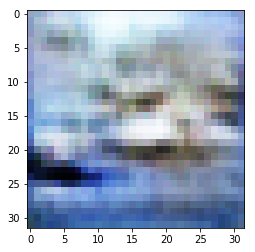

Epoch: [ 2 / 5 ],  Step: [ 570 / 781 ], D_loss:  1.1404815 , G_loss:  1.6590827
Epoch: [ 2 / 5 ],  Step: [ 571 / 781 ], D_loss:  1.0803933 , G_loss:  0.9930149
Epoch: [ 2 / 5 ],  Step: [ 572 / 781 ], D_loss:  0.9953778 , G_loss:  1.3718135
Epoch: [ 2 / 5 ],  Step: [ 573 / 781 ], D_loss:  1.050038 , G_loss:  1.2421662
Epoch: [ 2 / 5 ],  Step: [ 574 / 781 ], D_loss:  1.0871732 , G_loss:  1.1396892
Epoch: [ 2 / 5 ],  Step: [ 575 / 781 ], D_loss:  1.2995607 , G_loss:  1.7405298
Epoch: [ 2 / 5 ],  Step: [ 576 / 781 ], D_loss:  1.2743808 , G_loss:  1.4598678
Epoch: [ 2 / 5 ],  Step: [ 577 / 781 ], D_loss:  1.2959925 , G_loss:  1.2860837
Epoch: [ 2 / 5 ],  Step: [ 578 / 781 ], D_loss:  0.9917097 , G_loss:  1.1013039
Epoch: [ 2 / 5 ],  Step: [ 579 / 781 ], D_loss:  0.9611921 , G_loss:  1.2742434
(196, 32, 32, 3)


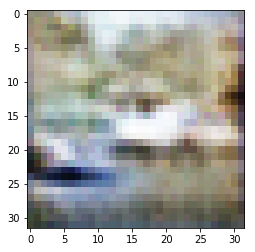

Epoch: [ 2 / 5 ],  Step: [ 580 / 781 ], D_loss:  0.8213293 , G_loss:  1.2382023
Epoch: [ 2 / 5 ],  Step: [ 581 / 781 ], D_loss:  0.6779906 , G_loss:  1.2055987
Epoch: [ 2 / 5 ],  Step: [ 582 / 781 ], D_loss:  0.638921 , G_loss:  1.3489256
Epoch: [ 2 / 5 ],  Step: [ 583 / 781 ], D_loss:  0.6941469 , G_loss:  1.3032464
Epoch: [ 2 / 5 ],  Step: [ 584 / 781 ], D_loss:  0.74276996 , G_loss:  1.1582077
Epoch: [ 2 / 5 ],  Step: [ 585 / 781 ], D_loss:  0.8496227 , G_loss:  1.3253694
Epoch: [ 2 / 5 ],  Step: [ 586 / 781 ], D_loss:  0.6964315 , G_loss:  1.1330729
Epoch: [ 2 / 5 ],  Step: [ 587 / 781 ], D_loss:  0.8596961 , G_loss:  1.2247074
Epoch: [ 2 / 5 ],  Step: [ 588 / 781 ], D_loss:  0.7657603 , G_loss:  1.0954229
Epoch: [ 2 / 5 ],  Step: [ 589 / 781 ], D_loss:  0.6988195 , G_loss:  1.2741969
(196, 32, 32, 3)


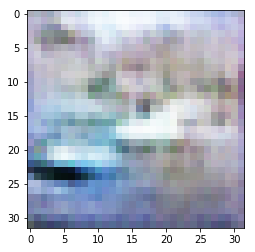

Epoch: [ 2 / 5 ],  Step: [ 590 / 781 ], D_loss:  0.7502424 , G_loss:  1.1598979
Epoch: [ 2 / 5 ],  Step: [ 591 / 781 ], D_loss:  0.7637162 , G_loss:  0.9790334
Epoch: [ 2 / 5 ],  Step: [ 592 / 781 ], D_loss:  0.79885674 , G_loss:  1.2695054
Epoch: [ 2 / 5 ],  Step: [ 593 / 781 ], D_loss:  0.85829544 , G_loss:  1.3058596
Epoch: [ 2 / 5 ],  Step: [ 594 / 781 ], D_loss:  0.792436 , G_loss:  1.1977284
Epoch: [ 2 / 5 ],  Step: [ 595 / 781 ], D_loss:  1.0949218 , G_loss:  1.4378251
Epoch: [ 2 / 5 ],  Step: [ 596 / 781 ], D_loss:  0.89679193 , G_loss:  1.3733493
Epoch: [ 2 / 5 ],  Step: [ 597 / 781 ], D_loss:  1.005071 , G_loss:  1.2949865
Epoch: [ 2 / 5 ],  Step: [ 598 / 781 ], D_loss:  0.8212484 , G_loss:  1.5455803
Epoch: [ 2 / 5 ],  Step: [ 599 / 781 ], D_loss:  0.74030876 , G_loss:  1.2839041
(196, 32, 32, 3)


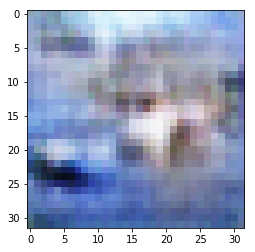

Epoch: [ 2 / 5 ],  Step: [ 600 / 781 ], D_loss:  0.6867451 , G_loss:  1.152467
Epoch: [ 2 / 5 ],  Step: [ 601 / 781 ], D_loss:  0.65355766 , G_loss:  1.3666575
Epoch: [ 2 / 5 ],  Step: [ 602 / 781 ], D_loss:  0.6732287 , G_loss:  1.1267056
Epoch: [ 2 / 5 ],  Step: [ 603 / 781 ], D_loss:  0.6416351 , G_loss:  1.1456828
Epoch: [ 2 / 5 ],  Step: [ 604 / 781 ], D_loss:  0.5520131 , G_loss:  1.2827907
Epoch: [ 2 / 5 ],  Step: [ 605 / 781 ], D_loss:  0.5634548 , G_loss:  1.1969508
Epoch: [ 2 / 5 ],  Step: [ 606 / 781 ], D_loss:  0.68698525 , G_loss:  1.1005183
Epoch: [ 2 / 5 ],  Step: [ 607 / 781 ], D_loss:  0.7216519 , G_loss:  1.1625721
Epoch: [ 2 / 5 ],  Step: [ 608 / 781 ], D_loss:  0.7576831 , G_loss:  1.4368347
Epoch: [ 2 / 5 ],  Step: [ 609 / 781 ], D_loss:  0.75385183 , G_loss:  1.276032
(196, 32, 32, 3)


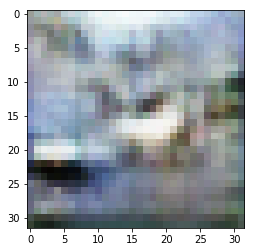

Epoch: [ 2 / 5 ],  Step: [ 610 / 781 ], D_loss:  0.74792147 , G_loss:  1.0017622
Epoch: [ 2 / 5 ],  Step: [ 611 / 781 ], D_loss:  0.7343098 , G_loss:  1.352407
Epoch: [ 2 / 5 ],  Step: [ 612 / 781 ], D_loss:  0.84304124 , G_loss:  1.0764968
Epoch: [ 2 / 5 ],  Step: [ 613 / 781 ], D_loss:  0.70957756 , G_loss:  1.1557076
Epoch: [ 2 / 5 ],  Step: [ 614 / 781 ], D_loss:  0.73265576 , G_loss:  1.1003217
Epoch: [ 2 / 5 ],  Step: [ 615 / 781 ], D_loss:  0.8539689 , G_loss:  0.99805486
Epoch: [ 2 / 5 ],  Step: [ 616 / 781 ], D_loss:  0.7592304 , G_loss:  1.1923898
Epoch: [ 2 / 5 ],  Step: [ 617 / 781 ], D_loss:  0.7771898 , G_loss:  1.0461469
Epoch: [ 2 / 5 ],  Step: [ 618 / 781 ], D_loss:  0.7639941 , G_loss:  1.0418507
Epoch: [ 2 / 5 ],  Step: [ 619 / 781 ], D_loss:  0.71646684 , G_loss:  1.1500928
(196, 32, 32, 3)


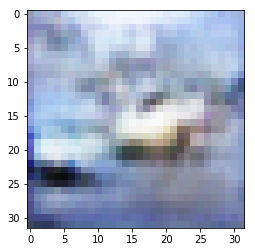

Epoch: [ 2 / 5 ],  Step: [ 620 / 781 ], D_loss:  0.82862365 , G_loss:  0.9025913
Epoch: [ 2 / 5 ],  Step: [ 621 / 781 ], D_loss:  1.0956453 , G_loss:  1.4505101
Epoch: [ 2 / 5 ],  Step: [ 622 / 781 ], D_loss:  0.9469389 , G_loss:  1.3492768
Epoch: [ 2 / 5 ],  Step: [ 623 / 781 ], D_loss:  0.8219996 , G_loss:  1.0516889
Epoch: [ 2 / 5 ],  Step: [ 624 / 781 ], D_loss:  0.8833724 , G_loss:  1.3008639
Epoch: [ 2 / 5 ],  Step: [ 625 / 781 ], D_loss:  0.8987343 , G_loss:  1.1157182
Epoch: [ 2 / 5 ],  Step: [ 626 / 781 ], D_loss:  0.9498141 , G_loss:  0.9275352
Epoch: [ 2 / 5 ],  Step: [ 627 / 781 ], D_loss:  0.9927727 , G_loss:  1.738902
Epoch: [ 2 / 5 ],  Step: [ 628 / 781 ], D_loss:  1.0086209 , G_loss:  1.3526834
Epoch: [ 2 / 5 ],  Step: [ 629 / 781 ], D_loss:  0.9347478 , G_loss:  0.94063723
(196, 32, 32, 3)


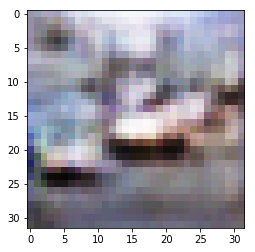

Epoch: [ 2 / 5 ],  Step: [ 630 / 781 ], D_loss:  1.0889148 , G_loss:  1.4938408
Epoch: [ 2 / 5 ],  Step: [ 631 / 781 ], D_loss:  0.9519414 , G_loss:  1.1454954
Epoch: [ 2 / 5 ],  Step: [ 632 / 781 ], D_loss:  0.96402 , G_loss:  1.2973828
Epoch: [ 2 / 5 ],  Step: [ 633 / 781 ], D_loss:  0.9467538 , G_loss:  1.1598175
Epoch: [ 2 / 5 ],  Step: [ 634 / 781 ], D_loss:  0.7994422 , G_loss:  1.2465105
Epoch: [ 2 / 5 ],  Step: [ 635 / 781 ], D_loss:  0.8153641 , G_loss:  1.0633994
Epoch: [ 2 / 5 ],  Step: [ 636 / 781 ], D_loss:  0.95663416 , G_loss:  1.7215962
Epoch: [ 2 / 5 ],  Step: [ 637 / 781 ], D_loss:  1.1990546 , G_loss:  1.5837405
Epoch: [ 2 / 5 ],  Step: [ 638 / 781 ], D_loss:  1.1565926 , G_loss:  1.2437375
Epoch: [ 2 / 5 ],  Step: [ 639 / 781 ], D_loss:  0.9858649 , G_loss:  1.3755918
(196, 32, 32, 3)


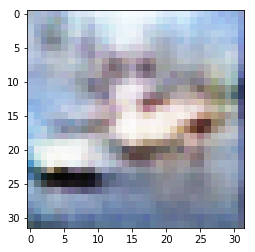

Epoch: [ 2 / 5 ],  Step: [ 640 / 781 ], D_loss:  0.95229465 , G_loss:  1.2850472
Epoch: [ 2 / 5 ],  Step: [ 641 / 781 ], D_loss:  0.6868775 , G_loss:  1.0498998
Epoch: [ 2 / 5 ],  Step: [ 642 / 781 ], D_loss:  0.97764677 , G_loss:  1.4541489
Epoch: [ 2 / 5 ],  Step: [ 643 / 781 ], D_loss:  0.9316157 , G_loss:  1.480796
Epoch: [ 2 / 5 ],  Step: [ 644 / 781 ], D_loss:  0.737168 , G_loss:  1.2078178
Epoch: [ 2 / 5 ],  Step: [ 645 / 781 ], D_loss:  0.73990977 , G_loss:  1.2279775
Epoch: [ 2 / 5 ],  Step: [ 646 / 781 ], D_loss:  0.9057616 , G_loss:  1.2469752
Epoch: [ 2 / 5 ],  Step: [ 647 / 781 ], D_loss:  0.8205549 , G_loss:  1.1981938
Epoch: [ 2 / 5 ],  Step: [ 648 / 781 ], D_loss:  0.85690236 , G_loss:  1.0562856
Epoch: [ 2 / 5 ],  Step: [ 649 / 781 ], D_loss:  1.0260057 , G_loss:  1.4023185
(196, 32, 32, 3)


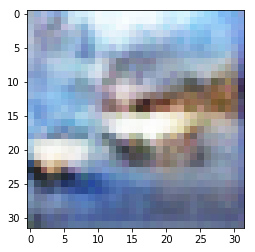

Epoch: [ 2 / 5 ],  Step: [ 650 / 781 ], D_loss:  0.87362224 , G_loss:  1.3878498
Epoch: [ 2 / 5 ],  Step: [ 651 / 781 ], D_loss:  0.72731185 , G_loss:  1.1510338
Epoch: [ 2 / 5 ],  Step: [ 652 / 781 ], D_loss:  0.6518469 , G_loss:  1.4433225
Epoch: [ 2 / 5 ],  Step: [ 653 / 781 ], D_loss:  0.65661293 , G_loss:  1.2681627
Epoch: [ 2 / 5 ],  Step: [ 654 / 781 ], D_loss:  0.7120053 , G_loss:  1.0280976
Epoch: [ 2 / 5 ],  Step: [ 655 / 781 ], D_loss:  0.9777324 , G_loss:  1.8076488
Epoch: [ 2 / 5 ],  Step: [ 656 / 781 ], D_loss:  1.329805 , G_loss:  1.8352284
Epoch: [ 2 / 5 ],  Step: [ 657 / 781 ], D_loss:  1.1484568 , G_loss:  1.3387085
Epoch: [ 2 / 5 ],  Step: [ 658 / 781 ], D_loss:  0.9629905 , G_loss:  0.98731863
Epoch: [ 2 / 5 ],  Step: [ 659 / 781 ], D_loss:  0.8954359 , G_loss:  1.54217
(196, 32, 32, 3)


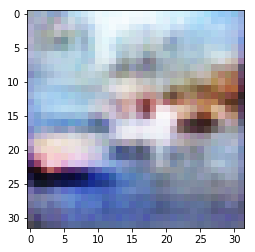

Epoch: [ 2 / 5 ],  Step: [ 660 / 781 ], D_loss:  0.8452941 , G_loss:  1.2995217
Epoch: [ 2 / 5 ],  Step: [ 661 / 781 ], D_loss:  0.8403077 , G_loss:  1.1096286
Epoch: [ 2 / 5 ],  Step: [ 662 / 781 ], D_loss:  0.85309935 , G_loss:  1.3670783
Epoch: [ 2 / 5 ],  Step: [ 663 / 781 ], D_loss:  0.66703725 , G_loss:  1.2279704
Epoch: [ 2 / 5 ],  Step: [ 664 / 781 ], D_loss:  0.810883 , G_loss:  1.0761632
Epoch: [ 2 / 5 ],  Step: [ 665 / 781 ], D_loss:  0.72410023 , G_loss:  1.0753887
Epoch: [ 2 / 5 ],  Step: [ 666 / 781 ], D_loss:  0.77111864 , G_loss:  1.0560654
Epoch: [ 2 / 5 ],  Step: [ 667 / 781 ], D_loss:  0.9384133 , G_loss:  1.3452604
Epoch: [ 2 / 5 ],  Step: [ 668 / 781 ], D_loss:  0.8017861 , G_loss:  1.1863523
Epoch: [ 2 / 5 ],  Step: [ 669 / 781 ], D_loss:  0.7560403 , G_loss:  1.0779747
(196, 32, 32, 3)


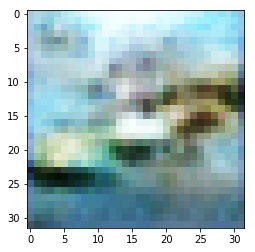

Epoch: [ 2 / 5 ],  Step: [ 670 / 781 ], D_loss:  0.7495335 , G_loss:  0.96628475
Epoch: [ 2 / 5 ],  Step: [ 671 / 781 ], D_loss:  0.824595 , G_loss:  1.3107337
Epoch: [ 2 / 5 ],  Step: [ 672 / 781 ], D_loss:  0.90081465 , G_loss:  1.1631773
Epoch: [ 2 / 5 ],  Step: [ 673 / 781 ], D_loss:  0.91642845 , G_loss:  1.1938896
Epoch: [ 2 / 5 ],  Step: [ 674 / 781 ], D_loss:  0.9535598 , G_loss:  1.2096084
Epoch: [ 2 / 5 ],  Step: [ 675 / 781 ], D_loss:  0.7346252 , G_loss:  1.0543188
Epoch: [ 2 / 5 ],  Step: [ 676 / 781 ], D_loss:  0.8761737 , G_loss:  1.5689738
Epoch: [ 2 / 5 ],  Step: [ 677 / 781 ], D_loss:  0.92398375 , G_loss:  1.1246619
Epoch: [ 2 / 5 ],  Step: [ 678 / 781 ], D_loss:  0.864839 , G_loss:  0.9167275
Epoch: [ 2 / 5 ],  Step: [ 679 / 781 ], D_loss:  1.4538996 , G_loss:  2.1098015
(196, 32, 32, 3)


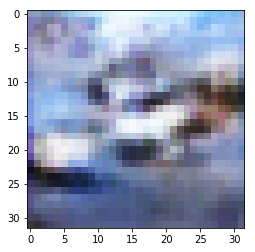

Epoch: [ 2 / 5 ],  Step: [ 680 / 781 ], D_loss:  1.4224359 , G_loss:  1.3347077
Epoch: [ 2 / 5 ],  Step: [ 681 / 781 ], D_loss:  1.2061477 , G_loss:  1.2249905
Epoch: [ 2 / 5 ],  Step: [ 682 / 781 ], D_loss:  1.0923944 , G_loss:  1.2062428
Epoch: [ 2 / 5 ],  Step: [ 683 / 781 ], D_loss:  1.0302849 , G_loss:  1.1164757
Epoch: [ 2 / 5 ],  Step: [ 684 / 781 ], D_loss:  1.0862958 , G_loss:  1.1733326
Epoch: [ 2 / 5 ],  Step: [ 685 / 781 ], D_loss:  1.2717274 , G_loss:  1.1823323
Epoch: [ 2 / 5 ],  Step: [ 686 / 781 ], D_loss:  1.1574786 , G_loss:  1.5153576
Epoch: [ 2 / 5 ],  Step: [ 687 / 781 ], D_loss:  1.2915299 , G_loss:  1.365884
Epoch: [ 2 / 5 ],  Step: [ 688 / 781 ], D_loss:  1.3241155 , G_loss:  1.2811235
Epoch: [ 2 / 5 ],  Step: [ 689 / 781 ], D_loss:  1.0455742 , G_loss:  1.10366
(196, 32, 32, 3)


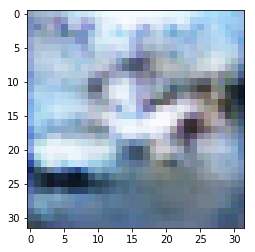

Epoch: [ 2 / 5 ],  Step: [ 690 / 781 ], D_loss:  1.0229234 , G_loss:  1.1279773
Epoch: [ 2 / 5 ],  Step: [ 691 / 781 ], D_loss:  0.9649221 , G_loss:  0.8651271
Epoch: [ 2 / 5 ],  Step: [ 692 / 781 ], D_loss:  0.98851585 , G_loss:  1.8407507
Epoch: [ 2 / 5 ],  Step: [ 693 / 781 ], D_loss:  1.1878729 , G_loss:  1.5317354
Epoch: [ 2 / 5 ],  Step: [ 694 / 781 ], D_loss:  1.0417907 , G_loss:  0.9964862
Epoch: [ 2 / 5 ],  Step: [ 695 / 781 ], D_loss:  1.2608128 , G_loss:  1.2065781
Epoch: [ 2 / 5 ],  Step: [ 696 / 781 ], D_loss:  1.1869034 , G_loss:  1.4135447
Epoch: [ 2 / 5 ],  Step: [ 697 / 781 ], D_loss:  0.8725428 , G_loss:  1.2981989
Epoch: [ 2 / 5 ],  Step: [ 698 / 781 ], D_loss:  0.86792755 , G_loss:  0.9683632
Epoch: [ 2 / 5 ],  Step: [ 699 / 781 ], D_loss:  1.0428454 , G_loss:  1.6544282
(196, 32, 32, 3)


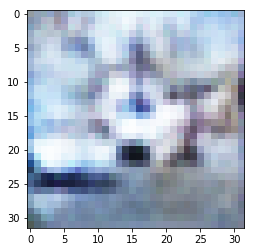

Epoch: [ 2 / 5 ],  Step: [ 700 / 781 ], D_loss:  0.8643979 , G_loss:  1.405124
Epoch: [ 2 / 5 ],  Step: [ 701 / 781 ], D_loss:  0.8442324 , G_loss:  1.191499
Epoch: [ 2 / 5 ],  Step: [ 702 / 781 ], D_loss:  0.8547482 , G_loss:  1.2647054
Epoch: [ 2 / 5 ],  Step: [ 703 / 781 ], D_loss:  0.64530987 , G_loss:  1.1273942
Epoch: [ 2 / 5 ],  Step: [ 704 / 781 ], D_loss:  0.6980314 , G_loss:  1.3741485
Epoch: [ 2 / 5 ],  Step: [ 705 / 781 ], D_loss:  0.85509074 , G_loss:  1.456805
Epoch: [ 2 / 5 ],  Step: [ 706 / 781 ], D_loss:  0.9689364 , G_loss:  0.9693929
Epoch: [ 2 / 5 ],  Step: [ 707 / 781 ], D_loss:  1.1011984 , G_loss:  1.470302
Epoch: [ 2 / 5 ],  Step: [ 708 / 781 ], D_loss:  0.78516185 , G_loss:  1.310753
Epoch: [ 2 / 5 ],  Step: [ 709 / 781 ], D_loss:  0.88319236 , G_loss:  1.2476255
(196, 32, 32, 3)


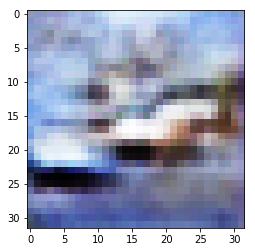

Epoch: [ 2 / 5 ],  Step: [ 710 / 781 ], D_loss:  0.7956221 , G_loss:  1.2543638
Epoch: [ 2 / 5 ],  Step: [ 711 / 781 ], D_loss:  0.6955082 , G_loss:  1.1319827
Epoch: [ 2 / 5 ],  Step: [ 712 / 781 ], D_loss:  0.7577023 , G_loss:  1.2557286
Epoch: [ 2 / 5 ],  Step: [ 713 / 781 ], D_loss:  0.64552754 , G_loss:  1.1116037
Epoch: [ 2 / 5 ],  Step: [ 714 / 781 ], D_loss:  0.77049994 , G_loss:  1.0502336
Epoch: [ 2 / 5 ],  Step: [ 715 / 781 ], D_loss:  0.8146442 , G_loss:  1.4201914
Epoch: [ 2 / 5 ],  Step: [ 716 / 781 ], D_loss:  0.7272562 , G_loss:  1.323376
Epoch: [ 2 / 5 ],  Step: [ 717 / 781 ], D_loss:  0.6136657 , G_loss:  1.0208489
Epoch: [ 2 / 5 ],  Step: [ 718 / 781 ], D_loss:  0.76111305 , G_loss:  1.1548924
Epoch: [ 2 / 5 ],  Step: [ 719 / 781 ], D_loss:  0.9173858 , G_loss:  1.178473
(196, 32, 32, 3)


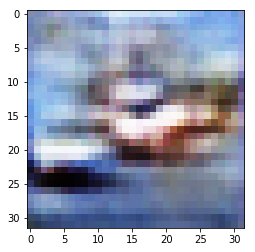

Epoch: [ 2 / 5 ],  Step: [ 720 / 781 ], D_loss:  0.81752425 , G_loss:  1.2181448
Epoch: [ 2 / 5 ],  Step: [ 721 / 781 ], D_loss:  0.6958154 , G_loss:  1.1144243
Epoch: [ 2 / 5 ],  Step: [ 722 / 781 ], D_loss:  0.7166837 , G_loss:  1.097975
Epoch: [ 2 / 5 ],  Step: [ 723 / 781 ], D_loss:  0.9373839 , G_loss:  1.2253349
Epoch: [ 2 / 5 ],  Step: [ 724 / 781 ], D_loss:  0.936742 , G_loss:  1.2630154
Epoch: [ 2 / 5 ],  Step: [ 725 / 781 ], D_loss:  0.76843214 , G_loss:  0.86462474
Epoch: [ 2 / 5 ],  Step: [ 726 / 781 ], D_loss:  0.9425222 , G_loss:  1.3329809
Epoch: [ 2 / 5 ],  Step: [ 727 / 781 ], D_loss:  0.66818297 , G_loss:  1.3098493
Epoch: [ 2 / 5 ],  Step: [ 728 / 781 ], D_loss:  0.73317885 , G_loss:  1.0191861
Epoch: [ 2 / 5 ],  Step: [ 729 / 781 ], D_loss:  0.6759254 , G_loss:  1.2732887
(196, 32, 32, 3)


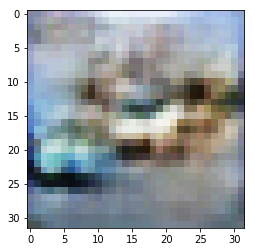

Epoch: [ 2 / 5 ],  Step: [ 730 / 781 ], D_loss:  0.71015 , G_loss:  1.114577
Epoch: [ 2 / 5 ],  Step: [ 731 / 781 ], D_loss:  0.80476594 , G_loss:  1.1106379
Epoch: [ 2 / 5 ],  Step: [ 732 / 781 ], D_loss:  0.732259 , G_loss:  1.1758846
Epoch: [ 2 / 5 ],  Step: [ 733 / 781 ], D_loss:  0.7086379 , G_loss:  1.0559748
Epoch: [ 2 / 5 ],  Step: [ 734 / 781 ], D_loss:  0.73305184 , G_loss:  1.1104269
Epoch: [ 2 / 5 ],  Step: [ 735 / 781 ], D_loss:  0.63366616 , G_loss:  1.2455301
Epoch: [ 2 / 5 ],  Step: [ 736 / 781 ], D_loss:  0.7663821 , G_loss:  1.0334913
Epoch: [ 2 / 5 ],  Step: [ 737 / 781 ], D_loss:  0.8650438 , G_loss:  1.3563921
Epoch: [ 2 / 5 ],  Step: [ 738 / 781 ], D_loss:  0.7355759 , G_loss:  1.0776808
Epoch: [ 2 / 5 ],  Step: [ 739 / 781 ], D_loss:  0.7184277 , G_loss:  1.035167
(196, 32, 32, 3)


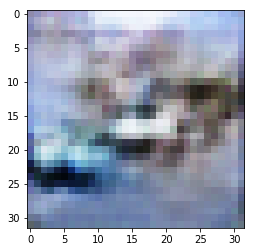

Epoch: [ 2 / 5 ],  Step: [ 740 / 781 ], D_loss:  0.76938826 , G_loss:  1.396357
Epoch: [ 2 / 5 ],  Step: [ 741 / 781 ], D_loss:  0.87986326 , G_loss:  0.97484887
Epoch: [ 2 / 5 ],  Step: [ 742 / 781 ], D_loss:  0.9328103 , G_loss:  1.3917613
Epoch: [ 2 / 5 ],  Step: [ 743 / 781 ], D_loss:  0.9562973 , G_loss:  1.4659812
Epoch: [ 2 / 5 ],  Step: [ 744 / 781 ], D_loss:  1.037673 , G_loss:  1.0654589
Epoch: [ 2 / 5 ],  Step: [ 745 / 781 ], D_loss:  1.028543 , G_loss:  1.0782008
Epoch: [ 2 / 5 ],  Step: [ 746 / 781 ], D_loss:  0.7870446 , G_loss:  1.2339331
Epoch: [ 2 / 5 ],  Step: [ 747 / 781 ], D_loss:  0.7012569 , G_loss:  1.1683047
Epoch: [ 2 / 5 ],  Step: [ 748 / 781 ], D_loss:  0.83022875 , G_loss:  1.0948036
Epoch: [ 2 / 5 ],  Step: [ 749 / 781 ], D_loss:  0.71830004 , G_loss:  1.0092896
(196, 32, 32, 3)


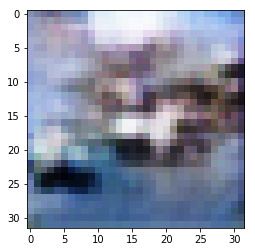

Epoch: [ 2 / 5 ],  Step: [ 750 / 781 ], D_loss:  0.77708805 , G_loss:  1.8296762
Epoch: [ 2 / 5 ],  Step: [ 751 / 781 ], D_loss:  1.0476738 , G_loss:  1.2636048
Epoch: [ 2 / 5 ],  Step: [ 752 / 781 ], D_loss:  0.98437244 , G_loss:  1.2632816
Epoch: [ 2 / 5 ],  Step: [ 753 / 781 ], D_loss:  0.8199236 , G_loss:  1.2320291
Epoch: [ 2 / 5 ],  Step: [ 754 / 781 ], D_loss:  0.75645626 , G_loss:  1.56703
Epoch: [ 2 / 5 ],  Step: [ 755 / 781 ], D_loss:  0.9278694 , G_loss:  1.1681509
Epoch: [ 2 / 5 ],  Step: [ 756 / 781 ], D_loss:  0.6839285 , G_loss:  1.0865598
Epoch: [ 2 / 5 ],  Step: [ 757 / 781 ], D_loss:  0.77765864 , G_loss:  1.2974131
Epoch: [ 2 / 5 ],  Step: [ 758 / 781 ], D_loss:  0.7388786 , G_loss:  1.0580587
Epoch: [ 2 / 5 ],  Step: [ 759 / 781 ], D_loss:  0.85214937 , G_loss:  1.1635244
(196, 32, 32, 3)


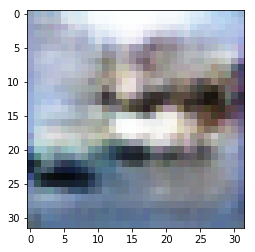

Epoch: [ 2 / 5 ],  Step: [ 760 / 781 ], D_loss:  0.6396097 , G_loss:  1.260113
Epoch: [ 2 / 5 ],  Step: [ 761 / 781 ], D_loss:  0.88989204 , G_loss:  1.0502211
Epoch: [ 2 / 5 ],  Step: [ 762 / 781 ], D_loss:  0.78469115 , G_loss:  1.3671184
Epoch: [ 2 / 5 ],  Step: [ 763 / 781 ], D_loss:  0.8089079 , G_loss:  1.1397641
Epoch: [ 2 / 5 ],  Step: [ 764 / 781 ], D_loss:  0.8871719 , G_loss:  1.4370222
Epoch: [ 2 / 5 ],  Step: [ 765 / 781 ], D_loss:  0.7541717 , G_loss:  1.1184808
Epoch: [ 2 / 5 ],  Step: [ 766 / 781 ], D_loss:  0.8183363 , G_loss:  1.2906535
Epoch: [ 2 / 5 ],  Step: [ 767 / 781 ], D_loss:  0.81215894 , G_loss:  1.1877288
Epoch: [ 2 / 5 ],  Step: [ 768 / 781 ], D_loss:  0.6678981 , G_loss:  1.1342912
Epoch: [ 2 / 5 ],  Step: [ 769 / 781 ], D_loss:  0.7541779 , G_loss:  1.2184726
(196, 32, 32, 3)


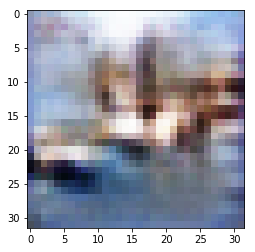

Epoch: [ 2 / 5 ],  Step: [ 770 / 781 ], D_loss:  0.83704746 , G_loss:  1.2108648
Epoch: [ 2 / 5 ],  Step: [ 771 / 781 ], D_loss:  0.8500472 , G_loss:  1.1638718
Epoch: [ 2 / 5 ],  Step: [ 772 / 781 ], D_loss:  0.9006102 , G_loss:  1.7466682
Epoch: [ 2 / 5 ],  Step: [ 773 / 781 ], D_loss:  0.79927796 , G_loss:  1.6360059
Epoch: [ 2 / 5 ],  Step: [ 774 / 781 ], D_loss:  0.6056006 , G_loss:  1.2333544
Epoch: [ 2 / 5 ],  Step: [ 775 / 781 ], D_loss:  0.63269097 , G_loss:  1.2961278
Epoch: [ 2 / 5 ],  Step: [ 776 / 781 ], D_loss:  0.7252766 , G_loss:  1.6309984
Epoch: [ 2 / 5 ],  Step: [ 777 / 781 ], D_loss:  0.7048969 , G_loss:  1.3114427
Epoch: [ 2 / 5 ],  Step: [ 778 / 781 ], D_loss:  0.8769019 , G_loss:  1.0253025
Epoch: [ 2 / 5 ],  Step: [ 779 / 781 ], D_loss:  0.81551075 , G_loss:  1.7202322
(196, 32, 32, 3)


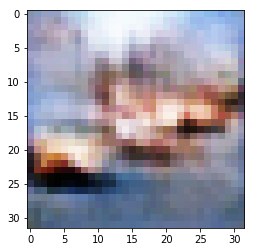

Epoch: [ 2 / 5 ],  Step: [ 780 / 781 ], D_loss:  1.0614693 , G_loss:  1.4324317
Epoch: [ 3 / 5 ],  Step: [ 0 / 781 ], D_loss:  0.90876013 , G_loss:  0.9349806
(196, 32, 32, 3)


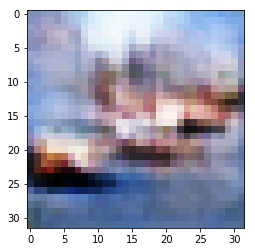

Epoch: [ 3 / 5 ],  Step: [ 1 / 781 ], D_loss:  1.0258267 , G_loss:  1.4611013
Epoch: [ 3 / 5 ],  Step: [ 2 / 781 ], D_loss:  0.96985054 , G_loss:  1.3188503
Epoch: [ 3 / 5 ],  Step: [ 3 / 781 ], D_loss:  0.63802356 , G_loss:  0.9615167
Epoch: [ 3 / 5 ],  Step: [ 4 / 781 ], D_loss:  0.96429145 , G_loss:  1.6292534
Epoch: [ 3 / 5 ],  Step: [ 5 / 781 ], D_loss:  0.85157484 , G_loss:  1.3545845
Epoch: [ 3 / 5 ],  Step: [ 6 / 781 ], D_loss:  0.9508064 , G_loss:  1.2951643
Epoch: [ 3 / 5 ],  Step: [ 7 / 781 ], D_loss:  0.756389 , G_loss:  1.3635063
Epoch: [ 3 / 5 ],  Step: [ 8 / 781 ], D_loss:  0.9079255 , G_loss:  1.4164912
Epoch: [ 3 / 5 ],  Step: [ 9 / 781 ], D_loss:  0.69189674 , G_loss:  0.95908946
(196, 32, 32, 3)


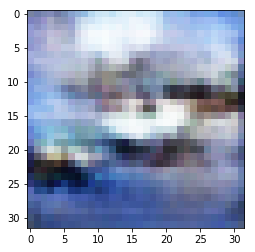

Epoch: [ 3 / 5 ],  Step: [ 10 / 781 ], D_loss:  0.80012226 , G_loss:  1.2454956
Epoch: [ 3 / 5 ],  Step: [ 11 / 781 ], D_loss:  0.8185887 , G_loss:  1.282218
Epoch: [ 3 / 5 ],  Step: [ 12 / 781 ], D_loss:  0.70671785 , G_loss:  1.2487617
Epoch: [ 3 / 5 ],  Step: [ 13 / 781 ], D_loss:  0.77401435 , G_loss:  1.0416577
Epoch: [ 3 / 5 ],  Step: [ 14 / 781 ], D_loss:  0.84053767 , G_loss:  1.5072494
Epoch: [ 3 / 5 ],  Step: [ 15 / 781 ], D_loss:  0.6973069 , G_loss:  1.3495431
Epoch: [ 3 / 5 ],  Step: [ 16 / 781 ], D_loss:  0.81261784 , G_loss:  1.293607
Epoch: [ 3 / 5 ],  Step: [ 17 / 781 ], D_loss:  0.74931866 , G_loss:  1.2182016
Epoch: [ 3 / 5 ],  Step: [ 18 / 781 ], D_loss:  0.71194744 , G_loss:  1.2959605
Epoch: [ 3 / 5 ],  Step: [ 19 / 781 ], D_loss:  0.67841524 , G_loss:  0.93928796
(196, 32, 32, 3)


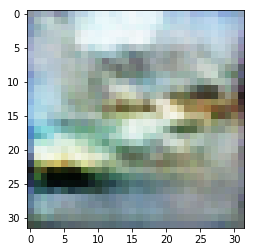

Epoch: [ 3 / 5 ],  Step: [ 20 / 781 ], D_loss:  0.883556 , G_loss:  1.8442212
Epoch: [ 3 / 5 ],  Step: [ 21 / 781 ], D_loss:  1.0502131 , G_loss:  1.2928579
Epoch: [ 3 / 5 ],  Step: [ 22 / 781 ], D_loss:  0.99547213 , G_loss:  1.5581979
Epoch: [ 3 / 5 ],  Step: [ 23 / 781 ], D_loss:  0.8640381 , G_loss:  1.0230945
Epoch: [ 3 / 5 ],  Step: [ 24 / 781 ], D_loss:  1.0269413 , G_loss:  1.9304965
Epoch: [ 3 / 5 ],  Step: [ 25 / 781 ], D_loss:  1.0447706 , G_loss:  1.6045058
Epoch: [ 3 / 5 ],  Step: [ 26 / 781 ], D_loss:  0.8582491 , G_loss:  1.2607461
Epoch: [ 3 / 5 ],  Step: [ 27 / 781 ], D_loss:  1.131192 , G_loss:  1.5898844
Epoch: [ 3 / 5 ],  Step: [ 28 / 781 ], D_loss:  0.97079897 , G_loss:  1.4122143
Epoch: [ 3 / 5 ],  Step: [ 29 / 781 ], D_loss:  0.7297793 , G_loss:  1.4198939
(196, 32, 32, 3)


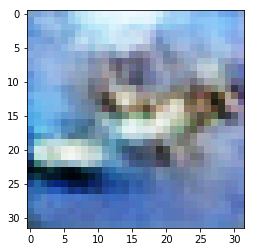

Epoch: [ 3 / 5 ],  Step: [ 30 / 781 ], D_loss:  0.75492203 , G_loss:  1.581541
Epoch: [ 3 / 5 ],  Step: [ 31 / 781 ], D_loss:  0.69035965 , G_loss:  1.2836888
Epoch: [ 3 / 5 ],  Step: [ 32 / 781 ], D_loss:  0.90283805 , G_loss:  1.5357028
Epoch: [ 3 / 5 ],  Step: [ 33 / 781 ], D_loss:  0.77019346 , G_loss:  1.4505849
Epoch: [ 3 / 5 ],  Step: [ 34 / 781 ], D_loss:  0.9858568 , G_loss:  1.0896891
Epoch: [ 3 / 5 ],  Step: [ 35 / 781 ], D_loss:  0.81466335 , G_loss:  1.031987
Epoch: [ 3 / 5 ],  Step: [ 36 / 781 ], D_loss:  1.089559 , G_loss:  1.7249724
Epoch: [ 3 / 5 ],  Step: [ 37 / 781 ], D_loss:  1.0061265 , G_loss:  1.4925747
Epoch: [ 3 / 5 ],  Step: [ 38 / 781 ], D_loss:  0.8732595 , G_loss:  1.4217905
Epoch: [ 3 / 5 ],  Step: [ 39 / 781 ], D_loss:  0.722376 , G_loss:  1.2199407
(196, 32, 32, 3)


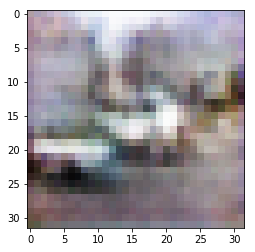

Epoch: [ 3 / 5 ],  Step: [ 40 / 781 ], D_loss:  0.76215124 , G_loss:  1.7720377
Epoch: [ 3 / 5 ],  Step: [ 41 / 781 ], D_loss:  0.6814503 , G_loss:  1.5100406
Epoch: [ 3 / 5 ],  Step: [ 42 / 781 ], D_loss:  0.7294487 , G_loss:  1.1827636
Epoch: [ 3 / 5 ],  Step: [ 43 / 781 ], D_loss:  0.79893744 , G_loss:  1.3064964
Epoch: [ 3 / 5 ],  Step: [ 44 / 781 ], D_loss:  0.70893747 , G_loss:  1.3838148
Epoch: [ 3 / 5 ],  Step: [ 45 / 781 ], D_loss:  0.808867 , G_loss:  1.1251214
Epoch: [ 3 / 5 ],  Step: [ 46 / 781 ], D_loss:  0.92978877 , G_loss:  1.6090995
Epoch: [ 3 / 5 ],  Step: [ 47 / 781 ], D_loss:  0.8114411 , G_loss:  1.3019286
Epoch: [ 3 / 5 ],  Step: [ 48 / 781 ], D_loss:  0.8977778 , G_loss:  1.1368892
Epoch: [ 3 / 5 ],  Step: [ 49 / 781 ], D_loss:  1.0274633 , G_loss:  1.1324081
(196, 32, 32, 3)


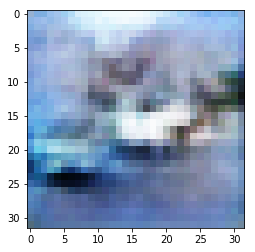

Epoch: [ 3 / 5 ],  Step: [ 50 / 781 ], D_loss:  0.7256384 , G_loss:  1.210294
Epoch: [ 3 / 5 ],  Step: [ 51 / 781 ], D_loss:  0.7677691 , G_loss:  1.2282788
Epoch: [ 3 / 5 ],  Step: [ 52 / 781 ], D_loss:  0.6264695 , G_loss:  1.1881402
Epoch: [ 3 / 5 ],  Step: [ 53 / 781 ], D_loss:  0.8435485 , G_loss:  1.1548276
Epoch: [ 3 / 5 ],  Step: [ 54 / 781 ], D_loss:  0.76148415 , G_loss:  1.5144315
Epoch: [ 3 / 5 ],  Step: [ 55 / 781 ], D_loss:  0.5970291 , G_loss:  1.195205
Epoch: [ 3 / 5 ],  Step: [ 56 / 781 ], D_loss:  0.87017894 , G_loss:  0.81005436
Epoch: [ 3 / 5 ],  Step: [ 57 / 781 ], D_loss:  1.2986598 , G_loss:  1.7408224
Epoch: [ 3 / 5 ],  Step: [ 58 / 781 ], D_loss:  1.1518152 , G_loss:  0.9764219
Epoch: [ 3 / 5 ],  Step: [ 59 / 781 ], D_loss:  1.2787057 , G_loss:  2.2469814
(196, 32, 32, 3)


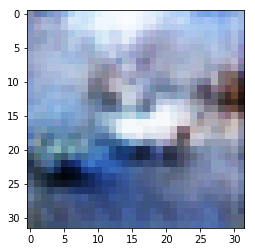

Epoch: [ 3 / 5 ],  Step: [ 60 / 781 ], D_loss:  1.7630879 , G_loss:  1.8467418
Epoch: [ 3 / 5 ],  Step: [ 61 / 781 ], D_loss:  1.6342326 , G_loss:  1.0840192
Epoch: [ 3 / 5 ],  Step: [ 62 / 781 ], D_loss:  1.8094821 , G_loss:  1.8829966
Epoch: [ 3 / 5 ],  Step: [ 63 / 781 ], D_loss:  1.7311139 , G_loss:  1.6824151
Epoch: [ 3 / 5 ],  Step: [ 64 / 781 ], D_loss:  1.5868267 , G_loss:  1.7197418
Epoch: [ 3 / 5 ],  Step: [ 65 / 781 ], D_loss:  1.3749619 , G_loss:  1.2264528
Epoch: [ 3 / 5 ],  Step: [ 66 / 781 ], D_loss:  1.1653843 , G_loss:  0.78104275
Epoch: [ 3 / 5 ],  Step: [ 67 / 781 ], D_loss:  1.6050485 , G_loss:  2.4367168
Epoch: [ 3 / 5 ],  Step: [ 68 / 781 ], D_loss:  1.5776985 , G_loss:  2.267194
Epoch: [ 3 / 5 ],  Step: [ 69 / 781 ], D_loss:  1.5862257 , G_loss:  1.5402269
(196, 32, 32, 3)


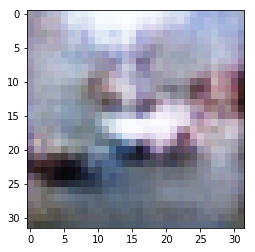

Epoch: [ 3 / 5 ],  Step: [ 70 / 781 ], D_loss:  1.1568373 , G_loss:  0.9421277
Epoch: [ 3 / 5 ],  Step: [ 71 / 781 ], D_loss:  1.6489189 , G_loss:  1.7332451
Epoch: [ 3 / 5 ],  Step: [ 72 / 781 ], D_loss:  1.3616817 , G_loss:  1.7317641
Epoch: [ 3 / 5 ],  Step: [ 73 / 781 ], D_loss:  1.3979055 , G_loss:  1.4300209
Epoch: [ 3 / 5 ],  Step: [ 74 / 781 ], D_loss:  1.4686345 , G_loss:  1.2463471
Epoch: [ 3 / 5 ],  Step: [ 75 / 781 ], D_loss:  1.2579556 , G_loss:  1.2352579
Epoch: [ 3 / 5 ],  Step: [ 76 / 781 ], D_loss:  1.3282665 , G_loss:  1.3370643
Epoch: [ 3 / 5 ],  Step: [ 77 / 781 ], D_loss:  1.0191791 , G_loss:  1.1030529
Epoch: [ 3 / 5 ],  Step: [ 78 / 781 ], D_loss:  1.0442622 , G_loss:  1.0621852
Epoch: [ 3 / 5 ],  Step: [ 79 / 781 ], D_loss:  1.1137738 , G_loss:  1.3506176
(196, 32, 32, 3)


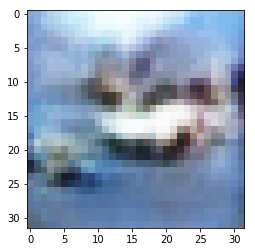

Epoch: [ 3 / 5 ],  Step: [ 80 / 781 ], D_loss:  1.0865225 , G_loss:  1.2260607
Epoch: [ 3 / 5 ],  Step: [ 81 / 781 ], D_loss:  0.98095226 , G_loss:  1.0731808
Epoch: [ 3 / 5 ],  Step: [ 82 / 781 ], D_loss:  1.1445913 , G_loss:  1.4730616
Epoch: [ 3 / 5 ],  Step: [ 83 / 781 ], D_loss:  1.1377027 , G_loss:  1.3777153
Epoch: [ 3 / 5 ],  Step: [ 84 / 781 ], D_loss:  0.9811655 , G_loss:  1.1145468
Epoch: [ 3 / 5 ],  Step: [ 85 / 781 ], D_loss:  1.141223 , G_loss:  1.3906109
Epoch: [ 3 / 5 ],  Step: [ 86 / 781 ], D_loss:  0.8494188 , G_loss:  1.2964606
Epoch: [ 3 / 5 ],  Step: [ 87 / 781 ], D_loss:  0.8601154 , G_loss:  1.070377
Epoch: [ 3 / 5 ],  Step: [ 88 / 781 ], D_loss:  1.0346098 , G_loss:  1.3763953
Epoch: [ 3 / 5 ],  Step: [ 89 / 781 ], D_loss:  0.8536907 , G_loss:  1.1122084
(196, 32, 32, 3)


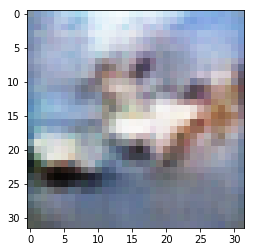

Epoch: [ 3 / 5 ],  Step: [ 90 / 781 ], D_loss:  0.99620634 , G_loss:  1.295965
Epoch: [ 3 / 5 ],  Step: [ 91 / 781 ], D_loss:  0.9473739 , G_loss:  1.1703242
Epoch: [ 3 / 5 ],  Step: [ 92 / 781 ], D_loss:  0.9479925 , G_loss:  1.0166314
Epoch: [ 3 / 5 ],  Step: [ 93 / 781 ], D_loss:  0.85925657 , G_loss:  1.3605621
Epoch: [ 3 / 5 ],  Step: [ 94 / 781 ], D_loss:  1.0695599 , G_loss:  1.1582048
Epoch: [ 3 / 5 ],  Step: [ 95 / 781 ], D_loss:  0.9367715 , G_loss:  1.1983951
Epoch: [ 3 / 5 ],  Step: [ 96 / 781 ], D_loss:  1.0058074 , G_loss:  1.0232474
Epoch: [ 3 / 5 ],  Step: [ 97 / 781 ], D_loss:  0.8293424 , G_loss:  1.4552059
Epoch: [ 3 / 5 ],  Step: [ 98 / 781 ], D_loss:  0.9090465 , G_loss:  1.1952208
Epoch: [ 3 / 5 ],  Step: [ 99 / 781 ], D_loss:  0.864429 , G_loss:  0.89068675
(196, 32, 32, 3)


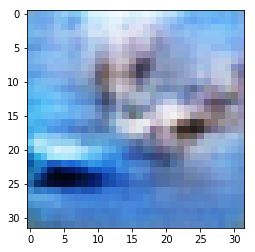

Epoch: [ 3 / 5 ],  Step: [ 100 / 781 ], D_loss:  1.0409782 , G_loss:  1.7178695
Epoch: [ 3 / 5 ],  Step: [ 101 / 781 ], D_loss:  1.0524913 , G_loss:  1.4204323
Epoch: [ 3 / 5 ],  Step: [ 102 / 781 ], D_loss:  0.89074194 , G_loss:  0.6984518
Epoch: [ 3 / 5 ],  Step: [ 103 / 781 ], D_loss:  1.5747672 , G_loss:  2.450445
Epoch: [ 3 / 5 ],  Step: [ 104 / 781 ], D_loss:  1.5646963 , G_loss:  1.8753386
Epoch: [ 3 / 5 ],  Step: [ 105 / 781 ], D_loss:  1.1535344 , G_loss:  1.0447371
Epoch: [ 3 / 5 ],  Step: [ 106 / 781 ], D_loss:  1.4392263 , G_loss:  1.3139522
Epoch: [ 3 / 5 ],  Step: [ 107 / 781 ], D_loss:  1.2996123 , G_loss:  1.2842243
Epoch: [ 3 / 5 ],  Step: [ 108 / 781 ], D_loss:  1.2784915 , G_loss:  1.406124
Epoch: [ 3 / 5 ],  Step: [ 109 / 781 ], D_loss:  1.0629411 , G_loss:  1.1181937
(196, 32, 32, 3)


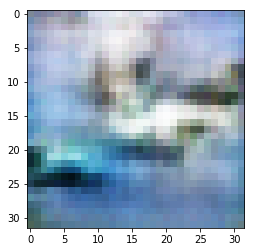

Epoch: [ 3 / 5 ],  Step: [ 110 / 781 ], D_loss:  1.1484473 , G_loss:  1.305683
Epoch: [ 3 / 5 ],  Step: [ 111 / 781 ], D_loss:  1.105053 , G_loss:  1.1344991
Epoch: [ 3 / 5 ],  Step: [ 112 / 781 ], D_loss:  1.0214895 , G_loss:  0.9851756
Epoch: [ 3 / 5 ],  Step: [ 113 / 781 ], D_loss:  0.9482947 , G_loss:  1.1055481
Epoch: [ 3 / 5 ],  Step: [ 114 / 781 ], D_loss:  0.8264241 , G_loss:  1.1257962
Epoch: [ 3 / 5 ],  Step: [ 115 / 781 ], D_loss:  0.88811797 , G_loss:  1.0889562
Epoch: [ 3 / 5 ],  Step: [ 116 / 781 ], D_loss:  0.9324987 , G_loss:  0.9543342
Epoch: [ 3 / 5 ],  Step: [ 117 / 781 ], D_loss:  0.8951112 , G_loss:  1.2813877
Epoch: [ 3 / 5 ],  Step: [ 118 / 781 ], D_loss:  0.8986319 , G_loss:  1.2690206
Epoch: [ 3 / 5 ],  Step: [ 119 / 781 ], D_loss:  0.8542788 , G_loss:  1.1242934
(196, 32, 32, 3)


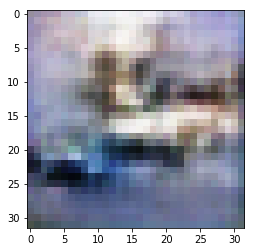

Epoch: [ 3 / 5 ],  Step: [ 120 / 781 ], D_loss:  0.812515 , G_loss:  1.1438632
Epoch: [ 3 / 5 ],  Step: [ 121 / 781 ], D_loss:  0.7106205 , G_loss:  1.2424355
Epoch: [ 3 / 5 ],  Step: [ 122 / 781 ], D_loss:  0.857342 , G_loss:  1.2028002
Epoch: [ 3 / 5 ],  Step: [ 123 / 781 ], D_loss:  0.9071869 , G_loss:  1.023745
Epoch: [ 3 / 5 ],  Step: [ 124 / 781 ], D_loss:  1.0760269 , G_loss:  1.6133683
Epoch: [ 3 / 5 ],  Step: [ 125 / 781 ], D_loss:  1.0773451 , G_loss:  1.5482514
Epoch: [ 3 / 5 ],  Step: [ 126 / 781 ], D_loss:  0.9726444 , G_loss:  1.2979143
Epoch: [ 3 / 5 ],  Step: [ 127 / 781 ], D_loss:  0.86956304 , G_loss:  1.0576063
Epoch: [ 3 / 5 ],  Step: [ 128 / 781 ], D_loss:  0.91602814 , G_loss:  1.5212082
Epoch: [ 3 / 5 ],  Step: [ 129 / 781 ], D_loss:  0.98096514 , G_loss:  1.3649609
(196, 32, 32, 3)


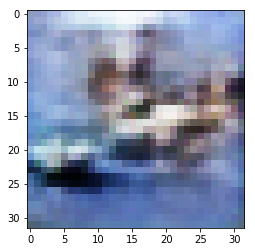

Epoch: [ 3 / 5 ],  Step: [ 130 / 781 ], D_loss:  0.8298708 , G_loss:  1.2217617
Epoch: [ 3 / 5 ],  Step: [ 131 / 781 ], D_loss:  1.0159855 , G_loss:  1.2276187
Epoch: [ 3 / 5 ],  Step: [ 132 / 781 ], D_loss:  0.7615522 , G_loss:  1.3018285
Epoch: [ 3 / 5 ],  Step: [ 133 / 781 ], D_loss:  0.773973 , G_loss:  1.2637659
Epoch: [ 3 / 5 ],  Step: [ 134 / 781 ], D_loss:  0.8407424 , G_loss:  1.1014276
Epoch: [ 3 / 5 ],  Step: [ 135 / 781 ], D_loss:  0.72705144 , G_loss:  1.4322013
Epoch: [ 3 / 5 ],  Step: [ 136 / 781 ], D_loss:  0.68604153 , G_loss:  1.3452569
Epoch: [ 3 / 5 ],  Step: [ 137 / 781 ], D_loss:  0.7998626 , G_loss:  1.0608597
Epoch: [ 3 / 5 ],  Step: [ 138 / 781 ], D_loss:  0.779558 , G_loss:  1.0604478
Epoch: [ 3 / 5 ],  Step: [ 139 / 781 ], D_loss:  0.7702172 , G_loss:  1.2460799
(196, 32, 32, 3)


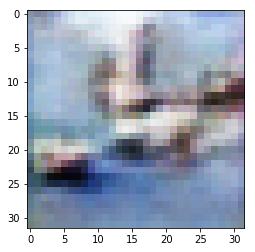

Epoch: [ 3 / 5 ],  Step: [ 140 / 781 ], D_loss:  0.85294116 , G_loss:  0.8881203
Epoch: [ 3 / 5 ],  Step: [ 141 / 781 ], D_loss:  0.91773295 , G_loss:  1.4573054
Epoch: [ 3 / 5 ],  Step: [ 142 / 781 ], D_loss:  1.024087 , G_loss:  1.2573073
Epoch: [ 3 / 5 ],  Step: [ 143 / 781 ], D_loss:  0.9293101 , G_loss:  0.9278977
Epoch: [ 3 / 5 ],  Step: [ 144 / 781 ], D_loss:  1.1825534 , G_loss:  1.4795918
Epoch: [ 3 / 5 ],  Step: [ 145 / 781 ], D_loss:  0.99383736 , G_loss:  1.3266164
Epoch: [ 3 / 5 ],  Step: [ 146 / 781 ], D_loss:  0.91419727 , G_loss:  1.3017524
Epoch: [ 3 / 5 ],  Step: [ 147 / 781 ], D_loss:  0.95438015 , G_loss:  1.2219055
Epoch: [ 3 / 5 ],  Step: [ 148 / 781 ], D_loss:  0.8351065 , G_loss:  1.0948117
Epoch: [ 3 / 5 ],  Step: [ 149 / 781 ], D_loss:  0.77723986 , G_loss:  1.1008577
(196, 32, 32, 3)


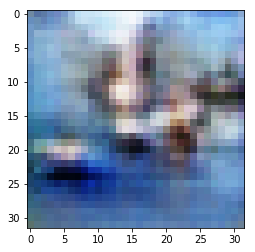

Epoch: [ 3 / 5 ],  Step: [ 150 / 781 ], D_loss:  0.6907925 , G_loss:  1.0252509
Epoch: [ 3 / 5 ],  Step: [ 151 / 781 ], D_loss:  0.705602 , G_loss:  0.91896445
Epoch: [ 3 / 5 ],  Step: [ 152 / 781 ], D_loss:  1.0063992 , G_loss:  1.5288523
Epoch: [ 3 / 5 ],  Step: [ 153 / 781 ], D_loss:  1.0620584 , G_loss:  1.3167546
Epoch: [ 3 / 5 ],  Step: [ 154 / 781 ], D_loss:  0.7867994 , G_loss:  0.9873047
Epoch: [ 3 / 5 ],  Step: [ 155 / 781 ], D_loss:  0.9833294 , G_loss:  1.5000228
Epoch: [ 3 / 5 ],  Step: [ 156 / 781 ], D_loss:  0.8756319 , G_loss:  1.3130046
Epoch: [ 3 / 5 ],  Step: [ 157 / 781 ], D_loss:  0.7073796 , G_loss:  1.2161697
Epoch: [ 3 / 5 ],  Step: [ 158 / 781 ], D_loss:  0.6979499 , G_loss:  1.141601
Epoch: [ 3 / 5 ],  Step: [ 159 / 781 ], D_loss:  0.710729 , G_loss:  1.1617998
(196, 32, 32, 3)


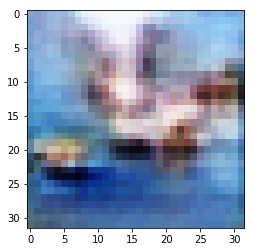

Epoch: [ 3 / 5 ],  Step: [ 160 / 781 ], D_loss:  0.821308 , G_loss:  1.2756376
Epoch: [ 3 / 5 ],  Step: [ 161 / 781 ], D_loss:  0.8363095 , G_loss:  1.1132498
Epoch: [ 3 / 5 ],  Step: [ 162 / 781 ], D_loss:  0.7300011 , G_loss:  1.1396863
Epoch: [ 3 / 5 ],  Step: [ 163 / 781 ], D_loss:  0.82203734 , G_loss:  0.941734
Epoch: [ 3 / 5 ],  Step: [ 164 / 781 ], D_loss:  0.89948 , G_loss:  1.0974038
Epoch: [ 3 / 5 ],  Step: [ 165 / 781 ], D_loss:  0.8876081 , G_loss:  1.0532656
Epoch: [ 3 / 5 ],  Step: [ 166 / 781 ], D_loss:  0.8148892 , G_loss:  0.7451443
Epoch: [ 3 / 5 ],  Step: [ 167 / 781 ], D_loss:  1.1533942 , G_loss:  1.8784996
Epoch: [ 3 / 5 ],  Step: [ 168 / 781 ], D_loss:  1.070526 , G_loss:  1.8240954
Epoch: [ 3 / 5 ],  Step: [ 169 / 781 ], D_loss:  1.0663229 , G_loss:  1.2537993
(196, 32, 32, 3)


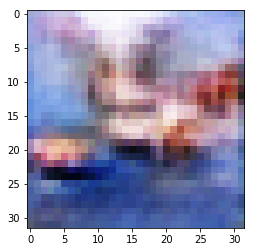

Epoch: [ 3 / 5 ],  Step: [ 170 / 781 ], D_loss:  1.0574356 , G_loss:  1.0377413
Epoch: [ 3 / 5 ],  Step: [ 171 / 781 ], D_loss:  1.2080655 , G_loss:  2.0820081
Epoch: [ 3 / 5 ],  Step: [ 172 / 781 ], D_loss:  1.217191 , G_loss:  1.5565267
Epoch: [ 3 / 5 ],  Step: [ 173 / 781 ], D_loss:  1.2445165 , G_loss:  1.0673757
Epoch: [ 3 / 5 ],  Step: [ 174 / 781 ], D_loss:  1.1478802 , G_loss:  1.4558227
Epoch: [ 3 / 5 ],  Step: [ 175 / 781 ], D_loss:  1.1034881 , G_loss:  1.3105966
Epoch: [ 3 / 5 ],  Step: [ 176 / 781 ], D_loss:  1.0448396 , G_loss:  1.1171539
Epoch: [ 3 / 5 ],  Step: [ 177 / 781 ], D_loss:  0.96124196 , G_loss:  1.1670663
Epoch: [ 3 / 5 ],  Step: [ 178 / 781 ], D_loss:  1.002821 , G_loss:  1.4258193
Epoch: [ 3 / 5 ],  Step: [ 179 / 781 ], D_loss:  0.99199605 , G_loss:  1.2611923
(196, 32, 32, 3)


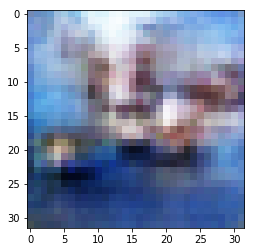

Epoch: [ 3 / 5 ],  Step: [ 180 / 781 ], D_loss:  0.8161232 , G_loss:  1.1270387
Epoch: [ 3 / 5 ],  Step: [ 181 / 781 ], D_loss:  0.8669043 , G_loss:  1.1040033
Epoch: [ 3 / 5 ],  Step: [ 182 / 781 ], D_loss:  0.85446125 , G_loss:  1.2780163
Epoch: [ 3 / 5 ],  Step: [ 183 / 781 ], D_loss:  0.66151583 , G_loss:  1.1804227
Epoch: [ 3 / 5 ],  Step: [ 184 / 781 ], D_loss:  0.7322071 , G_loss:  1.3114256
Epoch: [ 3 / 5 ],  Step: [ 185 / 781 ], D_loss:  0.9218728 , G_loss:  1.0124872
Epoch: [ 3 / 5 ],  Step: [ 186 / 781 ], D_loss:  0.9605226 , G_loss:  1.356284
Epoch: [ 3 / 5 ],  Step: [ 187 / 781 ], D_loss:  0.98252773 , G_loss:  1.1872915
Epoch: [ 3 / 5 ],  Step: [ 188 / 781 ], D_loss:  0.91241455 , G_loss:  1.4201804
Epoch: [ 3 / 5 ],  Step: [ 189 / 781 ], D_loss:  0.84080905 , G_loss:  1.1472845
(196, 32, 32, 3)


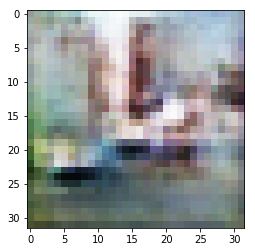

Epoch: [ 3 / 5 ],  Step: [ 190 / 781 ], D_loss:  0.6327721 , G_loss:  1.3800175
Epoch: [ 3 / 5 ],  Step: [ 191 / 781 ], D_loss:  0.53782654 , G_loss:  1.3702836
Epoch: [ 3 / 5 ],  Step: [ 192 / 781 ], D_loss:  0.70981985 , G_loss:  1.0864317
Epoch: [ 3 / 5 ],  Step: [ 193 / 781 ], D_loss:  0.64421916 , G_loss:  1.2078483
Epoch: [ 3 / 5 ],  Step: [ 194 / 781 ], D_loss:  0.78635776 , G_loss:  1.4822093
Epoch: [ 3 / 5 ],  Step: [ 195 / 781 ], D_loss:  0.5889297 , G_loss:  1.3949738
Epoch: [ 3 / 5 ],  Step: [ 196 / 781 ], D_loss:  1.0067238 , G_loss:  1.0307603
Epoch: [ 3 / 5 ],  Step: [ 197 / 781 ], D_loss:  0.8352759 , G_loss:  1.3671842
Epoch: [ 3 / 5 ],  Step: [ 198 / 781 ], D_loss:  0.8569318 , G_loss:  1.1574581
Epoch: [ 3 / 5 ],  Step: [ 199 / 781 ], D_loss:  0.7246015 , G_loss:  1.2214633
(196, 32, 32, 3)


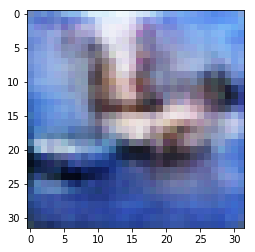

Epoch: [ 3 / 5 ],  Step: [ 200 / 781 ], D_loss:  0.81504536 , G_loss:  1.1691648
Epoch: [ 3 / 5 ],  Step: [ 201 / 781 ], D_loss:  1.006942 , G_loss:  1.3616853
Epoch: [ 3 / 5 ],  Step: [ 202 / 781 ], D_loss:  0.774952 , G_loss:  1.3756528
Epoch: [ 3 / 5 ],  Step: [ 203 / 781 ], D_loss:  0.69603455 , G_loss:  1.1912761
Epoch: [ 3 / 5 ],  Step: [ 204 / 781 ], D_loss:  0.75809777 , G_loss:  1.3406312
Epoch: [ 3 / 5 ],  Step: [ 205 / 781 ], D_loss:  0.732746 , G_loss:  1.329031
Epoch: [ 3 / 5 ],  Step: [ 206 / 781 ], D_loss:  0.6913221 , G_loss:  1.3176025
Epoch: [ 3 / 5 ],  Step: [ 207 / 781 ], D_loss:  0.67459023 , G_loss:  1.1483052
Epoch: [ 3 / 5 ],  Step: [ 208 / 781 ], D_loss:  0.8452664 , G_loss:  1.4783642
Epoch: [ 3 / 5 ],  Step: [ 209 / 781 ], D_loss:  0.9289674 , G_loss:  1.3724573
(196, 32, 32, 3)


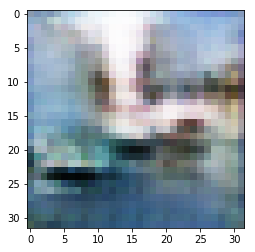

Epoch: [ 3 / 5 ],  Step: [ 210 / 781 ], D_loss:  0.85967284 , G_loss:  1.0562158
Epoch: [ 3 / 5 ],  Step: [ 211 / 781 ], D_loss:  1.076656 , G_loss:  1.4605485
Epoch: [ 3 / 5 ],  Step: [ 212 / 781 ], D_loss:  1.1245389 , G_loss:  1.5586612
Epoch: [ 3 / 5 ],  Step: [ 213 / 781 ], D_loss:  0.9779271 , G_loss:  1.245891
Epoch: [ 3 / 5 ],  Step: [ 214 / 781 ], D_loss:  0.97817713 , G_loss:  1.1396838
Epoch: [ 3 / 5 ],  Step: [ 215 / 781 ], D_loss:  0.9528705 , G_loss:  0.996953
Epoch: [ 3 / 5 ],  Step: [ 216 / 781 ], D_loss:  0.78829336 , G_loss:  1.4920995
Epoch: [ 3 / 5 ],  Step: [ 217 / 781 ], D_loss:  0.918911 , G_loss:  1.1854626
Epoch: [ 3 / 5 ],  Step: [ 218 / 781 ], D_loss:  0.8631533 , G_loss:  0.8566576
Epoch: [ 3 / 5 ],  Step: [ 219 / 781 ], D_loss:  0.79021645 , G_loss:  1.4423648
(196, 32, 32, 3)


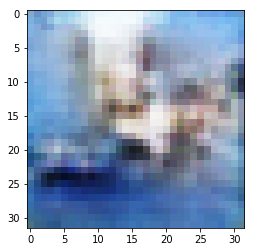

Epoch: [ 3 / 5 ],  Step: [ 220 / 781 ], D_loss:  0.92861843 , G_loss:  1.1943407
Epoch: [ 3 / 5 ],  Step: [ 221 / 781 ], D_loss:  0.95715994 , G_loss:  1.1722536
Epoch: [ 3 / 5 ],  Step: [ 222 / 781 ], D_loss:  0.8090594 , G_loss:  1.147576
Epoch: [ 3 / 5 ],  Step: [ 223 / 781 ], D_loss:  0.8137099 , G_loss:  1.0667653
Epoch: [ 3 / 5 ],  Step: [ 224 / 781 ], D_loss:  0.8153087 , G_loss:  1.6205391
Epoch: [ 3 / 5 ],  Step: [ 225 / 781 ], D_loss:  0.90610015 , G_loss:  1.4207056
Epoch: [ 3 / 5 ],  Step: [ 226 / 781 ], D_loss:  0.83806175 , G_loss:  1.106153
Epoch: [ 3 / 5 ],  Step: [ 227 / 781 ], D_loss:  0.83069855 , G_loss:  1.4421438
Epoch: [ 3 / 5 ],  Step: [ 228 / 781 ], D_loss:  0.98558676 , G_loss:  1.1705947
Epoch: [ 3 / 5 ],  Step: [ 229 / 781 ], D_loss:  0.8342569 , G_loss:  1.1382924
(196, 32, 32, 3)


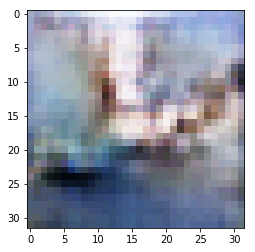

Epoch: [ 3 / 5 ],  Step: [ 230 / 781 ], D_loss:  0.77912605 , G_loss:  1.363914
Epoch: [ 3 / 5 ],  Step: [ 231 / 781 ], D_loss:  0.93242246 , G_loss:  1.1552459
Epoch: [ 3 / 5 ],  Step: [ 232 / 781 ], D_loss:  0.70172477 , G_loss:  1.356943
Epoch: [ 3 / 5 ],  Step: [ 233 / 781 ], D_loss:  0.84192824 , G_loss:  1.0303077
Epoch: [ 3 / 5 ],  Step: [ 234 / 781 ], D_loss:  0.80609107 , G_loss:  1.2421498
Epoch: [ 3 / 5 ],  Step: [ 235 / 781 ], D_loss:  0.7350505 , G_loss:  1.0663242
Epoch: [ 3 / 5 ],  Step: [ 236 / 781 ], D_loss:  0.78751343 , G_loss:  1.2784219
Epoch: [ 3 / 5 ],  Step: [ 237 / 781 ], D_loss:  0.66463333 , G_loss:  1.1768444
Epoch: [ 3 / 5 ],  Step: [ 238 / 781 ], D_loss:  0.64593995 , G_loss:  1.0868508
Epoch: [ 3 / 5 ],  Step: [ 239 / 781 ], D_loss:  0.7164442 , G_loss:  1.1896536
(196, 32, 32, 3)


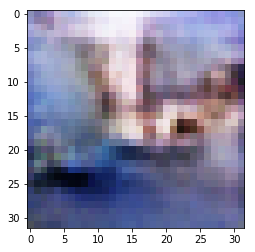

Epoch: [ 3 / 5 ],  Step: [ 240 / 781 ], D_loss:  0.717711 , G_loss:  1.0525911
Epoch: [ 3 / 5 ],  Step: [ 241 / 781 ], D_loss:  0.7068006 , G_loss:  1.1246064
Epoch: [ 3 / 5 ],  Step: [ 242 / 781 ], D_loss:  0.66019154 , G_loss:  1.2048645
Epoch: [ 3 / 5 ],  Step: [ 243 / 781 ], D_loss:  0.7931081 , G_loss:  1.0496755
Epoch: [ 3 / 5 ],  Step: [ 244 / 781 ], D_loss:  0.7354493 , G_loss:  1.1755477
Epoch: [ 3 / 5 ],  Step: [ 245 / 781 ], D_loss:  0.6194784 , G_loss:  1.3210195
Epoch: [ 3 / 5 ],  Step: [ 246 / 781 ], D_loss:  0.82215315 , G_loss:  1.0364437
Epoch: [ 3 / 5 ],  Step: [ 247 / 781 ], D_loss:  0.90692866 , G_loss:  1.1836104
Epoch: [ 3 / 5 ],  Step: [ 248 / 781 ], D_loss:  1.012614 , G_loss:  1.2653997
Epoch: [ 3 / 5 ],  Step: [ 249 / 781 ], D_loss:  0.91387385 , G_loss:  0.9337268
(196, 32, 32, 3)


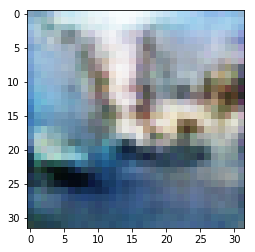

Epoch: [ 3 / 5 ],  Step: [ 250 / 781 ], D_loss:  1.1045327 , G_loss:  1.8096672
Epoch: [ 3 / 5 ],  Step: [ 251 / 781 ], D_loss:  1.1724285 , G_loss:  1.4391608
Epoch: [ 3 / 5 ],  Step: [ 252 / 781 ], D_loss:  0.8793888 , G_loss:  0.7685571
Epoch: [ 3 / 5 ],  Step: [ 253 / 781 ], D_loss:  1.1522502 , G_loss:  1.9336092
Epoch: [ 3 / 5 ],  Step: [ 254 / 781 ], D_loss:  1.3823518 , G_loss:  1.7166189
Epoch: [ 3 / 5 ],  Step: [ 255 / 781 ], D_loss:  1.3127856 , G_loss:  1.2718959
Epoch: [ 3 / 5 ],  Step: [ 256 / 781 ], D_loss:  1.148395 , G_loss:  1.1876397
Epoch: [ 3 / 5 ],  Step: [ 257 / 781 ], D_loss:  1.0748091 , G_loss:  1.072187
Epoch: [ 3 / 5 ],  Step: [ 258 / 781 ], D_loss:  0.98265815 , G_loss:  1.0798451
Epoch: [ 3 / 5 ],  Step: [ 259 / 781 ], D_loss:  1.1442906 , G_loss:  1.5034156
(196, 32, 32, 3)


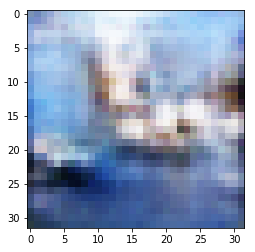

Epoch: [ 3 / 5 ],  Step: [ 260 / 781 ], D_loss:  0.900072 , G_loss:  1.3116897
Epoch: [ 3 / 5 ],  Step: [ 261 / 781 ], D_loss:  0.94457054 , G_loss:  1.2024208
Epoch: [ 3 / 5 ],  Step: [ 262 / 781 ], D_loss:  0.9056973 , G_loss:  1.1155002
Epoch: [ 3 / 5 ],  Step: [ 263 / 781 ], D_loss:  0.8471247 , G_loss:  1.3930674
Epoch: [ 3 / 5 ],  Step: [ 264 / 781 ], D_loss:  0.981781 , G_loss:  1.2749183
Epoch: [ 3 / 5 ],  Step: [ 265 / 781 ], D_loss:  0.93788254 , G_loss:  1.2305875
Epoch: [ 3 / 5 ],  Step: [ 266 / 781 ], D_loss:  1.0433468 , G_loss:  1.395901
Epoch: [ 3 / 5 ],  Step: [ 267 / 781 ], D_loss:  0.73805195 , G_loss:  1.1211244
Epoch: [ 3 / 5 ],  Step: [ 268 / 781 ], D_loss:  0.8838226 , G_loss:  1.3581209
Epoch: [ 3 / 5 ],  Step: [ 269 / 781 ], D_loss:  0.88098776 , G_loss:  1.4308598
(196, 32, 32, 3)


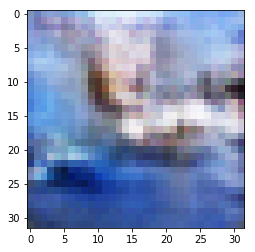

Epoch: [ 3 / 5 ],  Step: [ 270 / 781 ], D_loss:  0.7622001 , G_loss:  1.1468325
Epoch: [ 3 / 5 ],  Step: [ 271 / 781 ], D_loss:  0.7103831 , G_loss:  1.1645861
Epoch: [ 3 / 5 ],  Step: [ 272 / 781 ], D_loss:  0.76657736 , G_loss:  1.201715
Epoch: [ 3 / 5 ],  Step: [ 273 / 781 ], D_loss:  0.6795983 , G_loss:  1.0877951
Epoch: [ 3 / 5 ],  Step: [ 274 / 781 ], D_loss:  0.8804213 , G_loss:  1.4636139
Epoch: [ 3 / 5 ],  Step: [ 275 / 781 ], D_loss:  0.9613215 , G_loss:  1.2477523
Epoch: [ 3 / 5 ],  Step: [ 276 / 781 ], D_loss:  0.73082805 , G_loss:  1.1661961
Epoch: [ 3 / 5 ],  Step: [ 277 / 781 ], D_loss:  0.78767955 , G_loss:  1.3751183
Epoch: [ 3 / 5 ],  Step: [ 278 / 781 ], D_loss:  0.72426736 , G_loss:  1.2302238
Epoch: [ 3 / 5 ],  Step: [ 279 / 781 ], D_loss:  0.5604495 , G_loss:  1.0883442
(196, 32, 32, 3)


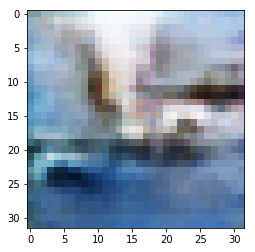

Epoch: [ 3 / 5 ],  Step: [ 280 / 781 ], D_loss:  0.7463017 , G_loss:  1.3771715
Epoch: [ 3 / 5 ],  Step: [ 281 / 781 ], D_loss:  0.6044441 , G_loss:  1.2595118
Epoch: [ 3 / 5 ],  Step: [ 282 / 781 ], D_loss:  0.6311855 , G_loss:  0.9267552
Epoch: [ 3 / 5 ],  Step: [ 283 / 781 ], D_loss:  0.68490446 , G_loss:  1.3892848
Epoch: [ 3 / 5 ],  Step: [ 284 / 781 ], D_loss:  0.6304216 , G_loss:  1.213986
Epoch: [ 3 / 5 ],  Step: [ 285 / 781 ], D_loss:  0.70746857 , G_loss:  0.88071555
Epoch: [ 3 / 5 ],  Step: [ 286 / 781 ], D_loss:  0.6164959 , G_loss:  1.1625072
Epoch: [ 3 / 5 ],  Step: [ 287 / 781 ], D_loss:  0.6909916 , G_loss:  1.2674508
Epoch: [ 3 / 5 ],  Step: [ 288 / 781 ], D_loss:  0.5789683 , G_loss:  1.0799772
Epoch: [ 3 / 5 ],  Step: [ 289 / 781 ], D_loss:  0.6020509 , G_loss:  1.3407365
(196, 32, 32, 3)


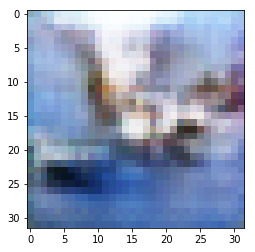

Epoch: [ 3 / 5 ],  Step: [ 290 / 781 ], D_loss:  0.53045845 , G_loss:  1.2956398
Epoch: [ 3 / 5 ],  Step: [ 291 / 781 ], D_loss:  0.62395215 , G_loss:  1.0316538
Epoch: [ 3 / 5 ],  Step: [ 292 / 781 ], D_loss:  0.81089264 , G_loss:  1.6198533
Epoch: [ 3 / 5 ],  Step: [ 293 / 781 ], D_loss:  0.8164172 , G_loss:  1.3610742
Epoch: [ 3 / 5 ],  Step: [ 294 / 781 ], D_loss:  0.69761646 , G_loss:  1.1163558
Epoch: [ 3 / 5 ],  Step: [ 295 / 781 ], D_loss:  0.81996316 , G_loss:  1.6929939
Epoch: [ 3 / 5 ],  Step: [ 296 / 781 ], D_loss:  0.84456867 , G_loss:  1.4619671
Epoch: [ 3 / 5 ],  Step: [ 297 / 781 ], D_loss:  0.7980398 , G_loss:  1.1144286
Epoch: [ 3 / 5 ],  Step: [ 298 / 781 ], D_loss:  0.6799098 , G_loss:  1.2442892
Epoch: [ 3 / 5 ],  Step: [ 299 / 781 ], D_loss:  1.0643675 , G_loss:  1.6708679
(196, 32, 32, 3)


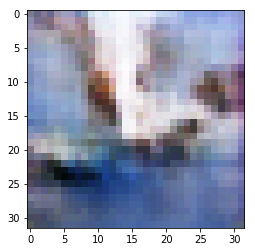

Epoch: [ 3 / 5 ],  Step: [ 300 / 781 ], D_loss:  0.94255054 , G_loss:  1.5857048
Epoch: [ 3 / 5 ],  Step: [ 301 / 781 ], D_loss:  0.8087413 , G_loss:  1.2592307
Epoch: [ 3 / 5 ],  Step: [ 302 / 781 ], D_loss:  0.8740916 , G_loss:  1.5884236
Epoch: [ 3 / 5 ],  Step: [ 303 / 781 ], D_loss:  0.81593204 , G_loss:  1.1842926
Epoch: [ 3 / 5 ],  Step: [ 304 / 781 ], D_loss:  0.9709809 , G_loss:  1.5466521
Epoch: [ 3 / 5 ],  Step: [ 305 / 781 ], D_loss:  0.68184346 , G_loss:  1.3290669
Epoch: [ 3 / 5 ],  Step: [ 306 / 781 ], D_loss:  0.65404487 , G_loss:  1.2746208
Epoch: [ 3 / 5 ],  Step: [ 307 / 781 ], D_loss:  0.8835579 , G_loss:  1.3207095
Epoch: [ 3 / 5 ],  Step: [ 308 / 781 ], D_loss:  0.7532664 , G_loss:  1.2181641
Epoch: [ 3 / 5 ],  Step: [ 309 / 781 ], D_loss:  0.652878 , G_loss:  1.1182827
(196, 32, 32, 3)


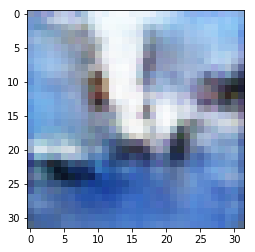

Epoch: [ 3 / 5 ],  Step: [ 310 / 781 ], D_loss:  0.58748627 , G_loss:  1.1945376
Epoch: [ 3 / 5 ],  Step: [ 311 / 781 ], D_loss:  0.75986814 , G_loss:  1.4336127
Epoch: [ 3 / 5 ],  Step: [ 312 / 781 ], D_loss:  0.7426341 , G_loss:  1.2395046
Epoch: [ 3 / 5 ],  Step: [ 313 / 781 ], D_loss:  0.7845367 , G_loss:  1.325822
Epoch: [ 3 / 5 ],  Step: [ 314 / 781 ], D_loss:  0.707492 , G_loss:  1.4171009
Epoch: [ 3 / 5 ],  Step: [ 315 / 781 ], D_loss:  0.8479961 , G_loss:  1.0393546
Epoch: [ 3 / 5 ],  Step: [ 316 / 781 ], D_loss:  0.90175295 , G_loss:  1.8244374
Epoch: [ 3 / 5 ],  Step: [ 317 / 781 ], D_loss:  1.0816598 , G_loss:  1.1341481
Epoch: [ 3 / 5 ],  Step: [ 318 / 781 ], D_loss:  1.4220145 , G_loss:  1.746624
Epoch: [ 3 / 5 ],  Step: [ 319 / 781 ], D_loss:  1.4854174 , G_loss:  1.4524648
(196, 32, 32, 3)


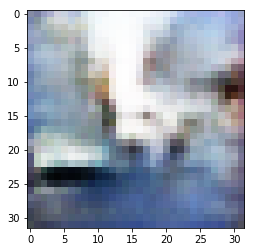

Epoch: [ 3 / 5 ],  Step: [ 320 / 781 ], D_loss:  1.4199005 , G_loss:  1.5382735
Epoch: [ 3 / 5 ],  Step: [ 321 / 781 ], D_loss:  1.3475952 , G_loss:  1.0682808
Epoch: [ 3 / 5 ],  Step: [ 322 / 781 ], D_loss:  1.1017778 , G_loss:  1.2463151
Epoch: [ 3 / 5 ],  Step: [ 323 / 781 ], D_loss:  0.92535865 , G_loss:  1.30063
Epoch: [ 3 / 5 ],  Step: [ 324 / 781 ], D_loss:  0.67650294 , G_loss:  1.2600973
Epoch: [ 3 / 5 ],  Step: [ 325 / 781 ], D_loss:  0.6269275 , G_loss:  1.4125282
Epoch: [ 3 / 5 ],  Step: [ 326 / 781 ], D_loss:  0.6172961 , G_loss:  1.0991006
Epoch: [ 3 / 5 ],  Step: [ 327 / 781 ], D_loss:  0.5876355 , G_loss:  1.2346138
Epoch: [ 3 / 5 ],  Step: [ 328 / 781 ], D_loss:  0.6721153 , G_loss:  1.157636
Epoch: [ 3 / 5 ],  Step: [ 329 / 781 ], D_loss:  0.7486578 , G_loss:  1.3270205
(196, 32, 32, 3)


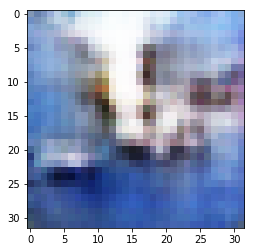

Epoch: [ 3 / 5 ],  Step: [ 330 / 781 ], D_loss:  0.5787746 , G_loss:  1.1776048
Epoch: [ 3 / 5 ],  Step: [ 331 / 781 ], D_loss:  0.6383327 , G_loss:  1.250273
Epoch: [ 3 / 5 ],  Step: [ 332 / 781 ], D_loss:  0.5964496 , G_loss:  1.151802
Epoch: [ 3 / 5 ],  Step: [ 333 / 781 ], D_loss:  0.77033615 , G_loss:  1.4627283
Epoch: [ 3 / 5 ],  Step: [ 334 / 781 ], D_loss:  0.7533915 , G_loss:  1.2052654
Epoch: [ 3 / 5 ],  Step: [ 335 / 781 ], D_loss:  0.6992338 , G_loss:  0.8242571
Epoch: [ 3 / 5 ],  Step: [ 336 / 781 ], D_loss:  0.60534906 , G_loss:  1.1745877
Epoch: [ 3 / 5 ],  Step: [ 337 / 781 ], D_loss:  0.9851207 , G_loss:  2.0896437
Epoch: [ 3 / 5 ],  Step: [ 338 / 781 ], D_loss:  1.2691693 , G_loss:  2.2814744
Epoch: [ 3 / 5 ],  Step: [ 339 / 781 ], D_loss:  1.2009475 , G_loss:  1.3615558
(196, 32, 32, 3)


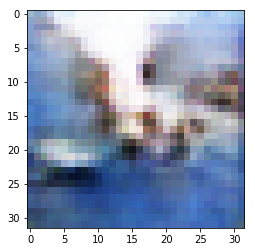

Epoch: [ 3 / 5 ],  Step: [ 340 / 781 ], D_loss:  0.75223875 , G_loss:  1.0176313
Epoch: [ 3 / 5 ],  Step: [ 341 / 781 ], D_loss:  1.4861579 , G_loss:  2.1706758
Epoch: [ 3 / 5 ],  Step: [ 342 / 781 ], D_loss:  1.4739738 , G_loss:  1.900209
Epoch: [ 3 / 5 ],  Step: [ 343 / 781 ], D_loss:  1.5072906 , G_loss:  1.0673475
Epoch: [ 3 / 5 ],  Step: [ 344 / 781 ], D_loss:  1.5630689 , G_loss:  1.7967334
Epoch: [ 3 / 5 ],  Step: [ 345 / 781 ], D_loss:  1.3661454 , G_loss:  1.5412685
Epoch: [ 3 / 5 ],  Step: [ 346 / 781 ], D_loss:  1.4048326 , G_loss:  1.2430329
Epoch: [ 3 / 5 ],  Step: [ 347 / 781 ], D_loss:  1.2092013 , G_loss:  1.3974521
Epoch: [ 3 / 5 ],  Step: [ 348 / 781 ], D_loss:  1.0366362 , G_loss:  1.2084341
Epoch: [ 3 / 5 ],  Step: [ 349 / 781 ], D_loss:  1.0838981 , G_loss:  1.3860202
(196, 32, 32, 3)


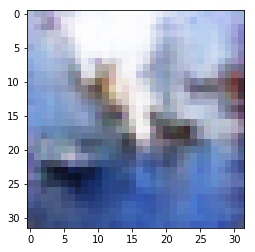

Epoch: [ 3 / 5 ],  Step: [ 350 / 781 ], D_loss:  0.9523227 , G_loss:  1.0754591
Epoch: [ 3 / 5 ],  Step: [ 351 / 781 ], D_loss:  1.1418132 , G_loss:  1.922981
Epoch: [ 3 / 5 ],  Step: [ 352 / 781 ], D_loss:  1.0400231 , G_loss:  1.609175
Epoch: [ 3 / 5 ],  Step: [ 353 / 781 ], D_loss:  0.9942273 , G_loss:  1.1146193
Epoch: [ 3 / 5 ],  Step: [ 354 / 781 ], D_loss:  1.0938745 , G_loss:  1.829889
Epoch: [ 3 / 5 ],  Step: [ 355 / 781 ], D_loss:  0.9606379 , G_loss:  1.5499791
Epoch: [ 3 / 5 ],  Step: [ 356 / 781 ], D_loss:  0.9711548 , G_loss:  1.4360471
Epoch: [ 3 / 5 ],  Step: [ 357 / 781 ], D_loss:  0.879457 , G_loss:  1.3810449
Epoch: [ 3 / 5 ],  Step: [ 358 / 781 ], D_loss:  0.8158608 , G_loss:  1.2943263
Epoch: [ 3 / 5 ],  Step: [ 359 / 781 ], D_loss:  0.7955402 , G_loss:  1.1525459
(196, 32, 32, 3)


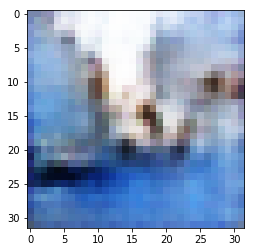

Epoch: [ 3 / 5 ],  Step: [ 360 / 781 ], D_loss:  0.9499937 , G_loss:  1.3017526
Epoch: [ 3 / 5 ],  Step: [ 361 / 781 ], D_loss:  0.7121496 , G_loss:  1.3355186
Epoch: [ 3 / 5 ],  Step: [ 362 / 781 ], D_loss:  0.6376951 , G_loss:  1.1218815
Epoch: [ 3 / 5 ],  Step: [ 363 / 781 ], D_loss:  0.9912887 , G_loss:  1.6886702
Epoch: [ 3 / 5 ],  Step: [ 364 / 781 ], D_loss:  0.9359567 , G_loss:  1.4022721
Epoch: [ 3 / 5 ],  Step: [ 365 / 781 ], D_loss:  0.7952112 , G_loss:  1.2299254
Epoch: [ 3 / 5 ],  Step: [ 366 / 781 ], D_loss:  0.87323236 , G_loss:  1.4229715
Epoch: [ 3 / 5 ],  Step: [ 367 / 781 ], D_loss:  0.8563161 , G_loss:  1.4007714
Epoch: [ 3 / 5 ],  Step: [ 368 / 781 ], D_loss:  0.94179547 , G_loss:  1.2369953
Epoch: [ 3 / 5 ],  Step: [ 369 / 781 ], D_loss:  0.9111669 , G_loss:  1.7771255
(196, 32, 32, 3)


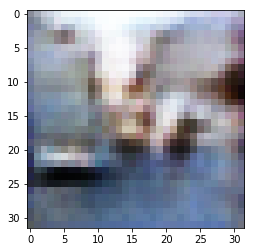

Epoch: [ 3 / 5 ],  Step: [ 370 / 781 ], D_loss:  1.0305552 , G_loss:  1.4481144
Epoch: [ 3 / 5 ],  Step: [ 371 / 781 ], D_loss:  1.0908166 , G_loss:  1.2193501
Epoch: [ 3 / 5 ],  Step: [ 372 / 781 ], D_loss:  0.90094453 , G_loss:  1.3640872
Epoch: [ 3 / 5 ],  Step: [ 373 / 781 ], D_loss:  1.018727 , G_loss:  1.2214072
Epoch: [ 3 / 5 ],  Step: [ 374 / 781 ], D_loss:  0.9927077 , G_loss:  1.1218774
Epoch: [ 3 / 5 ],  Step: [ 375 / 781 ], D_loss:  0.8939286 , G_loss:  1.4766791
Epoch: [ 3 / 5 ],  Step: [ 376 / 781 ], D_loss:  0.9105659 , G_loss:  1.3113245
Epoch: [ 3 / 5 ],  Step: [ 377 / 781 ], D_loss:  0.89298767 , G_loss:  1.2544299
Epoch: [ 3 / 5 ],  Step: [ 378 / 781 ], D_loss:  0.8461599 , G_loss:  1.6196547
Epoch: [ 3 / 5 ],  Step: [ 379 / 781 ], D_loss:  1.0293465 , G_loss:  1.4404807
(196, 32, 32, 3)


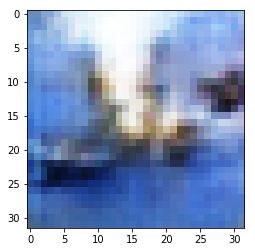

Epoch: [ 3 / 5 ],  Step: [ 380 / 781 ], D_loss:  0.79797167 , G_loss:  0.8486631
Epoch: [ 3 / 5 ],  Step: [ 381 / 781 ], D_loss:  0.873301 , G_loss:  1.5295377
Epoch: [ 3 / 5 ],  Step: [ 382 / 781 ], D_loss:  0.7312236 , G_loss:  1.316524
Epoch: [ 3 / 5 ],  Step: [ 383 / 781 ], D_loss:  0.79960454 , G_loss:  1.1762995
Epoch: [ 3 / 5 ],  Step: [ 384 / 781 ], D_loss:  0.8505037 , G_loss:  1.4473792
Epoch: [ 3 / 5 ],  Step: [ 385 / 781 ], D_loss:  0.7267535 , G_loss:  1.1369531
Epoch: [ 3 / 5 ],  Step: [ 386 / 781 ], D_loss:  0.7774425 , G_loss:  1.5825369
Epoch: [ 3 / 5 ],  Step: [ 387 / 781 ], D_loss:  0.8698939 , G_loss:  1.2169821
Epoch: [ 3 / 5 ],  Step: [ 388 / 781 ], D_loss:  0.73711133 , G_loss:  1.0508988
Epoch: [ 3 / 5 ],  Step: [ 389 / 781 ], D_loss:  0.56001604 , G_loss:  1.4153947
(196, 32, 32, 3)


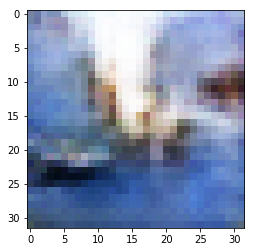

Epoch: [ 3 / 5 ],  Step: [ 390 / 781 ], D_loss:  0.6095865 , G_loss:  1.1021236
Epoch: [ 3 / 5 ],  Step: [ 391 / 781 ], D_loss:  0.73822945 , G_loss:  1.3025261
Epoch: [ 3 / 5 ],  Step: [ 392 / 781 ], D_loss:  0.7896066 , G_loss:  1.2722124
Epoch: [ 3 / 5 ],  Step: [ 393 / 781 ], D_loss:  0.62052643 , G_loss:  1.1745008
Epoch: [ 3 / 5 ],  Step: [ 394 / 781 ], D_loss:  0.79571855 , G_loss:  1.3837011
Epoch: [ 3 / 5 ],  Step: [ 395 / 781 ], D_loss:  0.6622478 , G_loss:  1.0766103
Epoch: [ 3 / 5 ],  Step: [ 396 / 781 ], D_loss:  0.72037506 , G_loss:  1.2169327
Epoch: [ 3 / 5 ],  Step: [ 397 / 781 ], D_loss:  0.65895045 , G_loss:  1.089619
Epoch: [ 3 / 5 ],  Step: [ 398 / 781 ], D_loss:  0.9114882 , G_loss:  1.7042799
Epoch: [ 3 / 5 ],  Step: [ 399 / 781 ], D_loss:  0.9371744 , G_loss:  1.4405324
(196, 32, 32, 3)


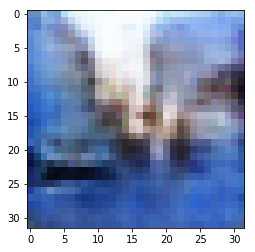

Epoch: [ 3 / 5 ],  Step: [ 400 / 781 ], D_loss:  0.98305076 , G_loss:  0.93501896
Epoch: [ 3 / 5 ],  Step: [ 401 / 781 ], D_loss:  1.2367023 , G_loss:  1.8140836
Epoch: [ 3 / 5 ],  Step: [ 402 / 781 ], D_loss:  1.1099513 , G_loss:  1.4860088
Epoch: [ 3 / 5 ],  Step: [ 403 / 781 ], D_loss:  0.99849886 , G_loss:  1.0493402
Epoch: [ 3 / 5 ],  Step: [ 404 / 781 ], D_loss:  1.0373857 , G_loss:  1.5692506
Epoch: [ 3 / 5 ],  Step: [ 405 / 781 ], D_loss:  0.9633676 , G_loss:  1.27056
Epoch: [ 3 / 5 ],  Step: [ 406 / 781 ], D_loss:  0.8283143 , G_loss:  1.3371584
Epoch: [ 3 / 5 ],  Step: [ 407 / 781 ], D_loss:  0.5467022 , G_loss:  1.2825497
Epoch: [ 3 / 5 ],  Step: [ 408 / 781 ], D_loss:  0.8682994 , G_loss:  1.440453
Epoch: [ 3 / 5 ],  Step: [ 409 / 781 ], D_loss:  0.74823797 , G_loss:  1.216403
(196, 32, 32, 3)


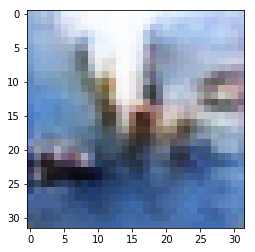

Epoch: [ 3 / 5 ],  Step: [ 410 / 781 ], D_loss:  0.8686219 , G_loss:  0.98623
Epoch: [ 3 / 5 ],  Step: [ 411 / 781 ], D_loss:  0.61611366 , G_loss:  1.1906992
Epoch: [ 3 / 5 ],  Step: [ 412 / 781 ], D_loss:  0.90312254 , G_loss:  1.8508875
Epoch: [ 3 / 5 ],  Step: [ 413 / 781 ], D_loss:  1.241103 , G_loss:  1.3445565
Epoch: [ 3 / 5 ],  Step: [ 414 / 781 ], D_loss:  1.1135631 , G_loss:  0.97270834
Epoch: [ 3 / 5 ],  Step: [ 415 / 781 ], D_loss:  1.3528358 , G_loss:  1.8088921
Epoch: [ 3 / 5 ],  Step: [ 416 / 781 ], D_loss:  1.2607591 , G_loss:  1.4874731
Epoch: [ 3 / 5 ],  Step: [ 417 / 781 ], D_loss:  1.146562 , G_loss:  1.008257
Epoch: [ 3 / 5 ],  Step: [ 418 / 781 ], D_loss:  1.6438184 , G_loss:  2.2963052
Epoch: [ 3 / 5 ],  Step: [ 419 / 781 ], D_loss:  1.4337355 , G_loss:  2.0453236
(196, 32, 32, 3)


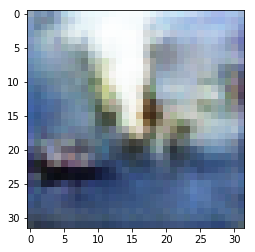

Epoch: [ 3 / 5 ],  Step: [ 420 / 781 ], D_loss:  1.4815888 , G_loss:  1.2901597
Epoch: [ 3 / 5 ],  Step: [ 421 / 781 ], D_loss:  1.5965346 , G_loss:  2.0320933
Epoch: [ 3 / 5 ],  Step: [ 422 / 781 ], D_loss:  1.419751 , G_loss:  1.5885926
Epoch: [ 3 / 5 ],  Step: [ 423 / 781 ], D_loss:  1.4003406 , G_loss:  1.2051497
Epoch: [ 3 / 5 ],  Step: [ 424 / 781 ], D_loss:  1.1888008 , G_loss:  1.4302279
Epoch: [ 3 / 5 ],  Step: [ 425 / 781 ], D_loss:  1.180066 , G_loss:  1.4627448
Epoch: [ 3 / 5 ],  Step: [ 426 / 781 ], D_loss:  0.93566084 , G_loss:  1.2770458
Epoch: [ 3 / 5 ],  Step: [ 427 / 781 ], D_loss:  0.9013281 , G_loss:  0.9525318
Epoch: [ 3 / 5 ],  Step: [ 428 / 781 ], D_loss:  0.8514447 , G_loss:  1.6253997
Epoch: [ 3 / 5 ],  Step: [ 429 / 781 ], D_loss:  0.8958404 , G_loss:  1.3010551
(196, 32, 32, 3)


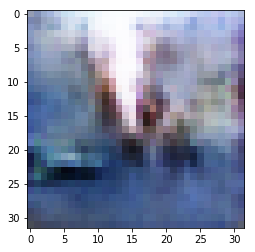

Epoch: [ 3 / 5 ],  Step: [ 430 / 781 ], D_loss:  0.83684754 , G_loss:  1.2413337
Epoch: [ 3 / 5 ],  Step: [ 431 / 781 ], D_loss:  0.7837824 , G_loss:  1.2018682
Epoch: [ 3 / 5 ],  Step: [ 432 / 781 ], D_loss:  0.8494657 , G_loss:  1.1826526
Epoch: [ 3 / 5 ],  Step: [ 433 / 781 ], D_loss:  0.9022068 , G_loss:  1.018272
Epoch: [ 3 / 5 ],  Step: [ 434 / 781 ], D_loss:  0.92353135 , G_loss:  1.3844388
Epoch: [ 3 / 5 ],  Step: [ 435 / 781 ], D_loss:  0.89104146 , G_loss:  1.3038412
Epoch: [ 3 / 5 ],  Step: [ 436 / 781 ], D_loss:  0.71953225 , G_loss:  1.3282984
Epoch: [ 3 / 5 ],  Step: [ 437 / 781 ], D_loss:  0.6475812 , G_loss:  1.2189748
Epoch: [ 3 / 5 ],  Step: [ 438 / 781 ], D_loss:  0.9685105 , G_loss:  1.593369
Epoch: [ 3 / 5 ],  Step: [ 439 / 781 ], D_loss:  1.0796962 , G_loss:  1.4591738
(196, 32, 32, 3)


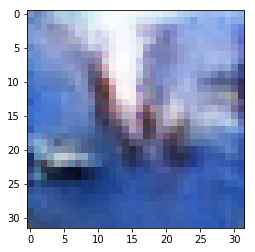

Epoch: [ 3 / 5 ],  Step: [ 440 / 781 ], D_loss:  0.85347164 , G_loss:  0.951636
Epoch: [ 3 / 5 ],  Step: [ 441 / 781 ], D_loss:  0.6844464 , G_loss:  1.4077554
Epoch: [ 3 / 5 ],  Step: [ 442 / 781 ], D_loss:  0.79805523 , G_loss:  1.8297853
Epoch: [ 3 / 5 ],  Step: [ 443 / 781 ], D_loss:  1.1840044 , G_loss:  1.544764
Epoch: [ 3 / 5 ],  Step: [ 444 / 781 ], D_loss:  1.032701 , G_loss:  1.1818622
Epoch: [ 3 / 5 ],  Step: [ 445 / 781 ], D_loss:  0.824476 , G_loss:  0.9000992
Epoch: [ 3 / 5 ],  Step: [ 446 / 781 ], D_loss:  0.98860264 , G_loss:  1.5881181
Epoch: [ 3 / 5 ],  Step: [ 447 / 781 ], D_loss:  1.0132107 , G_loss:  1.2819285
Epoch: [ 3 / 5 ],  Step: [ 448 / 781 ], D_loss:  0.97300017 , G_loss:  1.2407502
Epoch: [ 3 / 5 ],  Step: [ 449 / 781 ], D_loss:  0.96378976 , G_loss:  1.1621444
(196, 32, 32, 3)


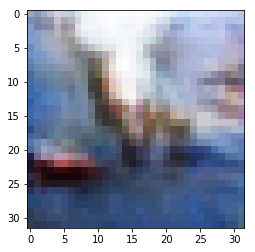

Epoch: [ 3 / 5 ],  Step: [ 450 / 781 ], D_loss:  0.82892025 , G_loss:  1.6286434
Epoch: [ 3 / 5 ],  Step: [ 451 / 781 ], D_loss:  0.82435185 , G_loss:  1.4011407
Epoch: [ 3 / 5 ],  Step: [ 452 / 781 ], D_loss:  0.81362325 , G_loss:  1.0545981
Epoch: [ 3 / 5 ],  Step: [ 453 / 781 ], D_loss:  0.68942785 , G_loss:  1.2716223
Epoch: [ 3 / 5 ],  Step: [ 454 / 781 ], D_loss:  0.8022684 , G_loss:  1.365539
Epoch: [ 3 / 5 ],  Step: [ 455 / 781 ], D_loss:  1.0509 , G_loss:  1.8304458
Epoch: [ 3 / 5 ],  Step: [ 456 / 781 ], D_loss:  1.1561402 , G_loss:  1.8361582
Epoch: [ 3 / 5 ],  Step: [ 457 / 781 ], D_loss:  1.2270681 , G_loss:  1.3010173
Epoch: [ 3 / 5 ],  Step: [ 458 / 781 ], D_loss:  1.01177 , G_loss:  1.1875712
Epoch: [ 3 / 5 ],  Step: [ 459 / 781 ], D_loss:  0.8925168 , G_loss:  1.2810733
(196, 32, 32, 3)


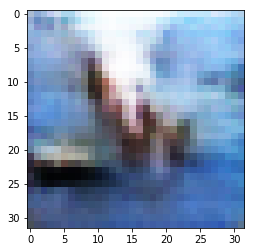

Epoch: [ 3 / 5 ],  Step: [ 460 / 781 ], D_loss:  0.80764055 , G_loss:  1.2107477
Epoch: [ 3 / 5 ],  Step: [ 461 / 781 ], D_loss:  0.76593953 , G_loss:  1.1778283
Epoch: [ 3 / 5 ],  Step: [ 462 / 781 ], D_loss:  0.7779009 , G_loss:  0.9936284
Epoch: [ 3 / 5 ],  Step: [ 463 / 781 ], D_loss:  1.2058138 , G_loss:  2.1599646
Epoch: [ 3 / 5 ],  Step: [ 464 / 781 ], D_loss:  1.4009976 , G_loss:  1.9255991
Epoch: [ 3 / 5 ],  Step: [ 465 / 781 ], D_loss:  1.3066998 , G_loss:  1.121033
Epoch: [ 3 / 5 ],  Step: [ 466 / 781 ], D_loss:  1.1530216 , G_loss:  1.0266508
Epoch: [ 3 / 5 ],  Step: [ 467 / 781 ], D_loss:  1.1792597 , G_loss:  1.086256
Epoch: [ 3 / 5 ],  Step: [ 468 / 781 ], D_loss:  1.146706 , G_loss:  1.2387639
Epoch: [ 3 / 5 ],  Step: [ 469 / 781 ], D_loss:  1.0405376 , G_loss:  1.0285383
(196, 32, 32, 3)


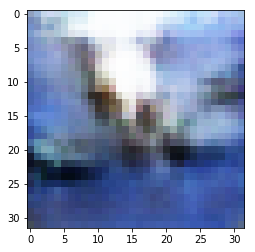

Epoch: [ 3 / 5 ],  Step: [ 470 / 781 ], D_loss:  1.2208412 , G_loss:  1.7826805
Epoch: [ 3 / 5 ],  Step: [ 471 / 781 ], D_loss:  1.3009435 , G_loss:  1.6185074
Epoch: [ 3 / 5 ],  Step: [ 472 / 781 ], D_loss:  1.2673917 , G_loss:  1.0912509
Epoch: [ 3 / 5 ],  Step: [ 473 / 781 ], D_loss:  1.1519549 , G_loss:  1.374781
Epoch: [ 3 / 5 ],  Step: [ 474 / 781 ], D_loss:  0.85669273 , G_loss:  1.1009623
Epoch: [ 3 / 5 ],  Step: [ 475 / 781 ], D_loss:  1.0665216 , G_loss:  1.6084113
Epoch: [ 3 / 5 ],  Step: [ 476 / 781 ], D_loss:  1.0999851 , G_loss:  1.2922184
Epoch: [ 3 / 5 ],  Step: [ 477 / 781 ], D_loss:  1.1470723 , G_loss:  1.3453919
Epoch: [ 3 / 5 ],  Step: [ 478 / 781 ], D_loss:  1.090031 , G_loss:  1.110786
Epoch: [ 3 / 5 ],  Step: [ 479 / 781 ], D_loss:  1.0875211 , G_loss:  0.99328154
(196, 32, 32, 3)


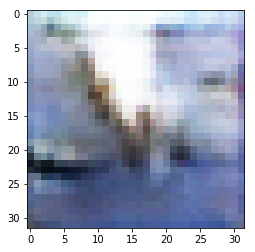

Epoch: [ 3 / 5 ],  Step: [ 480 / 781 ], D_loss:  1.0565357 , G_loss:  1.3227062
Epoch: [ 3 / 5 ],  Step: [ 481 / 781 ], D_loss:  0.9456315 , G_loss:  1.288149
Epoch: [ 3 / 5 ],  Step: [ 482 / 781 ], D_loss:  1.0397599 , G_loss:  1.2069597
Epoch: [ 3 / 5 ],  Step: [ 483 / 781 ], D_loss:  0.92655873 , G_loss:  1.5120625
Epoch: [ 3 / 5 ],  Step: [ 484 / 781 ], D_loss:  0.9867181 , G_loss:  1.2477342
Epoch: [ 3 / 5 ],  Step: [ 485 / 781 ], D_loss:  1.004761 , G_loss:  1.0120821
Epoch: [ 3 / 5 ],  Step: [ 486 / 781 ], D_loss:  0.8723103 , G_loss:  1.4216764
Epoch: [ 3 / 5 ],  Step: [ 487 / 781 ], D_loss:  1.0613765 , G_loss:  1.164916
Epoch: [ 3 / 5 ],  Step: [ 488 / 781 ], D_loss:  0.92624825 , G_loss:  1.0234678
Epoch: [ 3 / 5 ],  Step: [ 489 / 781 ], D_loss:  0.9079137 , G_loss:  1.405438
(196, 32, 32, 3)


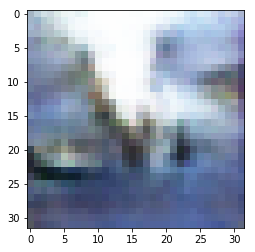

Epoch: [ 3 / 5 ],  Step: [ 490 / 781 ], D_loss:  0.7971162 , G_loss:  1.1687601
Epoch: [ 3 / 5 ],  Step: [ 491 / 781 ], D_loss:  0.9407845 , G_loss:  1.2266057
Epoch: [ 3 / 5 ],  Step: [ 492 / 781 ], D_loss:  0.8592453 , G_loss:  1.0071038
Epoch: [ 3 / 5 ],  Step: [ 493 / 781 ], D_loss:  0.7444456 , G_loss:  1.2689524
Epoch: [ 3 / 5 ],  Step: [ 494 / 781 ], D_loss:  0.7163421 , G_loss:  1.4972129
Epoch: [ 3 / 5 ],  Step: [ 495 / 781 ], D_loss:  0.6823073 , G_loss:  1.3034129
Epoch: [ 3 / 5 ],  Step: [ 496 / 781 ], D_loss:  0.8145284 , G_loss:  0.89562523
Epoch: [ 3 / 5 ],  Step: [ 497 / 781 ], D_loss:  1.0319359 , G_loss:  1.9467878
Epoch: [ 3 / 5 ],  Step: [ 498 / 781 ], D_loss:  0.93014973 , G_loss:  1.4290322
Epoch: [ 3 / 5 ],  Step: [ 499 / 781 ], D_loss:  0.9665831 , G_loss:  1.0313154
(196, 32, 32, 3)


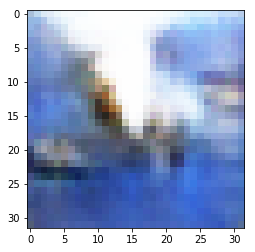

Epoch: [ 3 / 5 ],  Step: [ 500 / 781 ], D_loss:  0.7966088 , G_loss:  1.4684436
Epoch: [ 3 / 5 ],  Step: [ 501 / 781 ], D_loss:  0.82260394 , G_loss:  1.1009015
Epoch: [ 3 / 5 ],  Step: [ 502 / 781 ], D_loss:  0.71577454 , G_loss:  1.1920619
Epoch: [ 3 / 5 ],  Step: [ 503 / 781 ], D_loss:  1.0067494 , G_loss:  1.9069793
Epoch: [ 3 / 5 ],  Step: [ 504 / 781 ], D_loss:  1.125197 , G_loss:  1.4136573
Epoch: [ 3 / 5 ],  Step: [ 505 / 781 ], D_loss:  1.1704453 , G_loss:  0.81744134
Epoch: [ 3 / 5 ],  Step: [ 506 / 781 ], D_loss:  1.1637843 , G_loss:  1.2721004
Epoch: [ 3 / 5 ],  Step: [ 507 / 781 ], D_loss:  1.1722109 , G_loss:  1.41565
Epoch: [ 3 / 5 ],  Step: [ 508 / 781 ], D_loss:  1.1899782 , G_loss:  1.1303855
Epoch: [ 3 / 5 ],  Step: [ 509 / 781 ], D_loss:  0.90100425 , G_loss:  1.1229047
(196, 32, 32, 3)


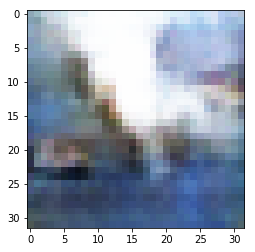

Epoch: [ 3 / 5 ],  Step: [ 510 / 781 ], D_loss:  0.9381719 , G_loss:  1.326032
Epoch: [ 3 / 5 ],  Step: [ 511 / 781 ], D_loss:  0.83205473 , G_loss:  1.2104828
Epoch: [ 3 / 5 ],  Step: [ 512 / 781 ], D_loss:  0.7953228 , G_loss:  1.0812097
Epoch: [ 3 / 5 ],  Step: [ 513 / 781 ], D_loss:  0.77611613 , G_loss:  1.3019701
Epoch: [ 3 / 5 ],  Step: [ 514 / 781 ], D_loss:  0.6786817 , G_loss:  1.2022991
Epoch: [ 3 / 5 ],  Step: [ 515 / 781 ], D_loss:  0.70986795 , G_loss:  1.217894
Epoch: [ 3 / 5 ],  Step: [ 516 / 781 ], D_loss:  0.6289755 , G_loss:  1.2425054
Epoch: [ 3 / 5 ],  Step: [ 517 / 781 ], D_loss:  0.43967125 , G_loss:  1.2645506
Epoch: [ 3 / 5 ],  Step: [ 518 / 781 ], D_loss:  0.6170337 , G_loss:  1.4475766
Epoch: [ 3 / 5 ],  Step: [ 519 / 781 ], D_loss:  0.7871106 , G_loss:  0.9825552
(196, 32, 32, 3)


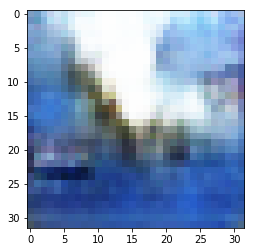

Epoch: [ 3 / 5 ],  Step: [ 520 / 781 ], D_loss:  0.6462118 , G_loss:  1.3023635
Epoch: [ 3 / 5 ],  Step: [ 521 / 781 ], D_loss:  0.92131686 , G_loss:  1.5747489
Epoch: [ 3 / 5 ],  Step: [ 522 / 781 ], D_loss:  0.8912411 , G_loss:  1.1925516
Epoch: [ 3 / 5 ],  Step: [ 523 / 781 ], D_loss:  0.7757512 , G_loss:  0.9840621
Epoch: [ 3 / 5 ],  Step: [ 524 / 781 ], D_loss:  0.7982146 , G_loss:  1.2149365
Epoch: [ 3 / 5 ],  Step: [ 525 / 781 ], D_loss:  0.6477092 , G_loss:  1.2906014
Epoch: [ 3 / 5 ],  Step: [ 526 / 781 ], D_loss:  1.2183995 , G_loss:  2.0529327
Epoch: [ 3 / 5 ],  Step: [ 527 / 781 ], D_loss:  1.2372619 , G_loss:  1.5872389
Epoch: [ 3 / 5 ],  Step: [ 528 / 781 ], D_loss:  1.1385894 , G_loss:  0.86981577
Epoch: [ 3 / 5 ],  Step: [ 529 / 781 ], D_loss:  1.9185187 , G_loss:  2.3903587
(196, 32, 32, 3)


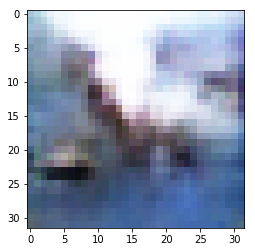

Epoch: [ 3 / 5 ],  Step: [ 530 / 781 ], D_loss:  1.7863503 , G_loss:  1.7861519
Epoch: [ 3 / 5 ],  Step: [ 531 / 781 ], D_loss:  1.6068779 , G_loss:  0.96623814
Epoch: [ 3 / 5 ],  Step: [ 532 / 781 ], D_loss:  1.66485 , G_loss:  1.2144251
Epoch: [ 3 / 5 ],  Step: [ 533 / 781 ], D_loss:  1.4995618 , G_loss:  1.589567
Epoch: [ 3 / 5 ],  Step: [ 534 / 781 ], D_loss:  1.7809916 , G_loss:  1.3325915
Epoch: [ 3 / 5 ],  Step: [ 535 / 781 ], D_loss:  1.5649797 , G_loss:  0.88262415
Epoch: [ 3 / 5 ],  Step: [ 536 / 781 ], D_loss:  1.8654559 , G_loss:  1.4122937
Epoch: [ 3 / 5 ],  Step: [ 537 / 781 ], D_loss:  1.5117851 , G_loss:  1.422954
Epoch: [ 3 / 5 ],  Step: [ 538 / 781 ], D_loss:  1.4924572 , G_loss:  1.043692
Epoch: [ 3 / 5 ],  Step: [ 539 / 781 ], D_loss:  1.5763009 , G_loss:  1.204993
(196, 32, 32, 3)


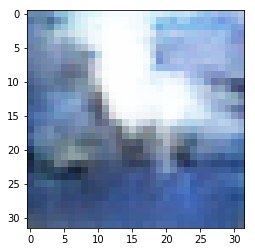

Epoch: [ 3 / 5 ],  Step: [ 540 / 781 ], D_loss:  1.3646789 , G_loss:  1.1315061
Epoch: [ 3 / 5 ],  Step: [ 541 / 781 ], D_loss:  1.423101 , G_loss:  1.0168402
Epoch: [ 3 / 5 ],  Step: [ 542 / 781 ], D_loss:  1.2740617 , G_loss:  1.0563904
Epoch: [ 3 / 5 ],  Step: [ 543 / 781 ], D_loss:  1.2218974 , G_loss:  0.96844906
Epoch: [ 3 / 5 ],  Step: [ 544 / 781 ], D_loss:  1.1625885 , G_loss:  1.2899448
Epoch: [ 3 / 5 ],  Step: [ 545 / 781 ], D_loss:  1.408682 , G_loss:  1.2104206
Epoch: [ 3 / 5 ],  Step: [ 546 / 781 ], D_loss:  1.2337837 , G_loss:  0.8884968
Epoch: [ 3 / 5 ],  Step: [ 547 / 781 ], D_loss:  1.2481685 , G_loss:  1.4809749
Epoch: [ 3 / 5 ],  Step: [ 548 / 781 ], D_loss:  1.2126107 , G_loss:  1.2733278
Epoch: [ 3 / 5 ],  Step: [ 549 / 781 ], D_loss:  1.0709622 , G_loss:  0.9758034
(196, 32, 32, 3)


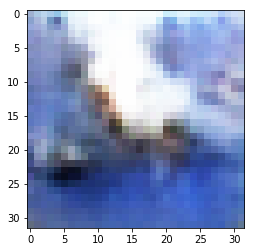

Epoch: [ 3 / 5 ],  Step: [ 550 / 781 ], D_loss:  1.1255041 , G_loss:  1.6643972
Epoch: [ 3 / 5 ],  Step: [ 551 / 781 ], D_loss:  1.3072491 , G_loss:  1.6100297
Epoch: [ 3 / 5 ],  Step: [ 552 / 781 ], D_loss:  0.8651136 , G_loss:  1.1089272
Epoch: [ 3 / 5 ],  Step: [ 553 / 781 ], D_loss:  0.8538877 , G_loss:  1.528969
Epoch: [ 3 / 5 ],  Step: [ 554 / 781 ], D_loss:  0.6722298 , G_loss:  1.4671527
Epoch: [ 3 / 5 ],  Step: [ 555 / 781 ], D_loss:  0.7658369 , G_loss:  1.1421908
Epoch: [ 3 / 5 ],  Step: [ 556 / 781 ], D_loss:  0.80091065 , G_loss:  1.0575445
Epoch: [ 3 / 5 ],  Step: [ 557 / 781 ], D_loss:  1.0716867 , G_loss:  1.902006
Epoch: [ 3 / 5 ],  Step: [ 558 / 781 ], D_loss:  0.9340969 , G_loss:  1.9129077
Epoch: [ 3 / 5 ],  Step: [ 559 / 781 ], D_loss:  1.2418913 , G_loss:  1.3285629
(196, 32, 32, 3)


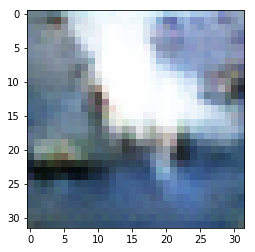

Epoch: [ 3 / 5 ],  Step: [ 560 / 781 ], D_loss:  1.2979752 , G_loss:  1.2593777
Epoch: [ 3 / 5 ],  Step: [ 561 / 781 ], D_loss:  1.1316695 , G_loss:  1.1680543
Epoch: [ 3 / 5 ],  Step: [ 562 / 781 ], D_loss:  1.0883608 , G_loss:  1.2926804
Epoch: [ 3 / 5 ],  Step: [ 563 / 781 ], D_loss:  0.80541706 , G_loss:  1.1741154
Epoch: [ 3 / 5 ],  Step: [ 564 / 781 ], D_loss:  0.84897465 , G_loss:  1.0195944
Epoch: [ 3 / 5 ],  Step: [ 565 / 781 ], D_loss:  0.6038751 , G_loss:  1.1782507
Epoch: [ 3 / 5 ],  Step: [ 566 / 781 ], D_loss:  0.87159973 , G_loss:  1.6985463
Epoch: [ 3 / 5 ],  Step: [ 567 / 781 ], D_loss:  1.0340568 , G_loss:  1.2319758
Epoch: [ 3 / 5 ],  Step: [ 568 / 781 ], D_loss:  0.8779864 , G_loss:  1.0790315
Epoch: [ 3 / 5 ],  Step: [ 569 / 781 ], D_loss:  0.8733223 , G_loss:  1.1704662
(196, 32, 32, 3)


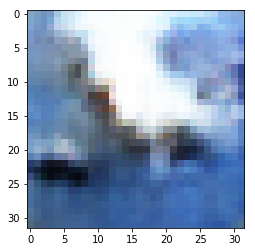

Epoch: [ 3 / 5 ],  Step: [ 570 / 781 ], D_loss:  1.0129592 , G_loss:  1.6134989
Epoch: [ 3 / 5 ],  Step: [ 571 / 781 ], D_loss:  0.79263586 , G_loss:  1.3592842
Epoch: [ 3 / 5 ],  Step: [ 572 / 781 ], D_loss:  0.75949013 , G_loss:  0.95976496
Epoch: [ 3 / 5 ],  Step: [ 573 / 781 ], D_loss:  0.8790726 , G_loss:  1.617804
Epoch: [ 3 / 5 ],  Step: [ 574 / 781 ], D_loss:  0.95031273 , G_loss:  1.290829
Epoch: [ 3 / 5 ],  Step: [ 575 / 781 ], D_loss:  0.8221476 , G_loss:  1.254354
Epoch: [ 3 / 5 ],  Step: [ 576 / 781 ], D_loss:  0.9114313 , G_loss:  1.185658
Epoch: [ 3 / 5 ],  Step: [ 577 / 781 ], D_loss:  0.5829566 , G_loss:  1.3340113
Epoch: [ 3 / 5 ],  Step: [ 578 / 781 ], D_loss:  0.86641586 , G_loss:  1.5978167
Epoch: [ 3 / 5 ],  Step: [ 579 / 781 ], D_loss:  1.1676227 , G_loss:  1.5050184
(196, 32, 32, 3)


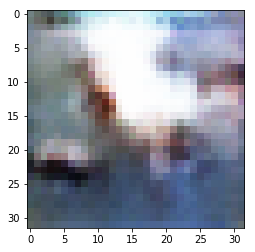

Epoch: [ 3 / 5 ],  Step: [ 580 / 781 ], D_loss:  0.7488356 , G_loss:  1.3238146
Epoch: [ 3 / 5 ],  Step: [ 581 / 781 ], D_loss:  0.91421866 , G_loss:  1.3746564
Epoch: [ 3 / 5 ],  Step: [ 582 / 781 ], D_loss:  0.7950884 , G_loss:  1.1236295
Epoch: [ 3 / 5 ],  Step: [ 583 / 781 ], D_loss:  0.74864 , G_loss:  0.9647773
Epoch: [ 3 / 5 ],  Step: [ 584 / 781 ], D_loss:  0.39972544 , G_loss:  1.23401
Epoch: [ 3 / 5 ],  Step: [ 585 / 781 ], D_loss:  1.0883603 , G_loss:  2.1035118
Epoch: [ 3 / 5 ],  Step: [ 586 / 781 ], D_loss:  0.9562878 , G_loss:  2.3265243
Epoch: [ 3 / 5 ],  Step: [ 587 / 781 ], D_loss:  1.1865535 , G_loss:  1.5470442
Epoch: [ 3 / 5 ],  Step: [ 588 / 781 ], D_loss:  0.8479672 , G_loss:  1.0022521
Epoch: [ 3 / 5 ],  Step: [ 589 / 781 ], D_loss:  1.4229386 , G_loss:  2.337881
(196, 32, 32, 3)


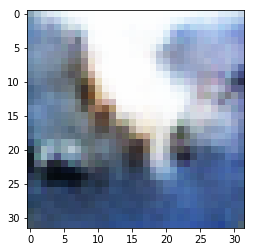

Epoch: [ 3 / 5 ],  Step: [ 590 / 781 ], D_loss:  1.4918517 , G_loss:  2.4104588
Epoch: [ 3 / 5 ],  Step: [ 591 / 781 ], D_loss:  1.538785 , G_loss:  1.7675432
Epoch: [ 3 / 5 ],  Step: [ 592 / 781 ], D_loss:  1.3134804 , G_loss:  1.2397311
Epoch: [ 3 / 5 ],  Step: [ 593 / 781 ], D_loss:  1.4325802 , G_loss:  1.7919705
Epoch: [ 3 / 5 ],  Step: [ 594 / 781 ], D_loss:  1.2564555 , G_loss:  1.6173463
Epoch: [ 3 / 5 ],  Step: [ 595 / 781 ], D_loss:  1.2010498 , G_loss:  1.3477681
Epoch: [ 3 / 5 ],  Step: [ 596 / 781 ], D_loss:  0.9443957 , G_loss:  1.2683926
Epoch: [ 3 / 5 ],  Step: [ 597 / 781 ], D_loss:  1.0637066 , G_loss:  1.0576949
Epoch: [ 3 / 5 ],  Step: [ 598 / 781 ], D_loss:  0.87253743 , G_loss:  1.2352464
Epoch: [ 3 / 5 ],  Step: [ 599 / 781 ], D_loss:  0.83102316 , G_loss:  1.1965101
(196, 32, 32, 3)


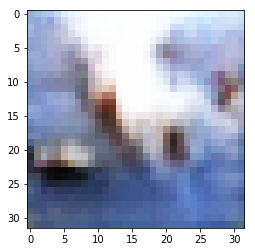

Epoch: [ 3 / 5 ],  Step: [ 600 / 781 ], D_loss:  0.83379805 , G_loss:  1.2652947
Epoch: [ 3 / 5 ],  Step: [ 601 / 781 ], D_loss:  0.7150682 , G_loss:  1.2855377
Epoch: [ 3 / 5 ],  Step: [ 602 / 781 ], D_loss:  0.57768345 , G_loss:  1.2137232
Epoch: [ 3 / 5 ],  Step: [ 603 / 781 ], D_loss:  0.97743034 , G_loss:  2.0043416
Epoch: [ 3 / 5 ],  Step: [ 604 / 781 ], D_loss:  1.1139216 , G_loss:  1.921764
Epoch: [ 3 / 5 ],  Step: [ 605 / 781 ], D_loss:  1.272565 , G_loss:  1.3528956
Epoch: [ 3 / 5 ],  Step: [ 606 / 781 ], D_loss:  1.0749896 , G_loss:  0.8434657
Epoch: [ 3 / 5 ],  Step: [ 607 / 781 ], D_loss:  1.4601417 , G_loss:  1.5760043
Epoch: [ 3 / 5 ],  Step: [ 608 / 781 ], D_loss:  1.3622074 , G_loss:  1.6082736
Epoch: [ 3 / 5 ],  Step: [ 609 / 781 ], D_loss:  1.2376755 , G_loss:  1.0325847
(196, 32, 32, 3)


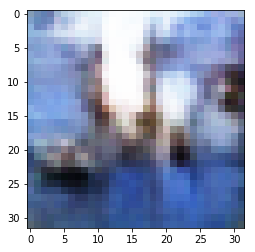

Epoch: [ 3 / 5 ],  Step: [ 610 / 781 ], D_loss:  1.2150755 , G_loss:  1.3781178
Epoch: [ 3 / 5 ],  Step: [ 611 / 781 ], D_loss:  1.0897541 , G_loss:  1.5745466
Epoch: [ 3 / 5 ],  Step: [ 612 / 781 ], D_loss:  1.2576088 , G_loss:  1.4062519
Epoch: [ 3 / 5 ],  Step: [ 613 / 781 ], D_loss:  0.89061433 , G_loss:  1.0168233
Epoch: [ 3 / 5 ],  Step: [ 614 / 781 ], D_loss:  1.0829046 , G_loss:  1.623488
Epoch: [ 3 / 5 ],  Step: [ 615 / 781 ], D_loss:  1.017779 , G_loss:  1.3692508
Epoch: [ 3 / 5 ],  Step: [ 616 / 781 ], D_loss:  0.9864544 , G_loss:  1.0609347
Epoch: [ 3 / 5 ],  Step: [ 617 / 781 ], D_loss:  0.8690903 , G_loss:  1.2206002
Epoch: [ 3 / 5 ],  Step: [ 618 / 781 ], D_loss:  0.8299411 , G_loss:  1.0169095
Epoch: [ 3 / 5 ],  Step: [ 619 / 781 ], D_loss:  1.1869122 , G_loss:  1.65697
(196, 32, 32, 3)


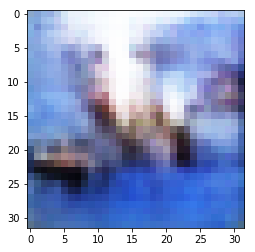

Epoch: [ 3 / 5 ],  Step: [ 620 / 781 ], D_loss:  1.0824989 , G_loss:  1.538063
Epoch: [ 3 / 5 ],  Step: [ 621 / 781 ], D_loss:  1.1853299 , G_loss:  1.2009952
Epoch: [ 3 / 5 ],  Step: [ 622 / 781 ], D_loss:  0.88532716 , G_loss:  0.9751967
Epoch: [ 3 / 5 ],  Step: [ 623 / 781 ], D_loss:  0.957142 , G_loss:  1.365716
Epoch: [ 3 / 5 ],  Step: [ 624 / 781 ], D_loss:  0.8260228 , G_loss:  1.2933712
Epoch: [ 3 / 5 ],  Step: [ 625 / 781 ], D_loss:  0.93888927 , G_loss:  1.2606475
Epoch: [ 3 / 5 ],  Step: [ 626 / 781 ], D_loss:  0.9525459 , G_loss:  1.0021558
Epoch: [ 3 / 5 ],  Step: [ 627 / 781 ], D_loss:  0.57111204 , G_loss:  0.9997585
Epoch: [ 3 / 5 ],  Step: [ 628 / 781 ], D_loss:  1.3193406 , G_loss:  2.0468342
Epoch: [ 3 / 5 ],  Step: [ 629 / 781 ], D_loss:  1.3389676 , G_loss:  1.967395
(196, 32, 32, 3)


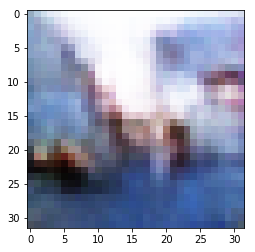

Epoch: [ 3 / 5 ],  Step: [ 630 / 781 ], D_loss:  1.309526 , G_loss:  1.3457611
Epoch: [ 3 / 5 ],  Step: [ 631 / 781 ], D_loss:  0.90254587 , G_loss:  1.093289
Epoch: [ 3 / 5 ],  Step: [ 632 / 781 ], D_loss:  1.1430478 , G_loss:  1.7754688
Epoch: [ 3 / 5 ],  Step: [ 633 / 781 ], D_loss:  1.2591238 , G_loss:  1.5255197
Epoch: [ 3 / 5 ],  Step: [ 634 / 781 ], D_loss:  1.1862744 , G_loss:  1.0346333
Epoch: [ 3 / 5 ],  Step: [ 635 / 781 ], D_loss:  0.88146317 , G_loss:  0.95808536
Epoch: [ 3 / 5 ],  Step: [ 636 / 781 ], D_loss:  1.4369407 , G_loss:  2.0602987
Epoch: [ 3 / 5 ],  Step: [ 637 / 781 ], D_loss:  1.3636037 , G_loss:  1.4159263
Epoch: [ 3 / 5 ],  Step: [ 638 / 781 ], D_loss:  1.2574885 , G_loss:  0.97671825
Epoch: [ 3 / 5 ],  Step: [ 639 / 781 ], D_loss:  1.2027402 , G_loss:  1.6049172
(196, 32, 32, 3)


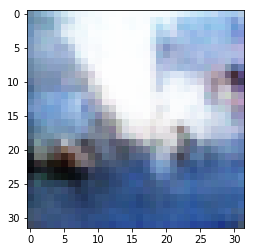

Epoch: [ 3 / 5 ],  Step: [ 640 / 781 ], D_loss:  1.3620408 , G_loss:  1.6419879
Epoch: [ 3 / 5 ],  Step: [ 641 / 781 ], D_loss:  1.25923 , G_loss:  1.4260331
Epoch: [ 3 / 5 ],  Step: [ 642 / 781 ], D_loss:  1.1186606 , G_loss:  1.1537346
Epoch: [ 3 / 5 ],  Step: [ 643 / 781 ], D_loss:  0.9992324 , G_loss:  1.1871688
Epoch: [ 3 / 5 ],  Step: [ 644 / 781 ], D_loss:  0.9109554 , G_loss:  1.1069494
Epoch: [ 3 / 5 ],  Step: [ 645 / 781 ], D_loss:  0.76760113 , G_loss:  1.0417817
Epoch: [ 3 / 5 ],  Step: [ 646 / 781 ], D_loss:  0.9717861 , G_loss:  1.4334382
Epoch: [ 3 / 5 ],  Step: [ 647 / 781 ], D_loss:  0.86788225 , G_loss:  1.2898107
Epoch: [ 3 / 5 ],  Step: [ 648 / 781 ], D_loss:  0.64778215 , G_loss:  1.0826365
Epoch: [ 3 / 5 ],  Step: [ 649 / 781 ], D_loss:  1.2230284 , G_loss:  1.7162688
(196, 32, 32, 3)


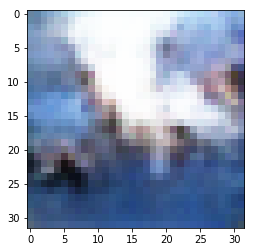

Epoch: [ 3 / 5 ],  Step: [ 650 / 781 ], D_loss:  1.0900323 , G_loss:  1.6120169
Epoch: [ 3 / 5 ],  Step: [ 651 / 781 ], D_loss:  1.063371 , G_loss:  1.1025536
Epoch: [ 3 / 5 ],  Step: [ 652 / 781 ], D_loss:  1.0827696 , G_loss:  1.5194099
Epoch: [ 3 / 5 ],  Step: [ 653 / 781 ], D_loss:  1.1134443 , G_loss:  1.2877041
Epoch: [ 3 / 5 ],  Step: [ 654 / 781 ], D_loss:  1.3216176 , G_loss:  1.4854242
Epoch: [ 3 / 5 ],  Step: [ 655 / 781 ], D_loss:  1.1291834 , G_loss:  1.2056752
Epoch: [ 3 / 5 ],  Step: [ 656 / 781 ], D_loss:  0.99848235 , G_loss:  0.9844288
Epoch: [ 3 / 5 ],  Step: [ 657 / 781 ], D_loss:  0.7397456 , G_loss:  1.3407525
Epoch: [ 3 / 5 ],  Step: [ 658 / 781 ], D_loss:  0.6536417 , G_loss:  1.1981629
Epoch: [ 3 / 5 ],  Step: [ 659 / 781 ], D_loss:  0.746094 , G_loss:  1.1031859
(196, 32, 32, 3)


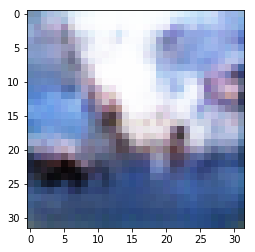

Epoch: [ 3 / 5 ],  Step: [ 660 / 781 ], D_loss:  0.6071185 , G_loss:  1.2947013
Epoch: [ 3 / 5 ],  Step: [ 661 / 781 ], D_loss:  0.71003604 , G_loss:  1.2821934
Epoch: [ 3 / 5 ],  Step: [ 662 / 781 ], D_loss:  0.5556646 , G_loss:  1.260741
Epoch: [ 3 / 5 ],  Step: [ 663 / 781 ], D_loss:  0.57804936 , G_loss:  1.2274084
Epoch: [ 3 / 5 ],  Step: [ 664 / 781 ], D_loss:  0.5410792 , G_loss:  1.1250979
Epoch: [ 3 / 5 ],  Step: [ 665 / 781 ], D_loss:  0.91264665 , G_loss:  1.6290643
Epoch: [ 3 / 5 ],  Step: [ 666 / 781 ], D_loss:  0.93514204 , G_loss:  1.7924796
Epoch: [ 3 / 5 ],  Step: [ 667 / 781 ], D_loss:  0.9366655 , G_loss:  1.3528337
Epoch: [ 3 / 5 ],  Step: [ 668 / 781 ], D_loss:  0.7283694 , G_loss:  1.0186903
Epoch: [ 3 / 5 ],  Step: [ 669 / 781 ], D_loss:  1.4031838 , G_loss:  2.1875737
(196, 32, 32, 3)


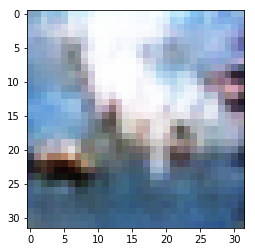

Epoch: [ 3 / 5 ],  Step: [ 670 / 781 ], D_loss:  1.4865793 , G_loss:  2.26925
Epoch: [ 3 / 5 ],  Step: [ 671 / 781 ], D_loss:  1.7387353 , G_loss:  1.5060129
Epoch: [ 3 / 5 ],  Step: [ 672 / 781 ], D_loss:  1.4920703 , G_loss:  0.8308774
Epoch: [ 3 / 5 ],  Step: [ 673 / 781 ], D_loss:  1.4858578 , G_loss:  1.595931
Epoch: [ 3 / 5 ],  Step: [ 674 / 781 ], D_loss:  1.3540417 , G_loss:  1.55614
Epoch: [ 3 / 5 ],  Step: [ 675 / 781 ], D_loss:  1.2884098 , G_loss:  1.0963743
Epoch: [ 3 / 5 ],  Step: [ 676 / 781 ], D_loss:  1.2340688 , G_loss:  1.0786633
Epoch: [ 3 / 5 ],  Step: [ 677 / 781 ], D_loss:  1.041317 , G_loss:  0.97346556
Epoch: [ 3 / 5 ],  Step: [ 678 / 781 ], D_loss:  1.4358621 , G_loss:  1.8405395
Epoch: [ 3 / 5 ],  Step: [ 679 / 781 ], D_loss:  1.2143816 , G_loss:  1.8357081
(196, 32, 32, 3)


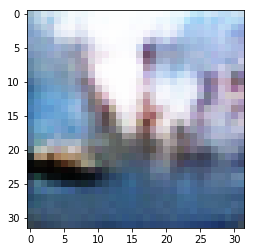

Epoch: [ 3 / 5 ],  Step: [ 680 / 781 ], D_loss:  1.2532204 , G_loss:  1.3200591
Epoch: [ 3 / 5 ],  Step: [ 681 / 781 ], D_loss:  1.1710154 , G_loss:  1.085344
Epoch: [ 3 / 5 ],  Step: [ 682 / 781 ], D_loss:  0.9644118 , G_loss:  1.2658997
Epoch: [ 3 / 5 ],  Step: [ 683 / 781 ], D_loss:  1.0130737 , G_loss:  1.5386088
Epoch: [ 3 / 5 ],  Step: [ 684 / 781 ], D_loss:  0.9653125 , G_loss:  1.3268825
Epoch: [ 3 / 5 ],  Step: [ 685 / 781 ], D_loss:  1.0126492 , G_loss:  1.0709301
Epoch: [ 3 / 5 ],  Step: [ 686 / 781 ], D_loss:  0.9510077 , G_loss:  1.4543211
Epoch: [ 3 / 5 ],  Step: [ 687 / 781 ], D_loss:  1.0874375 , G_loss:  1.5096983
Epoch: [ 3 / 5 ],  Step: [ 688 / 781 ], D_loss:  1.1459775 , G_loss:  1.2631966
Epoch: [ 3 / 5 ],  Step: [ 689 / 781 ], D_loss:  0.85311264 , G_loss:  1.1223788
(196, 32, 32, 3)


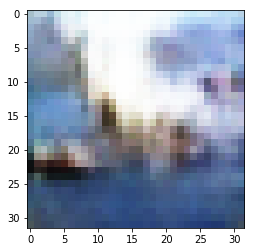

Epoch: [ 3 / 5 ],  Step: [ 690 / 781 ], D_loss:  1.0416439 , G_loss:  1.4154382
Epoch: [ 3 / 5 ],  Step: [ 691 / 781 ], D_loss:  0.951928 , G_loss:  1.1515355
Epoch: [ 3 / 5 ],  Step: [ 692 / 781 ], D_loss:  0.81586933 , G_loss:  1.2645118
Epoch: [ 3 / 5 ],  Step: [ 693 / 781 ], D_loss:  0.9630179 , G_loss:  1.1449177
Epoch: [ 3 / 5 ],  Step: [ 694 / 781 ], D_loss:  0.83070046 , G_loss:  0.9965165
Epoch: [ 3 / 5 ],  Step: [ 695 / 781 ], D_loss:  0.9857032 , G_loss:  1.138413
Epoch: [ 3 / 5 ],  Step: [ 696 / 781 ], D_loss:  0.84255534 , G_loss:  1.2042915
Epoch: [ 3 / 5 ],  Step: [ 697 / 781 ], D_loss:  0.70054287 , G_loss:  1.0534515
Epoch: [ 3 / 5 ],  Step: [ 698 / 781 ], D_loss:  1.0083963 , G_loss:  1.2251537
Epoch: [ 3 / 5 ],  Step: [ 699 / 781 ], D_loss:  0.71804035 , G_loss:  1.2246115
(196, 32, 32, 3)


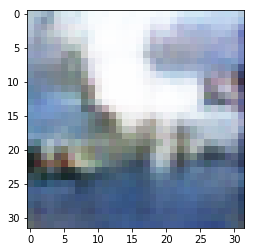

Epoch: [ 3 / 5 ],  Step: [ 700 / 781 ], D_loss:  0.66398925 , G_loss:  1.0388403
Epoch: [ 3 / 5 ],  Step: [ 701 / 781 ], D_loss:  0.597876 , G_loss:  1.0683203
Epoch: [ 3 / 5 ],  Step: [ 702 / 781 ], D_loss:  0.6610506 , G_loss:  1.1883111
Epoch: [ 3 / 5 ],  Step: [ 703 / 781 ], D_loss:  0.5778846 , G_loss:  1.2770642
Epoch: [ 3 / 5 ],  Step: [ 704 / 781 ], D_loss:  0.6552246 , G_loss:  1.0644845
Epoch: [ 3 / 5 ],  Step: [ 705 / 781 ], D_loss:  0.6030112 , G_loss:  0.89399815
Epoch: [ 3 / 5 ],  Step: [ 706 / 781 ], D_loss:  0.7408668 , G_loss:  1.3030205
Epoch: [ 3 / 5 ],  Step: [ 707 / 781 ], D_loss:  0.6894582 , G_loss:  1.2075862
Epoch: [ 3 / 5 ],  Step: [ 708 / 781 ], D_loss:  0.6006143 , G_loss:  1.0435865
Epoch: [ 3 / 5 ],  Step: [ 709 / 781 ], D_loss:  0.47561076 , G_loss:  1.245378
(196, 32, 32, 3)


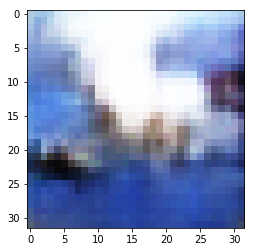

Epoch: [ 3 / 5 ],  Step: [ 710 / 781 ], D_loss:  0.84835625 , G_loss:  1.4118844
Epoch: [ 3 / 5 ],  Step: [ 711 / 781 ], D_loss:  0.82001007 , G_loss:  1.1994165
Epoch: [ 3 / 5 ],  Step: [ 712 / 781 ], D_loss:  0.66372013 , G_loss:  1.1416435
Epoch: [ 3 / 5 ],  Step: [ 713 / 781 ], D_loss:  1.0383327 , G_loss:  1.5701554
Epoch: [ 3 / 5 ],  Step: [ 714 / 781 ], D_loss:  1.1513844 , G_loss:  1.3712205
Epoch: [ 3 / 5 ],  Step: [ 715 / 781 ], D_loss:  1.0829113 , G_loss:  1.2249321
Epoch: [ 3 / 5 ],  Step: [ 716 / 781 ], D_loss:  0.7172055 , G_loss:  1.0221778
Epoch: [ 3 / 5 ],  Step: [ 717 / 781 ], D_loss:  1.6543651 , G_loss:  2.7164567
Epoch: [ 3 / 5 ],  Step: [ 718 / 781 ], D_loss:  1.8990928 , G_loss:  1.8261597
Epoch: [ 3 / 5 ],  Step: [ 719 / 781 ], D_loss:  1.5565273 , G_loss:  0.9154419
(196, 32, 32, 3)


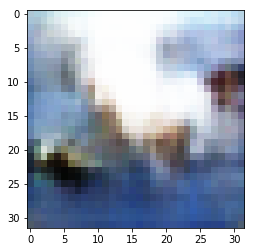

Epoch: [ 3 / 5 ],  Step: [ 720 / 781 ], D_loss:  1.4378388 , G_loss:  1.0450279
Epoch: [ 3 / 5 ],  Step: [ 721 / 781 ], D_loss:  1.423291 , G_loss:  0.9855477
Epoch: [ 3 / 5 ],  Step: [ 722 / 781 ], D_loss:  1.4921178 , G_loss:  1.234252
Epoch: [ 3 / 5 ],  Step: [ 723 / 781 ], D_loss:  1.4572079 , G_loss:  1.0922387
Epoch: [ 3 / 5 ],  Step: [ 724 / 781 ], D_loss:  1.4035288 , G_loss:  1.1681244
Epoch: [ 3 / 5 ],  Step: [ 725 / 781 ], D_loss:  1.2235086 , G_loss:  0.83063483
Epoch: [ 3 / 5 ],  Step: [ 726 / 781 ], D_loss:  1.2741638 , G_loss:  1.0012125
Epoch: [ 3 / 5 ],  Step: [ 727 / 781 ], D_loss:  1.2964214 , G_loss:  1.102122
Epoch: [ 3 / 5 ],  Step: [ 728 / 781 ], D_loss:  1.3861898 , G_loss:  1.0604427
Epoch: [ 3 / 5 ],  Step: [ 729 / 781 ], D_loss:  1.3324568 , G_loss:  1.2985265
(196, 32, 32, 3)


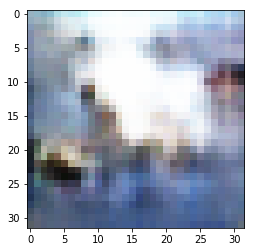

Epoch: [ 3 / 5 ],  Step: [ 730 / 781 ], D_loss:  1.3064156 , G_loss:  1.1646564
Epoch: [ 3 / 5 ],  Step: [ 731 / 781 ], D_loss:  1.2194734 , G_loss:  0.97825885
Epoch: [ 3 / 5 ],  Step: [ 732 / 781 ], D_loss:  1.0444494 , G_loss:  0.9674524
Epoch: [ 3 / 5 ],  Step: [ 733 / 781 ], D_loss:  1.2629293 , G_loss:  1.3419461
Epoch: [ 3 / 5 ],  Step: [ 734 / 781 ], D_loss:  1.4164165 , G_loss:  1.3599759
Epoch: [ 3 / 5 ],  Step: [ 735 / 781 ], D_loss:  1.1472603 , G_loss:  1.0094295
Epoch: [ 3 / 5 ],  Step: [ 736 / 781 ], D_loss:  1.016699 , G_loss:  0.80095154
Epoch: [ 3 / 5 ],  Step: [ 737 / 781 ], D_loss:  1.4581819 , G_loss:  1.933629
Epoch: [ 3 / 5 ],  Step: [ 738 / 781 ], D_loss:  1.496971 , G_loss:  1.9905227
Epoch: [ 3 / 5 ],  Step: [ 739 / 781 ], D_loss:  1.353678 , G_loss:  1.4788579
(196, 32, 32, 3)


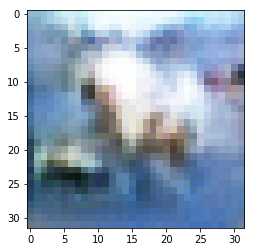

Epoch: [ 3 / 5 ],  Step: [ 740 / 781 ], D_loss:  1.2065855 , G_loss:  0.95289755
Epoch: [ 3 / 5 ],  Step: [ 741 / 781 ], D_loss:  1.3122202 , G_loss:  1.0499556
Epoch: [ 3 / 5 ],  Step: [ 742 / 781 ], D_loss:  1.2378695 , G_loss:  1.1602947
Epoch: [ 3 / 5 ],  Step: [ 743 / 781 ], D_loss:  0.9517863 , G_loss:  0.99085355
Epoch: [ 3 / 5 ],  Step: [ 744 / 781 ], D_loss:  0.7001747 , G_loss:  0.9275317
Epoch: [ 3 / 5 ],  Step: [ 745 / 781 ], D_loss:  0.9271958 , G_loss:  1.3028729
Epoch: [ 3 / 5 ],  Step: [ 746 / 781 ], D_loss:  0.7539755 , G_loss:  1.1218433
Epoch: [ 3 / 5 ],  Step: [ 747 / 781 ], D_loss:  0.6910839 , G_loss:  1.1707807
Epoch: [ 3 / 5 ],  Step: [ 748 / 781 ], D_loss:  0.80565065 , G_loss:  1.2401116
Epoch: [ 3 / 5 ],  Step: [ 749 / 781 ], D_loss:  0.77557755 , G_loss:  1.1775686
(196, 32, 32, 3)


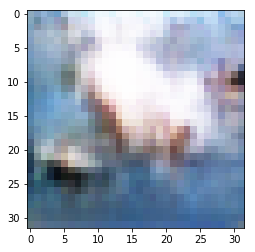

Epoch: [ 3 / 5 ],  Step: [ 750 / 781 ], D_loss:  0.92637 , G_loss:  0.9621457
Epoch: [ 3 / 5 ],  Step: [ 751 / 781 ], D_loss:  1.0789917 , G_loss:  1.3760461
Epoch: [ 3 / 5 ],  Step: [ 752 / 781 ], D_loss:  0.9277246 , G_loss:  1.1557417
Epoch: [ 3 / 5 ],  Step: [ 753 / 781 ], D_loss:  0.81869054 , G_loss:  0.93364906
Epoch: [ 3 / 5 ],  Step: [ 754 / 781 ], D_loss:  0.89242065 , G_loss:  1.4884176
Epoch: [ 3 / 5 ],  Step: [ 755 / 781 ], D_loss:  1.1462774 , G_loss:  1.3327148
Epoch: [ 3 / 5 ],  Step: [ 756 / 781 ], D_loss:  0.88616335 , G_loss:  1.0450333
Epoch: [ 3 / 5 ],  Step: [ 757 / 781 ], D_loss:  1.0819098 , G_loss:  1.2781333
Epoch: [ 3 / 5 ],  Step: [ 758 / 781 ], D_loss:  0.9046773 , G_loss:  1.2810143
Epoch: [ 3 / 5 ],  Step: [ 759 / 781 ], D_loss:  0.8096169 , G_loss:  1.1282563
(196, 32, 32, 3)


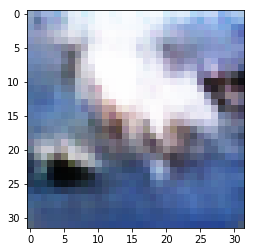

Epoch: [ 3 / 5 ],  Step: [ 760 / 781 ], D_loss:  0.86088026 , G_loss:  1.1052488
Epoch: [ 3 / 5 ],  Step: [ 761 / 781 ], D_loss:  0.9248679 , G_loss:  1.0453622
Epoch: [ 3 / 5 ],  Step: [ 762 / 781 ], D_loss:  0.84798086 , G_loss:  1.089887
Epoch: [ 3 / 5 ],  Step: [ 763 / 781 ], D_loss:  0.7835187 , G_loss:  1.0509539
Epoch: [ 3 / 5 ],  Step: [ 764 / 781 ], D_loss:  0.6895566 , G_loss:  0.9741191
Epoch: [ 3 / 5 ],  Step: [ 765 / 781 ], D_loss:  0.53930604 , G_loss:  1.1358232
Epoch: [ 3 / 5 ],  Step: [ 766 / 781 ], D_loss:  0.7732632 , G_loss:  1.535857
Epoch: [ 3 / 5 ],  Step: [ 767 / 781 ], D_loss:  1.0267571 , G_loss:  1.4687119
Epoch: [ 3 / 5 ],  Step: [ 768 / 781 ], D_loss:  1.033838 , G_loss:  1.0712225
Epoch: [ 3 / 5 ],  Step: [ 769 / 781 ], D_loss:  0.7768874 , G_loss:  0.96598965
(196, 32, 32, 3)


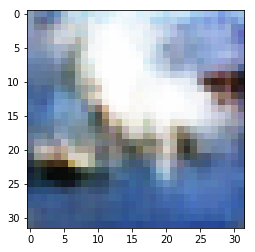

Epoch: [ 3 / 5 ],  Step: [ 770 / 781 ], D_loss:  0.6020908 , G_loss:  1.1182923
Epoch: [ 3 / 5 ],  Step: [ 771 / 781 ], D_loss:  0.9369172 , G_loss:  1.3808887
Epoch: [ 3 / 5 ],  Step: [ 772 / 781 ], D_loss:  1.0600736 , G_loss:  1.0890815
Epoch: [ 3 / 5 ],  Step: [ 773 / 781 ], D_loss:  0.6835438 , G_loss:  1.2130507
Epoch: [ 3 / 5 ],  Step: [ 774 / 781 ], D_loss:  1.4999281 , G_loss:  2.390301
Epoch: [ 3 / 5 ],  Step: [ 775 / 781 ], D_loss:  1.6650283 , G_loss:  2.363031
Epoch: [ 3 / 5 ],  Step: [ 776 / 781 ], D_loss:  1.8913372 , G_loss:  1.8179779
Epoch: [ 3 / 5 ],  Step: [ 777 / 781 ], D_loss:  1.4778451 , G_loss:  1.205104
Epoch: [ 3 / 5 ],  Step: [ 778 / 781 ], D_loss:  1.7662277 , G_loss:  1.6574886
Epoch: [ 3 / 5 ],  Step: [ 779 / 781 ], D_loss:  1.540446 , G_loss:  1.4681169
(196, 32, 32, 3)


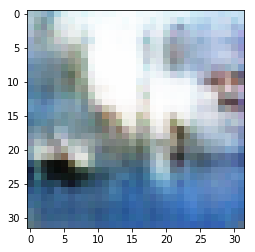

Epoch: [ 3 / 5 ],  Step: [ 780 / 781 ], D_loss:  1.4076127 , G_loss:  1.215574
Epoch: [ 4 / 5 ],  Step: [ 0 / 781 ], D_loss:  1.3698632 , G_loss:  1.010982
(196, 32, 32, 3)


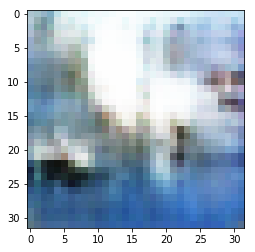

Epoch: [ 4 / 5 ],  Step: [ 1 / 781 ], D_loss:  1.37328 , G_loss:  1.0536107
Epoch: [ 4 / 5 ],  Step: [ 2 / 781 ], D_loss:  1.2428691 , G_loss:  1.1036636
Epoch: [ 4 / 5 ],  Step: [ 3 / 781 ], D_loss:  1.1804496 , G_loss:  1.1265754
Epoch: [ 4 / 5 ],  Step: [ 4 / 781 ], D_loss:  1.1465148 , G_loss:  0.9218168
Epoch: [ 4 / 5 ],  Step: [ 5 / 781 ], D_loss:  1.0533626 , G_loss:  1.0080128
Epoch: [ 4 / 5 ],  Step: [ 6 / 781 ], D_loss:  0.911407 , G_loss:  1.0995294
Epoch: [ 4 / 5 ],  Step: [ 7 / 781 ], D_loss:  0.79346335 , G_loss:  1.0571777
Epoch: [ 4 / 5 ],  Step: [ 8 / 781 ], D_loss:  0.87222123 , G_loss:  0.9895046
Epoch: [ 4 / 5 ],  Step: [ 9 / 781 ], D_loss:  0.6974475 , G_loss:  0.98215795
(196, 32, 32, 3)


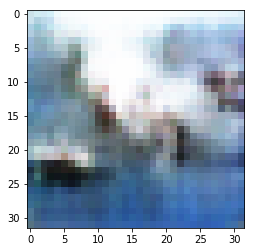

Epoch: [ 4 / 5 ],  Step: [ 10 / 781 ], D_loss:  0.7035747 , G_loss:  1.1327229
Epoch: [ 4 / 5 ],  Step: [ 11 / 781 ], D_loss:  0.7106195 , G_loss:  1.198089
Epoch: [ 4 / 5 ],  Step: [ 12 / 781 ], D_loss:  0.6607317 , G_loss:  1.1217477
Epoch: [ 4 / 5 ],  Step: [ 13 / 781 ], D_loss:  0.63742846 , G_loss:  1.1259623
Epoch: [ 4 / 5 ],  Step: [ 14 / 781 ], D_loss:  0.60599095 , G_loss:  1.2042606
Epoch: [ 4 / 5 ],  Step: [ 15 / 781 ], D_loss:  0.69767773 , G_loss:  1.1304133
Epoch: [ 4 / 5 ],  Step: [ 16 / 781 ], D_loss:  0.68035495 , G_loss:  1.0811899
Epoch: [ 4 / 5 ],  Step: [ 17 / 781 ], D_loss:  0.6243412 , G_loss:  1.1680244
Epoch: [ 4 / 5 ],  Step: [ 18 / 781 ], D_loss:  0.73041475 , G_loss:  1.0310974
Epoch: [ 4 / 5 ],  Step: [ 19 / 781 ], D_loss:  0.62296015 , G_loss:  1.1508073
(196, 32, 32, 3)


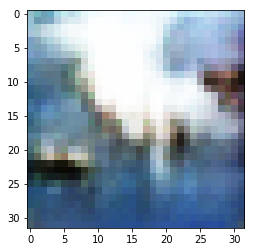

Epoch: [ 4 / 5 ],  Step: [ 20 / 781 ], D_loss:  0.6411283 , G_loss:  1.1875597
Epoch: [ 4 / 5 ],  Step: [ 21 / 781 ], D_loss:  0.6658181 , G_loss:  1.2264822
Epoch: [ 4 / 5 ],  Step: [ 22 / 781 ], D_loss:  0.5834284 , G_loss:  1.0634181
Epoch: [ 4 / 5 ],  Step: [ 23 / 781 ], D_loss:  0.6128297 , G_loss:  1.0398438
Epoch: [ 4 / 5 ],  Step: [ 24 / 781 ], D_loss:  0.6639337 , G_loss:  1.0312631
Epoch: [ 4 / 5 ],  Step: [ 25 / 781 ], D_loss:  0.7702404 , G_loss:  1.3726733
Epoch: [ 4 / 5 ],  Step: [ 26 / 781 ], D_loss:  0.72523 , G_loss:  1.2843435
Epoch: [ 4 / 5 ],  Step: [ 27 / 781 ], D_loss:  0.7964897 , G_loss:  1.1060375
Epoch: [ 4 / 5 ],  Step: [ 28 / 781 ], D_loss:  0.9608788 , G_loss:  1.204363
Epoch: [ 4 / 5 ],  Step: [ 29 / 781 ], D_loss:  0.86785895 , G_loss:  1.274857
(196, 32, 32, 3)


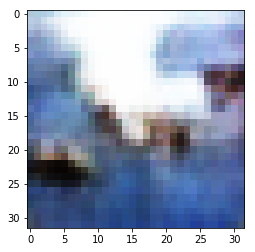

Epoch: [ 4 / 5 ],  Step: [ 30 / 781 ], D_loss:  0.80049556 , G_loss:  1.226847
Epoch: [ 4 / 5 ],  Step: [ 31 / 781 ], D_loss:  1.1030102 , G_loss:  1.3575642
Epoch: [ 4 / 5 ],  Step: [ 32 / 781 ], D_loss:  0.9546148 , G_loss:  1.0067205
Epoch: [ 4 / 5 ],  Step: [ 33 / 781 ], D_loss:  0.75144506 , G_loss:  0.9396452
Epoch: [ 4 / 5 ],  Step: [ 34 / 781 ], D_loss:  0.5102831 , G_loss:  1.1417572
Epoch: [ 4 / 5 ],  Step: [ 35 / 781 ], D_loss:  0.9256032 , G_loss:  1.7195221
Epoch: [ 4 / 5 ],  Step: [ 36 / 781 ], D_loss:  1.1789783 , G_loss:  1.5689553
Epoch: [ 4 / 5 ],  Step: [ 37 / 781 ], D_loss:  0.987505 , G_loss:  1.0384364
Epoch: [ 4 / 5 ],  Step: [ 38 / 781 ], D_loss:  1.0788583 , G_loss:  1.9396311
Epoch: [ 4 / 5 ],  Step: [ 39 / 781 ], D_loss:  1.266363 , G_loss:  1.8035297
(196, 32, 32, 3)


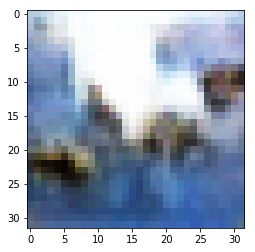

Epoch: [ 4 / 5 ],  Step: [ 40 / 781 ], D_loss:  1.3594612 , G_loss:  1.3028507
Epoch: [ 4 / 5 ],  Step: [ 41 / 781 ], D_loss:  1.0000902 , G_loss:  0.78629273
Epoch: [ 4 / 5 ],  Step: [ 42 / 781 ], D_loss:  1.7879624 , G_loss:  1.8564346
Epoch: [ 4 / 5 ],  Step: [ 43 / 781 ], D_loss:  1.1138923 , G_loss:  1.7065114
Epoch: [ 4 / 5 ],  Step: [ 44 / 781 ], D_loss:  1.0481325 , G_loss:  1.2630248
Epoch: [ 4 / 5 ],  Step: [ 45 / 781 ], D_loss:  1.0171391 , G_loss:  0.9726144
Epoch: [ 4 / 5 ],  Step: [ 46 / 781 ], D_loss:  1.1069688 , G_loss:  1.6067476
Epoch: [ 4 / 5 ],  Step: [ 47 / 781 ], D_loss:  1.2038469 , G_loss:  1.3372071
Epoch: [ 4 / 5 ],  Step: [ 48 / 781 ], D_loss:  1.2393522 , G_loss:  1.1841893
Epoch: [ 4 / 5 ],  Step: [ 49 / 781 ], D_loss:  1.206458 , G_loss:  1.1340898
(196, 32, 32, 3)


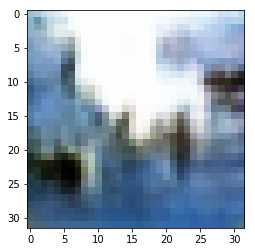

Epoch: [ 4 / 5 ],  Step: [ 50 / 781 ], D_loss:  1.1088068 , G_loss:  1.1569681
Epoch: [ 4 / 5 ],  Step: [ 51 / 781 ], D_loss:  1.0528132 , G_loss:  1.1847209
Epoch: [ 4 / 5 ],  Step: [ 52 / 781 ], D_loss:  1.0402908 , G_loss:  1.0633922
Epoch: [ 4 / 5 ],  Step: [ 53 / 781 ], D_loss:  1.0720577 , G_loss:  1.3281488
Epoch: [ 4 / 5 ],  Step: [ 54 / 781 ], D_loss:  0.9558692 , G_loss:  1.0687857
Epoch: [ 4 / 5 ],  Step: [ 55 / 781 ], D_loss:  0.81431496 , G_loss:  1.1188861
Epoch: [ 4 / 5 ],  Step: [ 56 / 781 ], D_loss:  1.0207238 , G_loss:  1.3269787
Epoch: [ 4 / 5 ],  Step: [ 57 / 781 ], D_loss:  0.89866877 , G_loss:  1.2942783
Epoch: [ 4 / 5 ],  Step: [ 58 / 781 ], D_loss:  0.8979422 , G_loss:  1.0212628
Epoch: [ 4 / 5 ],  Step: [ 59 / 781 ], D_loss:  0.86933964 , G_loss:  1.3208805
(196, 32, 32, 3)


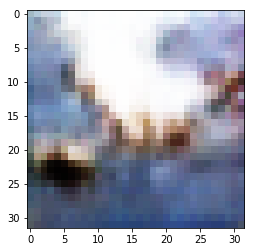

Epoch: [ 4 / 5 ],  Step: [ 60 / 781 ], D_loss:  0.84478796 , G_loss:  1.044227
Epoch: [ 4 / 5 ],  Step: [ 61 / 781 ], D_loss:  0.6450115 , G_loss:  1.1729115
Epoch: [ 4 / 5 ],  Step: [ 62 / 781 ], D_loss:  0.85677916 , G_loss:  1.2354717
Epoch: [ 4 / 5 ],  Step: [ 63 / 781 ], D_loss:  0.84090704 , G_loss:  1.1617196
Epoch: [ 4 / 5 ],  Step: [ 64 / 781 ], D_loss:  0.70020914 , G_loss:  0.99566615
Epoch: [ 4 / 5 ],  Step: [ 65 / 781 ], D_loss:  0.70874286 , G_loss:  1.4623007
Epoch: [ 4 / 5 ],  Step: [ 66 / 781 ], D_loss:  0.683496 , G_loss:  1.5810822
Epoch: [ 4 / 5 ],  Step: [ 67 / 781 ], D_loss:  0.8031351 , G_loss:  0.9956949
Epoch: [ 4 / 5 ],  Step: [ 68 / 781 ], D_loss:  0.6151451 , G_loss:  1.0463505
Epoch: [ 4 / 5 ],  Step: [ 69 / 781 ], D_loss:  0.78170043 , G_loss:  1.3265431
(196, 32, 32, 3)


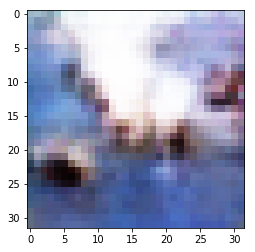

Epoch: [ 4 / 5 ],  Step: [ 70 / 781 ], D_loss:  0.8881181 , G_loss:  1.1557436
Epoch: [ 4 / 5 ],  Step: [ 71 / 781 ], D_loss:  0.826881 , G_loss:  0.8599363
Epoch: [ 4 / 5 ],  Step: [ 72 / 781 ], D_loss:  0.52311826 , G_loss:  1.2678379
Epoch: [ 4 / 5 ],  Step: [ 73 / 781 ], D_loss:  0.9660259 , G_loss:  1.7058402
Epoch: [ 4 / 5 ],  Step: [ 74 / 781 ], D_loss:  0.92532206 , G_loss:  1.3664529
Epoch: [ 4 / 5 ],  Step: [ 75 / 781 ], D_loss:  0.9825169 , G_loss:  0.7140528
Epoch: [ 4 / 5 ],  Step: [ 76 / 781 ], D_loss:  1.2143693 , G_loss:  1.7785125
Epoch: [ 4 / 5 ],  Step: [ 77 / 781 ], D_loss:  1.1063353 , G_loss:  1.4534645
Epoch: [ 4 / 5 ],  Step: [ 78 / 781 ], D_loss:  1.2562497 , G_loss:  1.04757
Epoch: [ 4 / 5 ],  Step: [ 79 / 781 ], D_loss:  1.1027329 , G_loss:  1.1800969
(196, 32, 32, 3)


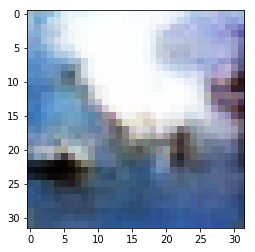

Epoch: [ 4 / 5 ],  Step: [ 80 / 781 ], D_loss:  1.0042098 , G_loss:  0.8908799
Epoch: [ 4 / 5 ],  Step: [ 81 / 781 ], D_loss:  2.0058513 , G_loss:  2.869179
Epoch: [ 4 / 5 ],  Step: [ 82 / 781 ], D_loss:  2.1664042 , G_loss:  2.5637057
Epoch: [ 4 / 5 ],  Step: [ 83 / 781 ], D_loss:  2.2204225 , G_loss:  1.7169968
Epoch: [ 4 / 5 ],  Step: [ 84 / 781 ], D_loss:  1.6719942 , G_loss:  1.1390549
Epoch: [ 4 / 5 ],  Step: [ 85 / 781 ], D_loss:  1.4779493 , G_loss:  0.8261588
Epoch: [ 4 / 5 ],  Step: [ 86 / 781 ], D_loss:  1.2254484 , G_loss:  0.9372685
Epoch: [ 4 / 5 ],  Step: [ 87 / 781 ], D_loss:  1.3592325 , G_loss:  1.1746695
Epoch: [ 4 / 5 ],  Step: [ 88 / 781 ], D_loss:  1.3402457 , G_loss:  1.0497763
Epoch: [ 4 / 5 ],  Step: [ 89 / 781 ], D_loss:  1.2965887 , G_loss:  0.9469439
(196, 32, 32, 3)


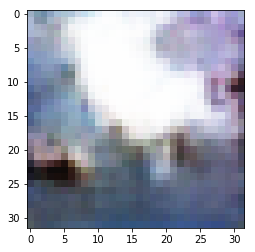

Epoch: [ 4 / 5 ],  Step: [ 90 / 781 ], D_loss:  1.244959 , G_loss:  1.0892365
Epoch: [ 4 / 5 ],  Step: [ 91 / 781 ], D_loss:  1.261194 , G_loss:  1.0921866
Epoch: [ 4 / 5 ],  Step: [ 92 / 781 ], D_loss:  1.1833069 , G_loss:  1.0149202
Epoch: [ 4 / 5 ],  Step: [ 93 / 781 ], D_loss:  1.087456 , G_loss:  0.86283755
Epoch: [ 4 / 5 ],  Step: [ 94 / 781 ], D_loss:  1.2219148 , G_loss:  1.1138473
Epoch: [ 4 / 5 ],  Step: [ 95 / 781 ], D_loss:  1.2808534 , G_loss:  1.034687
Epoch: [ 4 / 5 ],  Step: [ 96 / 781 ], D_loss:  1.2731477 , G_loss:  0.8729565
Epoch: [ 4 / 5 ],  Step: [ 97 / 781 ], D_loss:  1.1706483 , G_loss:  0.99533665
Epoch: [ 4 / 5 ],  Step: [ 98 / 781 ], D_loss:  1.1269927 , G_loss:  1.0037498
Epoch: [ 4 / 5 ],  Step: [ 99 / 781 ], D_loss:  1.148726 , G_loss:  0.8479023
(196, 32, 32, 3)


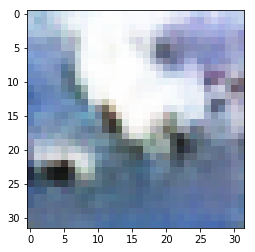

Epoch: [ 4 / 5 ],  Step: [ 100 / 781 ], D_loss:  1.1078976 , G_loss:  1.2729242
Epoch: [ 4 / 5 ],  Step: [ 101 / 781 ], D_loss:  1.1222997 , G_loss:  1.1998435
Epoch: [ 4 / 5 ],  Step: [ 102 / 781 ], D_loss:  1.1489774 , G_loss:  0.9931727
Epoch: [ 4 / 5 ],  Step: [ 103 / 781 ], D_loss:  1.2335901 , G_loss:  1.0300457
Epoch: [ 4 / 5 ],  Step: [ 104 / 781 ], D_loss:  1.1320387 , G_loss:  1.0501292
Epoch: [ 4 / 5 ],  Step: [ 105 / 781 ], D_loss:  1.0644865 , G_loss:  1.0576934
Epoch: [ 4 / 5 ],  Step: [ 106 / 781 ], D_loss:  1.0763303 , G_loss:  0.9458351
Epoch: [ 4 / 5 ],  Step: [ 107 / 781 ], D_loss:  1.2789556 , G_loss:  1.0242848
Epoch: [ 4 / 5 ],  Step: [ 108 / 781 ], D_loss:  1.1086354 , G_loss:  0.98496836
Epoch: [ 4 / 5 ],  Step: [ 109 / 781 ], D_loss:  0.96496546 , G_loss:  1.1466782
(196, 32, 32, 3)


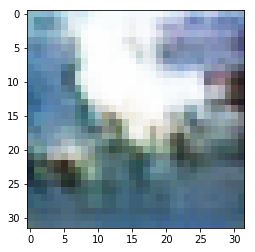

Epoch: [ 4 / 5 ],  Step: [ 110 / 781 ], D_loss:  0.991446 , G_loss:  1.0672283
Epoch: [ 4 / 5 ],  Step: [ 111 / 781 ], D_loss:  1.0784836 , G_loss:  1.0220935
Epoch: [ 4 / 5 ],  Step: [ 112 / 781 ], D_loss:  1.0859326 , G_loss:  1.0833228
Epoch: [ 4 / 5 ],  Step: [ 113 / 781 ], D_loss:  0.8812549 , G_loss:  1.0245521
Epoch: [ 4 / 5 ],  Step: [ 114 / 781 ], D_loss:  0.8804623 , G_loss:  0.8166187
Epoch: [ 4 / 5 ],  Step: [ 115 / 781 ], D_loss:  1.1192992 , G_loss:  1.5439711
Epoch: [ 4 / 5 ],  Step: [ 116 / 781 ], D_loss:  1.1949995 , G_loss:  1.384914
Epoch: [ 4 / 5 ],  Step: [ 117 / 781 ], D_loss:  1.179251 , G_loss:  1.0550637
Epoch: [ 4 / 5 ],  Step: [ 118 / 781 ], D_loss:  1.1112487 , G_loss:  1.1061665
Epoch: [ 4 / 5 ],  Step: [ 119 / 781 ], D_loss:  1.1029373 , G_loss:  0.9410744
(196, 32, 32, 3)


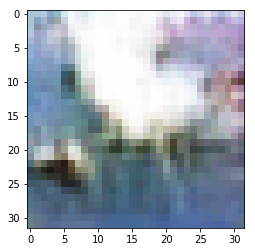

Epoch: [ 4 / 5 ],  Step: [ 120 / 781 ], D_loss:  1.1848838 , G_loss:  1.139354
Epoch: [ 4 / 5 ],  Step: [ 121 / 781 ], D_loss:  1.1327711 , G_loss:  1.0741465
Epoch: [ 4 / 5 ],  Step: [ 122 / 781 ], D_loss:  1.0231824 , G_loss:  0.8951267
Epoch: [ 4 / 5 ],  Step: [ 123 / 781 ], D_loss:  0.93907166 , G_loss:  1.185498
Epoch: [ 4 / 5 ],  Step: [ 124 / 781 ], D_loss:  0.8785792 , G_loss:  1.1816149
Epoch: [ 4 / 5 ],  Step: [ 125 / 781 ], D_loss:  0.9928786 , G_loss:  0.99318343
Epoch: [ 4 / 5 ],  Step: [ 126 / 781 ], D_loss:  0.74231493 , G_loss:  1.0014337
Epoch: [ 4 / 5 ],  Step: [ 127 / 781 ], D_loss:  0.56313473 , G_loss:  1.1273894
Epoch: [ 4 / 5 ],  Step: [ 128 / 781 ], D_loss:  0.8600333 , G_loss:  1.5985849
Epoch: [ 4 / 5 ],  Step: [ 129 / 781 ], D_loss:  1.1485169 , G_loss:  1.5976942
(196, 32, 32, 3)


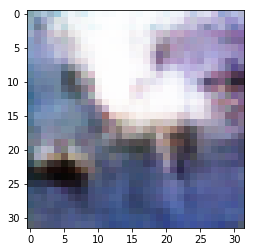

Epoch: [ 4 / 5 ],  Step: [ 130 / 781 ], D_loss:  0.83881974 , G_loss:  1.2689533
Epoch: [ 4 / 5 ],  Step: [ 131 / 781 ], D_loss:  1.0031577 , G_loss:  1.0506352
Epoch: [ 4 / 5 ],  Step: [ 132 / 781 ], D_loss:  0.85883963 , G_loss:  1.2298344
Epoch: [ 4 / 5 ],  Step: [ 133 / 781 ], D_loss:  0.7123988 , G_loss:  1.0539603
Epoch: [ 4 / 5 ],  Step: [ 134 / 781 ], D_loss:  1.1723888 , G_loss:  1.3795867
Epoch: [ 4 / 5 ],  Step: [ 135 / 781 ], D_loss:  0.8787747 , G_loss:  1.0547069
Epoch: [ 4 / 5 ],  Step: [ 136 / 781 ], D_loss:  0.8487554 , G_loss:  1.0727748
Epoch: [ 4 / 5 ],  Step: [ 137 / 781 ], D_loss:  0.8696336 , G_loss:  1.0036422
Epoch: [ 4 / 5 ],  Step: [ 138 / 781 ], D_loss:  0.686769 , G_loss:  1.388755
Epoch: [ 4 / 5 ],  Step: [ 139 / 781 ], D_loss:  0.7284645 , G_loss:  1.1058075
(196, 32, 32, 3)


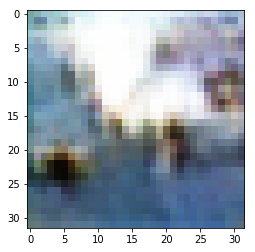

Epoch: [ 4 / 5 ],  Step: [ 140 / 781 ], D_loss:  0.9204502 , G_loss:  1.0373912
Epoch: [ 4 / 5 ],  Step: [ 141 / 781 ], D_loss:  0.7283809 , G_loss:  1.020021
Epoch: [ 4 / 5 ],  Step: [ 142 / 781 ], D_loss:  0.5100056 , G_loss:  1.1053933
Epoch: [ 4 / 5 ],  Step: [ 143 / 781 ], D_loss:  1.272371 , G_loss:  2.0465338
Epoch: [ 4 / 5 ],  Step: [ 144 / 781 ], D_loss:  1.4186331 , G_loss:  1.8860351
Epoch: [ 4 / 5 ],  Step: [ 145 / 781 ], D_loss:  1.2243887 , G_loss:  1.3875856
Epoch: [ 4 / 5 ],  Step: [ 146 / 781 ], D_loss:  1.2348623 , G_loss:  0.8343916
Epoch: [ 4 / 5 ],  Step: [ 147 / 781 ], D_loss:  1.0307448 , G_loss:  1.1095722
Epoch: [ 4 / 5 ],  Step: [ 148 / 781 ], D_loss:  0.9898444 , G_loss:  0.8957964
Epoch: [ 4 / 5 ],  Step: [ 149 / 781 ], D_loss:  1.1899378 , G_loss:  1.6606704
(196, 32, 32, 3)


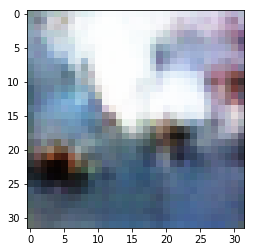

Epoch: [ 4 / 5 ],  Step: [ 150 / 781 ], D_loss:  1.2681899 , G_loss:  1.5981684
Epoch: [ 4 / 5 ],  Step: [ 151 / 781 ], D_loss:  1.2122592 , G_loss:  1.2090356
Epoch: [ 4 / 5 ],  Step: [ 152 / 781 ], D_loss:  0.90767395 , G_loss:  0.99373645
Epoch: [ 4 / 5 ],  Step: [ 153 / 781 ], D_loss:  1.1542513 , G_loss:  1.419796
Epoch: [ 4 / 5 ],  Step: [ 154 / 781 ], D_loss:  0.81124246 , G_loss:  1.13042
Epoch: [ 4 / 5 ],  Step: [ 155 / 781 ], D_loss:  0.9625714 , G_loss:  1.0843662
Epoch: [ 4 / 5 ],  Step: [ 156 / 781 ], D_loss:  0.89517945 , G_loss:  1.1836156
Epoch: [ 4 / 5 ],  Step: [ 157 / 781 ], D_loss:  0.78106725 , G_loss:  1.1797934
Epoch: [ 4 / 5 ],  Step: [ 158 / 781 ], D_loss:  0.7548771 , G_loss:  1.2326107
Epoch: [ 4 / 5 ],  Step: [ 159 / 781 ], D_loss:  0.6918269 , G_loss:  1.1154729
(196, 32, 32, 3)


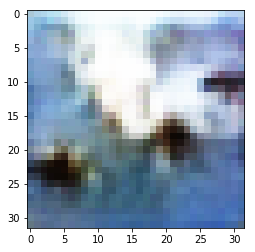

Epoch: [ 4 / 5 ],  Step: [ 160 / 781 ], D_loss:  0.78557885 , G_loss:  1.1904767
Epoch: [ 4 / 5 ],  Step: [ 161 / 781 ], D_loss:  0.5998749 , G_loss:  1.3062276
Epoch: [ 4 / 5 ],  Step: [ 162 / 781 ], D_loss:  0.92046225 , G_loss:  1.3269855
Epoch: [ 4 / 5 ],  Step: [ 163 / 781 ], D_loss:  0.74837255 , G_loss:  1.505446
Epoch: [ 4 / 5 ],  Step: [ 164 / 781 ], D_loss:  0.7744473 , G_loss:  0.8358067
Epoch: [ 4 / 5 ],  Step: [ 165 / 781 ], D_loss:  0.5325028 , G_loss:  1.2996548
Epoch: [ 4 / 5 ],  Step: [ 166 / 781 ], D_loss:  0.9219599 , G_loss:  1.5749176
Epoch: [ 4 / 5 ],  Step: [ 167 / 781 ], D_loss:  0.75655717 , G_loss:  1.4318266
Epoch: [ 4 / 5 ],  Step: [ 168 / 781 ], D_loss:  0.82153666 , G_loss:  1.3030818
Epoch: [ 4 / 5 ],  Step: [ 169 / 781 ], D_loss:  0.65090656 , G_loss:  1.2782637
(196, 32, 32, 3)


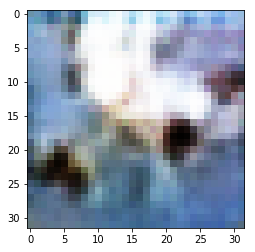

Epoch: [ 4 / 5 ],  Step: [ 170 / 781 ], D_loss:  0.689628 , G_loss:  1.2690108
Epoch: [ 4 / 5 ],  Step: [ 171 / 781 ], D_loss:  0.7260486 , G_loss:  1.4205916
Epoch: [ 4 / 5 ],  Step: [ 172 / 781 ], D_loss:  0.71255165 , G_loss:  1.1544068
Epoch: [ 4 / 5 ],  Step: [ 173 / 781 ], D_loss:  0.8606701 , G_loss:  0.73094773
Epoch: [ 4 / 5 ],  Step: [ 174 / 781 ], D_loss:  0.6475252 , G_loss:  1.2767411
Epoch: [ 4 / 5 ],  Step: [ 175 / 781 ], D_loss:  1.0057366 , G_loss:  1.66711
Epoch: [ 4 / 5 ],  Step: [ 176 / 781 ], D_loss:  1.1224798 , G_loss:  1.6884588
Epoch: [ 4 / 5 ],  Step: [ 177 / 781 ], D_loss:  0.9834795 , G_loss:  1.2662351
Epoch: [ 4 / 5 ],  Step: [ 178 / 781 ], D_loss:  0.80525964 , G_loss:  1.1635506
Epoch: [ 4 / 5 ],  Step: [ 179 / 781 ], D_loss:  0.67589945 , G_loss:  1.1880901
(196, 32, 32, 3)


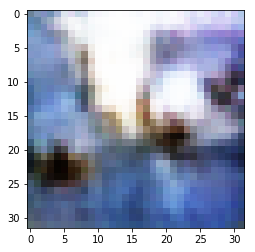

Epoch: [ 4 / 5 ],  Step: [ 180 / 781 ], D_loss:  0.76283884 , G_loss:  1.2229686
Epoch: [ 4 / 5 ],  Step: [ 181 / 781 ], D_loss:  0.6270157 , G_loss:  1.2897602
Epoch: [ 4 / 5 ],  Step: [ 182 / 781 ], D_loss:  0.88404983 , G_loss:  1.0255822
Epoch: [ 4 / 5 ],  Step: [ 183 / 781 ], D_loss:  0.6818116 , G_loss:  1.1645696
Epoch: [ 4 / 5 ],  Step: [ 184 / 781 ], D_loss:  0.6445035 , G_loss:  1.1412392
Epoch: [ 4 / 5 ],  Step: [ 185 / 781 ], D_loss:  0.7610983 , G_loss:  1.0814652
Epoch: [ 4 / 5 ],  Step: [ 186 / 781 ], D_loss:  0.63147694 , G_loss:  1.0097897
Epoch: [ 4 / 5 ],  Step: [ 187 / 781 ], D_loss:  0.6541362 , G_loss:  0.9866228
Epoch: [ 4 / 5 ],  Step: [ 188 / 781 ], D_loss:  0.56802183 , G_loss:  1.4227356
Epoch: [ 4 / 5 ],  Step: [ 189 / 781 ], D_loss:  0.8415071 , G_loss:  1.0201249
(196, 32, 32, 3)


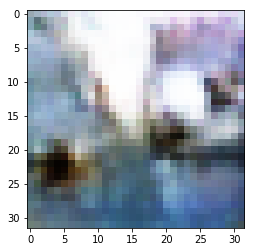

Epoch: [ 4 / 5 ],  Step: [ 190 / 781 ], D_loss:  0.55130416 , G_loss:  1.2729056
Epoch: [ 4 / 5 ],  Step: [ 191 / 781 ], D_loss:  0.643896 , G_loss:  1.1580994
Epoch: [ 4 / 5 ],  Step: [ 192 / 781 ], D_loss:  0.5086983 , G_loss:  1.1172185
Epoch: [ 4 / 5 ],  Step: [ 193 / 781 ], D_loss:  0.66319776 , G_loss:  1.2215568
Epoch: [ 4 / 5 ],  Step: [ 194 / 781 ], D_loss:  0.5460717 , G_loss:  1.3069966
Epoch: [ 4 / 5 ],  Step: [ 195 / 781 ], D_loss:  0.7071938 , G_loss:  1.1561563
Epoch: [ 4 / 5 ],  Step: [ 196 / 781 ], D_loss:  0.9625651 , G_loss:  0.8468023
Epoch: [ 4 / 5 ],  Step: [ 197 / 781 ], D_loss:  0.61169446 , G_loss:  0.8501085
Epoch: [ 4 / 5 ],  Step: [ 198 / 781 ], D_loss:  0.6533749 , G_loss:  1.3636625
Epoch: [ 4 / 5 ],  Step: [ 199 / 781 ], D_loss:  0.7464611 , G_loss:  1.6600757
(196, 32, 32, 3)


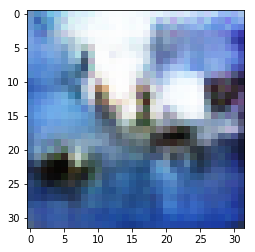

Epoch: [ 4 / 5 ],  Step: [ 200 / 781 ], D_loss:  1.0185685 , G_loss:  1.8874958
Epoch: [ 4 / 5 ],  Step: [ 201 / 781 ], D_loss:  1.0606523 , G_loss:  1.1739445
Epoch: [ 4 / 5 ],  Step: [ 202 / 781 ], D_loss:  0.5029222 , G_loss:  1.3385333
Epoch: [ 4 / 5 ],  Step: [ 203 / 781 ], D_loss:  0.8910012 , G_loss:  1.6399294
Epoch: [ 4 / 5 ],  Step: [ 204 / 781 ], D_loss:  0.7561486 , G_loss:  1.5778856
Epoch: [ 4 / 5 ],  Step: [ 205 / 781 ], D_loss:  0.7289917 , G_loss:  1.0072246
Epoch: [ 4 / 5 ],  Step: [ 206 / 781 ], D_loss:  0.60322404 , G_loss:  1.3277836
Epoch: [ 4 / 5 ],  Step: [ 207 / 781 ], D_loss:  0.7556904 , G_loss:  1.5190308
Epoch: [ 4 / 5 ],  Step: [ 208 / 781 ], D_loss:  0.88863623 , G_loss:  1.6996925
Epoch: [ 4 / 5 ],  Step: [ 209 / 781 ], D_loss:  0.83962405 , G_loss:  0.81492686
(196, 32, 32, 3)


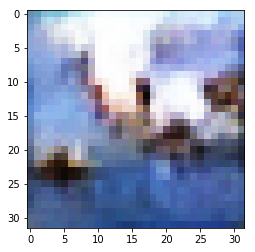

Epoch: [ 4 / 5 ],  Step: [ 210 / 781 ], D_loss:  0.5987381 , G_loss:  1.1876478
Epoch: [ 4 / 5 ],  Step: [ 211 / 781 ], D_loss:  0.97023684 , G_loss:  2.0070586
Epoch: [ 4 / 5 ],  Step: [ 212 / 781 ], D_loss:  1.1175941 , G_loss:  1.5868906
Epoch: [ 4 / 5 ],  Step: [ 213 / 781 ], D_loss:  1.1874247 , G_loss:  0.8091533
Epoch: [ 4 / 5 ],  Step: [ 214 / 781 ], D_loss:  1.5373782 , G_loss:  2.1158943
Epoch: [ 4 / 5 ],  Step: [ 215 / 781 ], D_loss:  1.7016675 , G_loss:  2.0246465
Epoch: [ 4 / 5 ],  Step: [ 216 / 781 ], D_loss:  1.5545236 , G_loss:  1.3937383
Epoch: [ 4 / 5 ],  Step: [ 217 / 781 ], D_loss:  1.2607434 , G_loss:  1.0179238
Epoch: [ 4 / 5 ],  Step: [ 218 / 781 ], D_loss:  1.1446981 , G_loss:  2.1015146
Epoch: [ 4 / 5 ],  Step: [ 219 / 781 ], D_loss:  1.551467 , G_loss:  1.6939615
(196, 32, 32, 3)


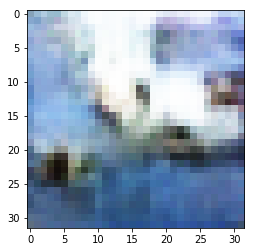

Epoch: [ 4 / 5 ],  Step: [ 220 / 781 ], D_loss:  1.2701876 , G_loss:  1.011479
Epoch: [ 4 / 5 ],  Step: [ 221 / 781 ], D_loss:  1.2685931 , G_loss:  1.2867255
Epoch: [ 4 / 5 ],  Step: [ 222 / 781 ], D_loss:  1.1386659 , G_loss:  1.3074031
Epoch: [ 4 / 5 ],  Step: [ 223 / 781 ], D_loss:  0.9993716 , G_loss:  1.3138974
Epoch: [ 4 / 5 ],  Step: [ 224 / 781 ], D_loss:  0.9089587 , G_loss:  1.0176768
Epoch: [ 4 / 5 ],  Step: [ 225 / 781 ], D_loss:  0.86907655 , G_loss:  1.3316753
Epoch: [ 4 / 5 ],  Step: [ 226 / 781 ], D_loss:  0.87177104 , G_loss:  1.0794961
Epoch: [ 4 / 5 ],  Step: [ 227 / 781 ], D_loss:  0.535032 , G_loss:  1.1058823
Epoch: [ 4 / 5 ],  Step: [ 228 / 781 ], D_loss:  0.9204421 , G_loss:  1.6528234
Epoch: [ 4 / 5 ],  Step: [ 229 / 781 ], D_loss:  1.1649712 , G_loss:  1.4072932
(196, 32, 32, 3)


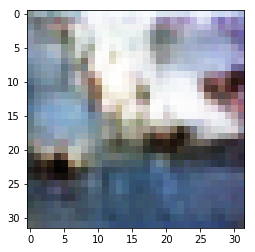

Epoch: [ 4 / 5 ],  Step: [ 230 / 781 ], D_loss:  1.0431867 , G_loss:  0.885644
Epoch: [ 4 / 5 ],  Step: [ 231 / 781 ], D_loss:  1.3295002 , G_loss:  1.6768429
Epoch: [ 4 / 5 ],  Step: [ 232 / 781 ], D_loss:  1.072139 , G_loss:  1.5057526
Epoch: [ 4 / 5 ],  Step: [ 233 / 781 ], D_loss:  1.2910224 , G_loss:  1.2605436
Epoch: [ 4 / 5 ],  Step: [ 234 / 781 ], D_loss:  1.2428889 , G_loss:  1.2724998
Epoch: [ 4 / 5 ],  Step: [ 235 / 781 ], D_loss:  0.87423366 , G_loss:  1.0650496
Epoch: [ 4 / 5 ],  Step: [ 236 / 781 ], D_loss:  1.3157047 , G_loss:  2.1921134
Epoch: [ 4 / 5 ],  Step: [ 237 / 781 ], D_loss:  1.2789233 , G_loss:  2.1403902
Epoch: [ 4 / 5 ],  Step: [ 238 / 781 ], D_loss:  1.3457848 , G_loss:  1.4253762
Epoch: [ 4 / 5 ],  Step: [ 239 / 781 ], D_loss:  1.2032126 , G_loss:  0.9205314
(196, 32, 32, 3)


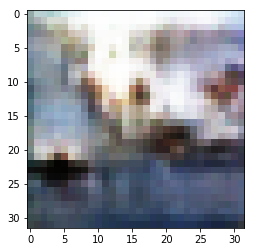

Epoch: [ 4 / 5 ],  Step: [ 240 / 781 ], D_loss:  1.379479 , G_loss:  1.9742552
Epoch: [ 4 / 5 ],  Step: [ 241 / 781 ], D_loss:  1.5779862 , G_loss:  1.6356901
Epoch: [ 4 / 5 ],  Step: [ 242 / 781 ], D_loss:  1.528282 , G_loss:  1.2454243
Epoch: [ 4 / 5 ],  Step: [ 243 / 781 ], D_loss:  1.64595 , G_loss:  1.1914476
Epoch: [ 4 / 5 ],  Step: [ 244 / 781 ], D_loss:  1.1804206 , G_loss:  1.1193123
Epoch: [ 4 / 5 ],  Step: [ 245 / 781 ], D_loss:  1.019538 , G_loss:  1.284656
Epoch: [ 4 / 5 ],  Step: [ 246 / 781 ], D_loss:  0.9683054 , G_loss:  1.1894766
Epoch: [ 4 / 5 ],  Step: [ 247 / 781 ], D_loss:  0.62425625 , G_loss:  1.1072582
Epoch: [ 4 / 5 ],  Step: [ 248 / 781 ], D_loss:  1.0958987 , G_loss:  1.8853754
Epoch: [ 4 / 5 ],  Step: [ 249 / 781 ], D_loss:  1.3326759 , G_loss:  1.7604953
(196, 32, 32, 3)


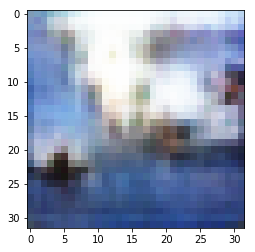

Epoch: [ 4 / 5 ],  Step: [ 250 / 781 ], D_loss:  1.2157845 , G_loss:  1.2993416
Epoch: [ 4 / 5 ],  Step: [ 251 / 781 ], D_loss:  1.0986445 , G_loss:  0.87408334
Epoch: [ 4 / 5 ],  Step: [ 252 / 781 ], D_loss:  1.537771 , G_loss:  1.7926067
Epoch: [ 4 / 5 ],  Step: [ 253 / 781 ], D_loss:  1.2627487 , G_loss:  1.7299889
Epoch: [ 4 / 5 ],  Step: [ 254 / 781 ], D_loss:  1.1190766 , G_loss:  1.2895133
Epoch: [ 4 / 5 ],  Step: [ 255 / 781 ], D_loss:  1.0968195 , G_loss:  1.085738
Epoch: [ 4 / 5 ],  Step: [ 256 / 781 ], D_loss:  0.82132936 , G_loss:  1.0750978
Epoch: [ 4 / 5 ],  Step: [ 257 / 781 ], D_loss:  1.2476099 , G_loss:  1.5682687
Epoch: [ 4 / 5 ],  Step: [ 258 / 781 ], D_loss:  1.370365 , G_loss:  1.5390234
Epoch: [ 4 / 5 ],  Step: [ 259 / 781 ], D_loss:  1.1509485 , G_loss:  1.3197864
(196, 32, 32, 3)


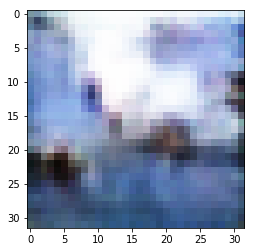

Epoch: [ 4 / 5 ],  Step: [ 260 / 781 ], D_loss:  1.4476521 , G_loss:  1.7929021
Epoch: [ 4 / 5 ],  Step: [ 261 / 781 ], D_loss:  1.377636 , G_loss:  1.5310974
Epoch: [ 4 / 5 ],  Step: [ 262 / 781 ], D_loss:  1.2448559 , G_loss:  1.1544967
Epoch: [ 4 / 5 ],  Step: [ 263 / 781 ], D_loss:  0.85710514 , G_loss:  1.1356581
Epoch: [ 4 / 5 ],  Step: [ 264 / 781 ], D_loss:  1.0330254 , G_loss:  1.3345983
Epoch: [ 4 / 5 ],  Step: [ 265 / 781 ], D_loss:  0.86805624 , G_loss:  1.1794705
Epoch: [ 4 / 5 ],  Step: [ 266 / 781 ], D_loss:  0.9498628 , G_loss:  0.9942312
Epoch: [ 4 / 5 ],  Step: [ 267 / 781 ], D_loss:  0.65084076 , G_loss:  1.371157
Epoch: [ 4 / 5 ],  Step: [ 268 / 781 ], D_loss:  0.6048771 , G_loss:  1.0400844
Epoch: [ 4 / 5 ],  Step: [ 269 / 781 ], D_loss:  0.6633283 , G_loss:  1.1638476
(196, 32, 32, 3)


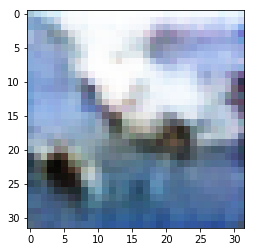

Epoch: [ 4 / 5 ],  Step: [ 270 / 781 ], D_loss:  0.5516601 , G_loss:  1.1209047
Epoch: [ 4 / 5 ],  Step: [ 271 / 781 ], D_loss:  0.85684884 , G_loss:  1.5009321
Epoch: [ 4 / 5 ],  Step: [ 272 / 781 ], D_loss:  0.89906514 , G_loss:  1.7241333
Epoch: [ 4 / 5 ],  Step: [ 273 / 781 ], D_loss:  1.0642233 , G_loss:  0.93635255
Epoch: [ 4 / 5 ],  Step: [ 274 / 781 ], D_loss:  0.6334216 , G_loss:  1.0451889
Epoch: [ 4 / 5 ],  Step: [ 275 / 781 ], D_loss:  1.5377599 , G_loss:  2.0369306
Epoch: [ 4 / 5 ],  Step: [ 276 / 781 ], D_loss:  1.3490947 , G_loss:  2.097688
Epoch: [ 4 / 5 ],  Step: [ 277 / 781 ], D_loss:  1.272939 , G_loss:  1.3323793
Epoch: [ 4 / 5 ],  Step: [ 278 / 781 ], D_loss:  0.9655715 , G_loss:  0.6493468
Epoch: [ 4 / 5 ],  Step: [ 279 / 781 ], D_loss:  1.338337 , G_loss:  2.0299988
(196, 32, 32, 3)


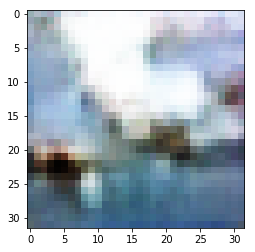

Epoch: [ 4 / 5 ],  Step: [ 280 / 781 ], D_loss:  1.4284502 , G_loss:  1.9936385
Epoch: [ 4 / 5 ],  Step: [ 281 / 781 ], D_loss:  1.2326431 , G_loss:  1.7225262
Epoch: [ 4 / 5 ],  Step: [ 282 / 781 ], D_loss:  1.1271473 , G_loss:  0.9942242
Epoch: [ 4 / 5 ],  Step: [ 283 / 781 ], D_loss:  0.9670081 , G_loss:  1.0580497
Epoch: [ 4 / 5 ],  Step: [ 284 / 781 ], D_loss:  1.3736532 , G_loss:  2.2665393
Epoch: [ 4 / 5 ],  Step: [ 285 / 781 ], D_loss:  1.5112258 , G_loss:  2.1560147
Epoch: [ 4 / 5 ],  Step: [ 286 / 781 ], D_loss:  1.4969922 , G_loss:  1.379307
Epoch: [ 4 / 5 ],  Step: [ 287 / 781 ], D_loss:  1.2655777 , G_loss:  0.96997917
Epoch: [ 4 / 5 ],  Step: [ 288 / 781 ], D_loss:  1.1193874 , G_loss:  1.1812333
Epoch: [ 4 / 5 ],  Step: [ 289 / 781 ], D_loss:  1.1088411 , G_loss:  1.0135074
(196, 32, 32, 3)


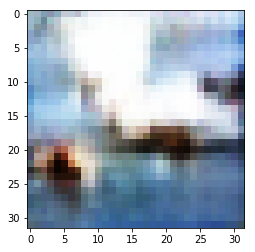

Epoch: [ 4 / 5 ],  Step: [ 290 / 781 ], D_loss:  0.9920918 , G_loss:  0.91920936
Epoch: [ 4 / 5 ],  Step: [ 291 / 781 ], D_loss:  1.2788043 , G_loss:  1.5157871
Epoch: [ 4 / 5 ],  Step: [ 292 / 781 ], D_loss:  1.3398497 , G_loss:  1.4000281
Epoch: [ 4 / 5 ],  Step: [ 293 / 781 ], D_loss:  1.0061303 , G_loss:  0.95060575
Epoch: [ 4 / 5 ],  Step: [ 294 / 781 ], D_loss:  1.270386 , G_loss:  1.1738815
Epoch: [ 4 / 5 ],  Step: [ 295 / 781 ], D_loss:  0.94820136 , G_loss:  1.257351
Epoch: [ 4 / 5 ],  Step: [ 296 / 781 ], D_loss:  0.99821866 , G_loss:  1.1020951
Epoch: [ 4 / 5 ],  Step: [ 297 / 781 ], D_loss:  0.76450115 , G_loss:  1.073098
Epoch: [ 4 / 5 ],  Step: [ 298 / 781 ], D_loss:  0.8280865 , G_loss:  0.98822355
Epoch: [ 4 / 5 ],  Step: [ 299 / 781 ], D_loss:  0.8012172 , G_loss:  1.141825
(196, 32, 32, 3)


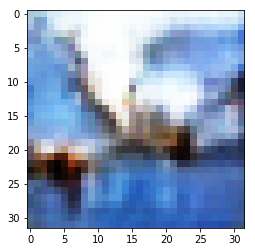

Epoch: [ 4 / 5 ],  Step: [ 300 / 781 ], D_loss:  0.5666353 , G_loss:  1.0344367
Epoch: [ 4 / 5 ],  Step: [ 301 / 781 ], D_loss:  0.7602391 , G_loss:  1.2557493
Epoch: [ 4 / 5 ],  Step: [ 302 / 781 ], D_loss:  0.63752073 , G_loss:  1.1453804
Epoch: [ 4 / 5 ],  Step: [ 303 / 781 ], D_loss:  0.5926705 , G_loss:  1.1826293
Epoch: [ 4 / 5 ],  Step: [ 304 / 781 ], D_loss:  0.6452783 , G_loss:  1.0743152
Epoch: [ 4 / 5 ],  Step: [ 305 / 781 ], D_loss:  0.49673557 , G_loss:  1.2989876
Epoch: [ 4 / 5 ],  Step: [ 306 / 781 ], D_loss:  0.5631432 , G_loss:  1.1088618
Epoch: [ 4 / 5 ],  Step: [ 307 / 781 ], D_loss:  0.6038982 , G_loss:  1.0802387
Epoch: [ 4 / 5 ],  Step: [ 308 / 781 ], D_loss:  0.7395138 , G_loss:  1.1358814
Epoch: [ 4 / 5 ],  Step: [ 309 / 781 ], D_loss:  0.71651506 , G_loss:  1.0631818
(196, 32, 32, 3)


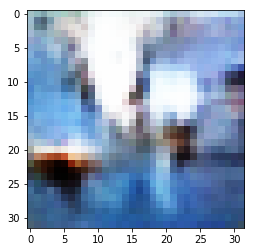

Epoch: [ 4 / 5 ],  Step: [ 310 / 781 ], D_loss:  0.96416974 , G_loss:  1.0015415
Epoch: [ 4 / 5 ],  Step: [ 311 / 781 ], D_loss:  0.61402863 , G_loss:  1.1861246
Epoch: [ 4 / 5 ],  Step: [ 312 / 781 ], D_loss:  0.7144369 , G_loss:  1.0144664
Epoch: [ 4 / 5 ],  Step: [ 313 / 781 ], D_loss:  0.63815343 , G_loss:  0.94284034
Epoch: [ 4 / 5 ],  Step: [ 314 / 781 ], D_loss:  0.73226523 , G_loss:  1.2533047
Epoch: [ 4 / 5 ],  Step: [ 315 / 781 ], D_loss:  0.6892409 , G_loss:  1.1856409
Epoch: [ 4 / 5 ],  Step: [ 316 / 781 ], D_loss:  0.8454048 , G_loss:  0.9389781
Epoch: [ 4 / 5 ],  Step: [ 317 / 781 ], D_loss:  0.48078492 , G_loss:  1.1485499
Epoch: [ 4 / 5 ],  Step: [ 318 / 781 ], D_loss:  0.803732 , G_loss:  1.1710377
Epoch: [ 4 / 5 ],  Step: [ 319 / 781 ], D_loss:  0.90760297 , G_loss:  1.1923237
(196, 32, 32, 3)


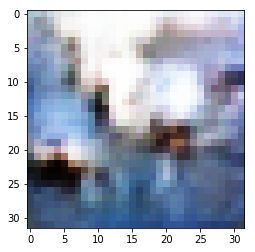

Epoch: [ 4 / 5 ],  Step: [ 320 / 781 ], D_loss:  0.8041155 , G_loss:  1.0215638
Epoch: [ 4 / 5 ],  Step: [ 321 / 781 ], D_loss:  0.6978098 , G_loss:  1.2127821
Epoch: [ 4 / 5 ],  Step: [ 322 / 781 ], D_loss:  0.83366245 , G_loss:  0.7552476
Epoch: [ 4 / 5 ],  Step: [ 323 / 781 ], D_loss:  0.60031587 , G_loss:  1.1590728
Epoch: [ 4 / 5 ],  Step: [ 324 / 781 ], D_loss:  0.89378476 , G_loss:  1.7847146
Epoch: [ 4 / 5 ],  Step: [ 325 / 781 ], D_loss:  1.1661017 , G_loss:  1.9232354
Epoch: [ 4 / 5 ],  Step: [ 326 / 781 ], D_loss:  1.1423743 , G_loss:  1.2803885
Epoch: [ 4 / 5 ],  Step: [ 327 / 781 ], D_loss:  0.9618985 , G_loss:  0.78403276
Epoch: [ 4 / 5 ],  Step: [ 328 / 781 ], D_loss:  0.934031 , G_loss:  1.27173
Epoch: [ 4 / 5 ],  Step: [ 329 / 781 ], D_loss:  0.8003898 , G_loss:  1.315863
(196, 32, 32, 3)


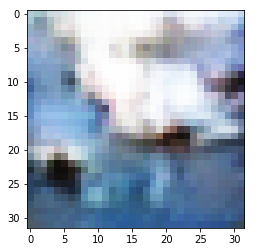

Epoch: [ 4 / 5 ],  Step: [ 330 / 781 ], D_loss:  0.9481056 , G_loss:  1.1139919
Epoch: [ 4 / 5 ],  Step: [ 331 / 781 ], D_loss:  0.8427333 , G_loss:  1.0576296
Epoch: [ 4 / 5 ],  Step: [ 332 / 781 ], D_loss:  0.73490113 , G_loss:  0.98605126
Epoch: [ 4 / 5 ],  Step: [ 333 / 781 ], D_loss:  0.83487064 , G_loss:  0.9475796
Epoch: [ 4 / 5 ],  Step: [ 334 / 781 ], D_loss:  0.45730716 , G_loss:  1.3327004
Epoch: [ 4 / 5 ],  Step: [ 335 / 781 ], D_loss:  0.90553224 , G_loss:  1.274249
Epoch: [ 4 / 5 ],  Step: [ 336 / 781 ], D_loss:  1.0164471 , G_loss:  0.9256462
Epoch: [ 4 / 5 ],  Step: [ 337 / 781 ], D_loss:  0.5219949 , G_loss:  1.1240325
Epoch: [ 4 / 5 ],  Step: [ 338 / 781 ], D_loss:  1.6551425 , G_loss:  2.3286743
Epoch: [ 4 / 5 ],  Step: [ 339 / 781 ], D_loss:  1.8220532 , G_loss:  2.0974076
(196, 32, 32, 3)


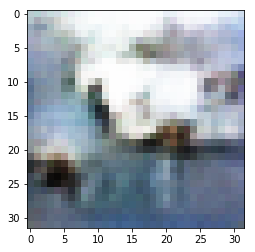

Epoch: [ 4 / 5 ],  Step: [ 340 / 781 ], D_loss:  1.7717131 , G_loss:  1.4157182
Epoch: [ 4 / 5 ],  Step: [ 341 / 781 ], D_loss:  1.5598254 , G_loss:  0.83741266
Epoch: [ 4 / 5 ],  Step: [ 342 / 781 ], D_loss:  1.7744815 , G_loss:  1.5105437
Epoch: [ 4 / 5 ],  Step: [ 343 / 781 ], D_loss:  1.6791732 , G_loss:  1.5425963
Epoch: [ 4 / 5 ],  Step: [ 344 / 781 ], D_loss:  1.657415 , G_loss:  1.168
Epoch: [ 4 / 5 ],  Step: [ 345 / 781 ], D_loss:  1.6477306 , G_loss:  1.1734594
Epoch: [ 4 / 5 ],  Step: [ 346 / 781 ], D_loss:  1.53874 , G_loss:  1.0524722
Epoch: [ 4 / 5 ],  Step: [ 347 / 781 ], D_loss:  1.5391985 , G_loss:  1.1057268
Epoch: [ 4 / 5 ],  Step: [ 348 / 781 ], D_loss:  1.2855977 , G_loss:  1.0115963
Epoch: [ 4 / 5 ],  Step: [ 349 / 781 ], D_loss:  1.4044958 , G_loss:  1.0484312
(196, 32, 32, 3)


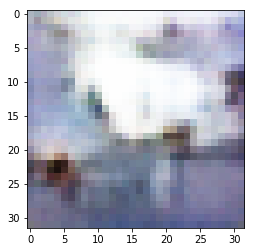

Epoch: [ 4 / 5 ],  Step: [ 350 / 781 ], D_loss:  1.2331675 , G_loss:  0.94534725
Epoch: [ 4 / 5 ],  Step: [ 351 / 781 ], D_loss:  1.2077848 , G_loss:  0.99122083
Epoch: [ 4 / 5 ],  Step: [ 352 / 781 ], D_loss:  1.082732 , G_loss:  0.9861717
Epoch: [ 4 / 5 ],  Step: [ 353 / 781 ], D_loss:  1.148333 , G_loss:  0.8368316
Epoch: [ 4 / 5 ],  Step: [ 354 / 781 ], D_loss:  1.3582698 , G_loss:  1.1806948
Epoch: [ 4 / 5 ],  Step: [ 355 / 781 ], D_loss:  1.2758666 , G_loss:  1.0635328
Epoch: [ 4 / 5 ],  Step: [ 356 / 781 ], D_loss:  1.2894292 , G_loss:  1.0846169
Epoch: [ 4 / 5 ],  Step: [ 357 / 781 ], D_loss:  1.153827 , G_loss:  0.75826865
Epoch: [ 4 / 5 ],  Step: [ 358 / 781 ], D_loss:  1.541828 , G_loss:  1.3487443
Epoch: [ 4 / 5 ],  Step: [ 359 / 781 ], D_loss:  1.3056843 , G_loss:  1.4280286
(196, 32, 32, 3)


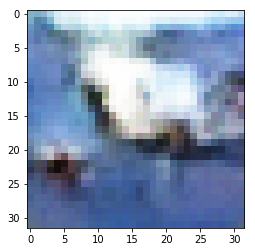

Epoch: [ 4 / 5 ],  Step: [ 360 / 781 ], D_loss:  1.1907032 , G_loss:  0.97607774
Epoch: [ 4 / 5 ],  Step: [ 361 / 781 ], D_loss:  1.4178864 , G_loss:  1.2909658
Epoch: [ 4 / 5 ],  Step: [ 362 / 781 ], D_loss:  1.2351615 , G_loss:  1.415681
Epoch: [ 4 / 5 ],  Step: [ 363 / 781 ], D_loss:  1.3513569 , G_loss:  1.1520449
Epoch: [ 4 / 5 ],  Step: [ 364 / 781 ], D_loss:  1.2359322 , G_loss:  1.0362723
Epoch: [ 4 / 5 ],  Step: [ 365 / 781 ], D_loss:  1.1621817 , G_loss:  1.195317
Epoch: [ 4 / 5 ],  Step: [ 366 / 781 ], D_loss:  1.1451275 , G_loss:  1.0158213
Epoch: [ 4 / 5 ],  Step: [ 367 / 781 ], D_loss:  1.0566212 , G_loss:  0.9711933
Epoch: [ 4 / 5 ],  Step: [ 368 / 781 ], D_loss:  1.1567171 , G_loss:  0.9671434
Epoch: [ 4 / 5 ],  Step: [ 369 / 781 ], D_loss:  0.9993365 , G_loss:  1.0272784
(196, 32, 32, 3)


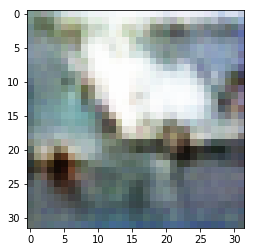

Epoch: [ 4 / 5 ],  Step: [ 370 / 781 ], D_loss:  0.91479903 , G_loss:  0.94094294
Epoch: [ 4 / 5 ],  Step: [ 371 / 781 ], D_loss:  1.080291 , G_loss:  1.0479883
Epoch: [ 4 / 5 ],  Step: [ 372 / 781 ], D_loss:  1.1067034 , G_loss:  0.99067557
Epoch: [ 4 / 5 ],  Step: [ 373 / 781 ], D_loss:  1.0737016 , G_loss:  1.1140232
Epoch: [ 4 / 5 ],  Step: [ 374 / 781 ], D_loss:  1.2060258 , G_loss:  0.92594606
Epoch: [ 4 / 5 ],  Step: [ 375 / 781 ], D_loss:  1.0003686 , G_loss:  0.9277955
Epoch: [ 4 / 5 ],  Step: [ 376 / 781 ], D_loss:  1.055488 , G_loss:  1.4157834
Epoch: [ 4 / 5 ],  Step: [ 377 / 781 ], D_loss:  1.0341748 , G_loss:  1.163116
Epoch: [ 4 / 5 ],  Step: [ 378 / 781 ], D_loss:  0.94409335 , G_loss:  0.84851146
Epoch: [ 4 / 5 ],  Step: [ 379 / 781 ], D_loss:  1.2801138 , G_loss:  1.6170661
(196, 32, 32, 3)


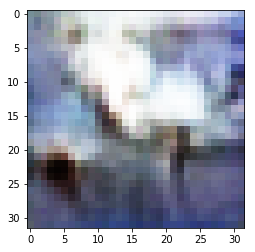

Epoch: [ 4 / 5 ],  Step: [ 380 / 781 ], D_loss:  1.1192584 , G_loss:  1.4430759
Epoch: [ 4 / 5 ],  Step: [ 381 / 781 ], D_loss:  1.1670192 , G_loss:  1.1021664
Epoch: [ 4 / 5 ],  Step: [ 382 / 781 ], D_loss:  0.8570126 , G_loss:  1.1730031
Epoch: [ 4 / 5 ],  Step: [ 383 / 781 ], D_loss:  1.1348915 , G_loss:  1.514702
Epoch: [ 4 / 5 ],  Step: [ 384 / 781 ], D_loss:  1.1105776 , G_loss:  1.6311779
Epoch: [ 4 / 5 ],  Step: [ 385 / 781 ], D_loss:  1.1488413 , G_loss:  1.1473279
Epoch: [ 4 / 5 ],  Step: [ 386 / 781 ], D_loss:  1.2376561 , G_loss:  1.4487716
Epoch: [ 4 / 5 ],  Step: [ 387 / 781 ], D_loss:  1.0503316 , G_loss:  1.1889551
Epoch: [ 4 / 5 ],  Step: [ 388 / 781 ], D_loss:  0.9232905 , G_loss:  0.7587534
Epoch: [ 4 / 5 ],  Step: [ 389 / 781 ], D_loss:  1.0384829 , G_loss:  1.5665283
(196, 32, 32, 3)


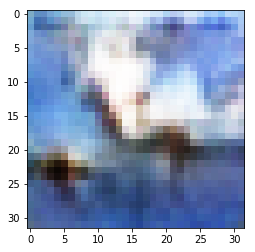

Epoch: [ 4 / 5 ],  Step: [ 390 / 781 ], D_loss:  0.9890024 , G_loss:  1.5787927
Epoch: [ 4 / 5 ],  Step: [ 391 / 781 ], D_loss:  0.8277524 , G_loss:  1.1624676
Epoch: [ 4 / 5 ],  Step: [ 392 / 781 ], D_loss:  1.1095332 , G_loss:  1.3369464
Epoch: [ 4 / 5 ],  Step: [ 393 / 781 ], D_loss:  0.9184024 , G_loss:  1.2595806
Epoch: [ 4 / 5 ],  Step: [ 394 / 781 ], D_loss:  0.9682821 , G_loss:  1.1505051
Epoch: [ 4 / 5 ],  Step: [ 395 / 781 ], D_loss:  0.7709056 , G_loss:  1.2130135
Epoch: [ 4 / 5 ],  Step: [ 396 / 781 ], D_loss:  0.77679485 , G_loss:  1.0671122
Epoch: [ 4 / 5 ],  Step: [ 397 / 781 ], D_loss:  0.75323737 , G_loss:  1.2001284
Epoch: [ 4 / 5 ],  Step: [ 398 / 781 ], D_loss:  0.8408503 , G_loss:  1.1549854
Epoch: [ 4 / 5 ],  Step: [ 399 / 781 ], D_loss:  0.8111037 , G_loss:  1.0357218
(196, 32, 32, 3)


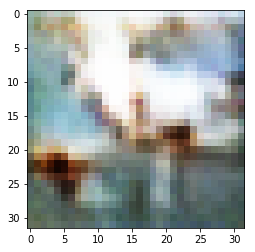

Epoch: [ 4 / 5 ],  Step: [ 400 / 781 ], D_loss:  0.7493457 , G_loss:  1.1804482
Epoch: [ 4 / 5 ],  Step: [ 401 / 781 ], D_loss:  0.8666429 , G_loss:  1.1462724
Epoch: [ 4 / 5 ],  Step: [ 402 / 781 ], D_loss:  0.7453196 , G_loss:  1.012249
Epoch: [ 4 / 5 ],  Step: [ 403 / 781 ], D_loss:  0.70015746 , G_loss:  1.2620426
Epoch: [ 4 / 5 ],  Step: [ 404 / 781 ], D_loss:  0.6116356 , G_loss:  1.1585017
Epoch: [ 4 / 5 ],  Step: [ 405 / 781 ], D_loss:  0.56402117 , G_loss:  0.9599578
Epoch: [ 4 / 5 ],  Step: [ 406 / 781 ], D_loss:  0.72720814 , G_loss:  1.2762089
Epoch: [ 4 / 5 ],  Step: [ 407 / 781 ], D_loss:  0.685435 , G_loss:  1.2834209
Epoch: [ 4 / 5 ],  Step: [ 408 / 781 ], D_loss:  0.90401864 , G_loss:  0.7670305
Epoch: [ 4 / 5 ],  Step: [ 409 / 781 ], D_loss:  0.57260895 , G_loss:  1.1878052
(196, 32, 32, 3)


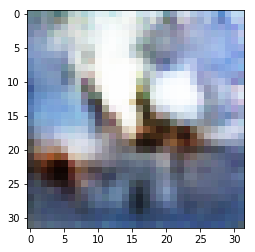

Epoch: [ 4 / 5 ],  Step: [ 410 / 781 ], D_loss:  0.858357 , G_loss:  1.0019739
Epoch: [ 4 / 5 ],  Step: [ 411 / 781 ], D_loss:  0.5903665 , G_loss:  1.2289945
Epoch: [ 4 / 5 ],  Step: [ 412 / 781 ], D_loss:  0.9920894 , G_loss:  1.7661349
Epoch: [ 4 / 5 ],  Step: [ 413 / 781 ], D_loss:  1.1169704 , G_loss:  1.9080569
Epoch: [ 4 / 5 ],  Step: [ 414 / 781 ], D_loss:  1.1716032 , G_loss:  1.4089658
Epoch: [ 4 / 5 ],  Step: [ 415 / 781 ], D_loss:  1.0067843 , G_loss:  0.9377799
Epoch: [ 4 / 5 ],  Step: [ 416 / 781 ], D_loss:  1.2905796 , G_loss:  2.0433493
Epoch: [ 4 / 5 ],  Step: [ 417 / 781 ], D_loss:  1.3987026 , G_loss:  1.8237444
Epoch: [ 4 / 5 ],  Step: [ 418 / 781 ], D_loss:  1.4477342 , G_loss:  1.4381042
Epoch: [ 4 / 5 ],  Step: [ 419 / 781 ], D_loss:  1.3440864 , G_loss:  1.0615695
(196, 32, 32, 3)


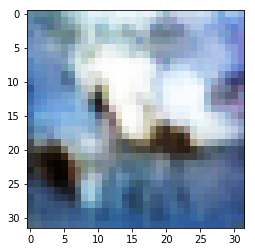

Epoch: [ 4 / 5 ],  Step: [ 420 / 781 ], D_loss:  1.4495426 , G_loss:  1.4284965
Epoch: [ 4 / 5 ],  Step: [ 421 / 781 ], D_loss:  1.24651 , G_loss:  1.42325
Epoch: [ 4 / 5 ],  Step: [ 422 / 781 ], D_loss:  1.2040719 , G_loss:  1.1095866
Epoch: [ 4 / 5 ],  Step: [ 423 / 781 ], D_loss:  1.1583233 , G_loss:  1.0489459
Epoch: [ 4 / 5 ],  Step: [ 424 / 781 ], D_loss:  1.0541431 , G_loss:  1.1057546
Epoch: [ 4 / 5 ],  Step: [ 425 / 781 ], D_loss:  0.95442235 , G_loss:  0.98480976
Epoch: [ 4 / 5 ],  Step: [ 426 / 781 ], D_loss:  0.8010254 , G_loss:  1.0241967
Epoch: [ 4 / 5 ],  Step: [ 427 / 781 ], D_loss:  0.81368065 , G_loss:  1.1957821
Epoch: [ 4 / 5 ],  Step: [ 428 / 781 ], D_loss:  0.6596245 , G_loss:  1.1305708
Epoch: [ 4 / 5 ],  Step: [ 429 / 781 ], D_loss:  0.5904805 , G_loss:  1.047862
(196, 32, 32, 3)


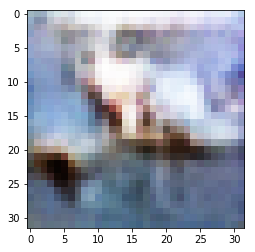

Epoch: [ 4 / 5 ],  Step: [ 430 / 781 ], D_loss:  0.7501823 , G_loss:  1.2496363
Epoch: [ 4 / 5 ],  Step: [ 431 / 781 ], D_loss:  0.7138403 , G_loss:  1.1709609
Epoch: [ 4 / 5 ],  Step: [ 432 / 781 ], D_loss:  0.919073 , G_loss:  1.2805018
Epoch: [ 4 / 5 ],  Step: [ 433 / 781 ], D_loss:  1.1688976 , G_loss:  1.0379543
Epoch: [ 4 / 5 ],  Step: [ 434 / 781 ], D_loss:  1.0616486 , G_loss:  0.8315291
Epoch: [ 4 / 5 ],  Step: [ 435 / 781 ], D_loss:  0.92131656 , G_loss:  1.0405324
Epoch: [ 4 / 5 ],  Step: [ 436 / 781 ], D_loss:  0.95547736 , G_loss:  1.0161057
Epoch: [ 4 / 5 ],  Step: [ 437 / 781 ], D_loss:  0.865667 , G_loss:  1.0595378
Epoch: [ 4 / 5 ],  Step: [ 438 / 781 ], D_loss:  0.86640763 , G_loss:  0.91711557
Epoch: [ 4 / 5 ],  Step: [ 439 / 781 ], D_loss:  0.65063584 , G_loss:  1.1341946
(196, 32, 32, 3)


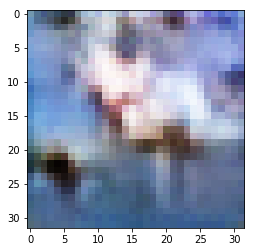

Epoch: [ 4 / 5 ],  Step: [ 440 / 781 ], D_loss:  0.59237266 , G_loss:  1.1441047
Epoch: [ 4 / 5 ],  Step: [ 441 / 781 ], D_loss:  0.97447264 , G_loss:  1.555583
Epoch: [ 4 / 5 ],  Step: [ 442 / 781 ], D_loss:  0.8552372 , G_loss:  1.4058048
Epoch: [ 4 / 5 ],  Step: [ 443 / 781 ], D_loss:  0.71414113 , G_loss:  1.0828851
Epoch: [ 4 / 5 ],  Step: [ 444 / 781 ], D_loss:  1.1239773 , G_loss:  1.6952543
Epoch: [ 4 / 5 ],  Step: [ 445 / 781 ], D_loss:  1.0103415 , G_loss:  1.7845142
Epoch: [ 4 / 5 ],  Step: [ 446 / 781 ], D_loss:  0.96845806 , G_loss:  1.0845678
Epoch: [ 4 / 5 ],  Step: [ 447 / 781 ], D_loss:  0.7135709 , G_loss:  0.970155
Epoch: [ 4 / 5 ],  Step: [ 448 / 781 ], D_loss:  1.0811973 , G_loss:  1.6408677
Epoch: [ 4 / 5 ],  Step: [ 449 / 781 ], D_loss:  1.0587385 , G_loss:  1.782414
(196, 32, 32, 3)


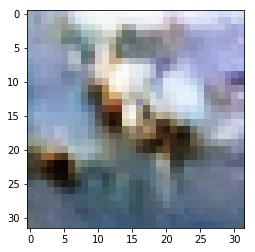

Epoch: [ 4 / 5 ],  Step: [ 450 / 781 ], D_loss:  1.1312243 , G_loss:  1.0375855
Epoch: [ 4 / 5 ],  Step: [ 451 / 781 ], D_loss:  1.250133 , G_loss:  1.4132723
Epoch: [ 4 / 5 ],  Step: [ 452 / 781 ], D_loss:  1.1000525 , G_loss:  1.1340821
Epoch: [ 4 / 5 ],  Step: [ 453 / 781 ], D_loss:  0.8492284 , G_loss:  1.2356722
Epoch: [ 4 / 5 ],  Step: [ 454 / 781 ], D_loss:  1.2286636 , G_loss:  1.4073269
Epoch: [ 4 / 5 ],  Step: [ 455 / 781 ], D_loss:  1.2404616 , G_loss:  1.3304197
Epoch: [ 4 / 5 ],  Step: [ 456 / 781 ], D_loss:  0.9560088 , G_loss:  0.8032266
Epoch: [ 4 / 5 ],  Step: [ 457 / 781 ], D_loss:  0.7816742 , G_loss:  0.99307156
Epoch: [ 4 / 5 ],  Step: [ 458 / 781 ], D_loss:  0.73650837 , G_loss:  1.4057579
Epoch: [ 4 / 5 ],  Step: [ 459 / 781 ], D_loss:  0.7221322 , G_loss:  1.221458
(196, 32, 32, 3)


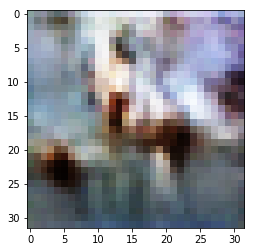

Epoch: [ 4 / 5 ],  Step: [ 460 / 781 ], D_loss:  0.76894313 , G_loss:  1.0637788
Epoch: [ 4 / 5 ],  Step: [ 461 / 781 ], D_loss:  0.51763225 , G_loss:  1.1752387
Epoch: [ 4 / 5 ],  Step: [ 462 / 781 ], D_loss:  1.0322149 , G_loss:  1.5812099
Epoch: [ 4 / 5 ],  Step: [ 463 / 781 ], D_loss:  1.0415878 , G_loss:  1.7710546
Epoch: [ 4 / 5 ],  Step: [ 464 / 781 ], D_loss:  0.78911436 , G_loss:  1.4143798
Epoch: [ 4 / 5 ],  Step: [ 465 / 781 ], D_loss:  0.7655359 , G_loss:  1.0607389
Epoch: [ 4 / 5 ],  Step: [ 466 / 781 ], D_loss:  1.272801 , G_loss:  2.0671716
Epoch: [ 4 / 5 ],  Step: [ 467 / 781 ], D_loss:  1.3407841 , G_loss:  1.7640449
Epoch: [ 4 / 5 ],  Step: [ 468 / 781 ], D_loss:  1.1824439 , G_loss:  1.1592869
Epoch: [ 4 / 5 ],  Step: [ 469 / 781 ], D_loss:  1.1728328 , G_loss:  0.75485706
(196, 32, 32, 3)


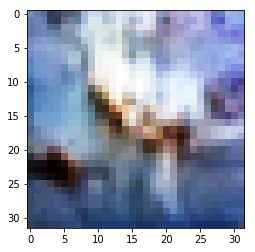

Epoch: [ 4 / 5 ],  Step: [ 470 / 781 ], D_loss:  1.3531004 , G_loss:  1.6609045
Epoch: [ 4 / 5 ],  Step: [ 471 / 781 ], D_loss:  1.4659123 , G_loss:  1.8262924
Epoch: [ 4 / 5 ],  Step: [ 472 / 781 ], D_loss:  1.4406317 , G_loss:  1.4210894
Epoch: [ 4 / 5 ],  Step: [ 473 / 781 ], D_loss:  1.2645029 , G_loss:  0.9353975
Epoch: [ 4 / 5 ],  Step: [ 474 / 781 ], D_loss:  1.3812398 , G_loss:  1.3158385
Epoch: [ 4 / 5 ],  Step: [ 475 / 781 ], D_loss:  1.1471161 , G_loss:  1.4267353
Epoch: [ 4 / 5 ],  Step: [ 476 / 781 ], D_loss:  1.0144439 , G_loss:  1.1106889
Epoch: [ 4 / 5 ],  Step: [ 477 / 781 ], D_loss:  0.96499634 , G_loss:  1.1007444
Epoch: [ 4 / 5 ],  Step: [ 478 / 781 ], D_loss:  0.9388296 , G_loss:  1.0279889
Epoch: [ 4 / 5 ],  Step: [ 479 / 781 ], D_loss:  0.92555106 , G_loss:  1.5409251
(196, 32, 32, 3)


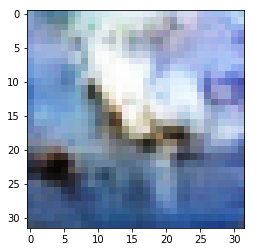

Epoch: [ 4 / 5 ],  Step: [ 480 / 781 ], D_loss:  1.0275941 , G_loss:  1.1896639
Epoch: [ 4 / 5 ],  Step: [ 481 / 781 ], D_loss:  0.86556894 , G_loss:  0.7915332
Epoch: [ 4 / 5 ],  Step: [ 482 / 781 ], D_loss:  0.8024548 , G_loss:  1.3392816
Epoch: [ 4 / 5 ],  Step: [ 483 / 781 ], D_loss:  0.96940345 , G_loss:  1.1838574
Epoch: [ 4 / 5 ],  Step: [ 484 / 781 ], D_loss:  0.9211099 , G_loss:  0.97396654
Epoch: [ 4 / 5 ],  Step: [ 485 / 781 ], D_loss:  0.8149741 , G_loss:  1.2019452
Epoch: [ 4 / 5 ],  Step: [ 486 / 781 ], D_loss:  0.5832801 , G_loss:  1.2891339
Epoch: [ 4 / 5 ],  Step: [ 487 / 781 ], D_loss:  0.6611346 , G_loss:  1.1668382
Epoch: [ 4 / 5 ],  Step: [ 488 / 781 ], D_loss:  1.0024272 , G_loss:  1.2368805
Epoch: [ 4 / 5 ],  Step: [ 489 / 781 ], D_loss:  0.7949779 , G_loss:  1.3386177
(196, 32, 32, 3)


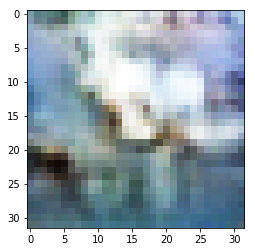

Epoch: [ 4 / 5 ],  Step: [ 490 / 781 ], D_loss:  0.55509365 , G_loss:  1.131402
Epoch: [ 4 / 5 ],  Step: [ 491 / 781 ], D_loss:  0.7859917 , G_loss:  1.2637728
Epoch: [ 4 / 5 ],  Step: [ 492 / 781 ], D_loss:  0.5472332 , G_loss:  1.3555576
Epoch: [ 4 / 5 ],  Step: [ 493 / 781 ], D_loss:  0.79825884 , G_loss:  1.3559036
Epoch: [ 4 / 5 ],  Step: [ 494 / 781 ], D_loss:  0.6577446 , G_loss:  1.3067151
Epoch: [ 4 / 5 ],  Step: [ 495 / 781 ], D_loss:  0.6279211 , G_loss:  1.1620586
Epoch: [ 4 / 5 ],  Step: [ 496 / 781 ], D_loss:  0.95207965 , G_loss:  1.5866294
Epoch: [ 4 / 5 ],  Step: [ 497 / 781 ], D_loss:  1.2166003 , G_loss:  1.3526447
Epoch: [ 4 / 5 ],  Step: [ 498 / 781 ], D_loss:  1.0092909 , G_loss:  0.826204
Epoch: [ 4 / 5 ],  Step: [ 499 / 781 ], D_loss:  0.8043072 , G_loss:  1.1077298
(196, 32, 32, 3)


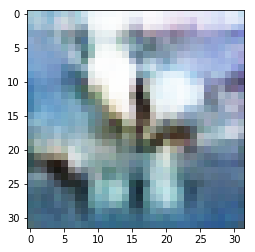

Epoch: [ 4 / 5 ],  Step: [ 500 / 781 ], D_loss:  0.8554922 , G_loss:  1.9420937
Epoch: [ 4 / 5 ],  Step: [ 501 / 781 ], D_loss:  1.2613095 , G_loss:  1.7646453
Epoch: [ 4 / 5 ],  Step: [ 502 / 781 ], D_loss:  1.1817232 , G_loss:  1.2210183
Epoch: [ 4 / 5 ],  Step: [ 503 / 781 ], D_loss:  0.9700755 , G_loss:  0.6937981
Epoch: [ 4 / 5 ],  Step: [ 504 / 781 ], D_loss:  1.3935847 , G_loss:  1.8298912
Epoch: [ 4 / 5 ],  Step: [ 505 / 781 ], D_loss:  1.337679 , G_loss:  1.5412405
Epoch: [ 4 / 5 ],  Step: [ 506 / 781 ], D_loss:  1.3090837 , G_loss:  0.93504703
Epoch: [ 4 / 5 ],  Step: [ 507 / 781 ], D_loss:  1.3411096 , G_loss:  1.3199288
Epoch: [ 4 / 5 ],  Step: [ 508 / 781 ], D_loss:  1.4419858 , G_loss:  1.3646016
Epoch: [ 4 / 5 ],  Step: [ 509 / 781 ], D_loss:  1.3490796 , G_loss:  1.305377
(196, 32, 32, 3)


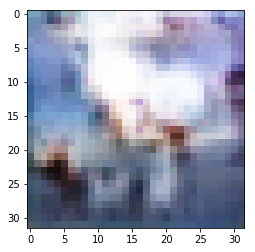

Epoch: [ 4 / 5 ],  Step: [ 510 / 781 ], D_loss:  1.4354167 , G_loss:  1.1389033
Epoch: [ 4 / 5 ],  Step: [ 511 / 781 ], D_loss:  1.4465005 , G_loss:  1.1901556
Epoch: [ 4 / 5 ],  Step: [ 512 / 781 ], D_loss:  1.258347 , G_loss:  0.97934055
Epoch: [ 4 / 5 ],  Step: [ 513 / 781 ], D_loss:  1.4083996 , G_loss:  1.5854708
Epoch: [ 4 / 5 ],  Step: [ 514 / 781 ], D_loss:  1.2284669 , G_loss:  1.5031557
Epoch: [ 4 / 5 ],  Step: [ 515 / 781 ], D_loss:  1.2297716 , G_loss:  1.1577536
Epoch: [ 4 / 5 ],  Step: [ 516 / 781 ], D_loss:  1.0929935 , G_loss:  0.83977383
Epoch: [ 4 / 5 ],  Step: [ 517 / 781 ], D_loss:  0.97350657 , G_loss:  1.5856644
Epoch: [ 4 / 5 ],  Step: [ 518 / 781 ], D_loss:  0.99767697 , G_loss:  1.1621492
Epoch: [ 4 / 5 ],  Step: [ 519 / 781 ], D_loss:  0.89814377 , G_loss:  1.0559283
(196, 32, 32, 3)


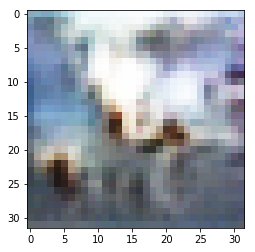

Epoch: [ 4 / 5 ],  Step: [ 520 / 781 ], D_loss:  0.9242308 , G_loss:  1.1978118
Epoch: [ 4 / 5 ],  Step: [ 521 / 781 ], D_loss:  0.81812936 , G_loss:  1.182881
Epoch: [ 4 / 5 ],  Step: [ 522 / 781 ], D_loss:  0.69254524 , G_loss:  1.0118501
Epoch: [ 4 / 5 ],  Step: [ 523 / 781 ], D_loss:  0.7313005 , G_loss:  1.3107961
Epoch: [ 4 / 5 ],  Step: [ 524 / 781 ], D_loss:  0.7969768 , G_loss:  1.6461984
Epoch: [ 4 / 5 ],  Step: [ 525 / 781 ], D_loss:  1.4604263 , G_loss:  1.3714478
Epoch: [ 4 / 5 ],  Step: [ 526 / 781 ], D_loss:  1.219235 , G_loss:  1.056359
Epoch: [ 4 / 5 ],  Step: [ 527 / 781 ], D_loss:  0.63622034 , G_loss:  1.0114025
Epoch: [ 4 / 5 ],  Step: [ 528 / 781 ], D_loss:  2.6359637 , G_loss:  2.5703156
Epoch: [ 4 / 5 ],  Step: [ 529 / 781 ], D_loss:  1.7656367 , G_loss:  2.3592815
(196, 32, 32, 3)


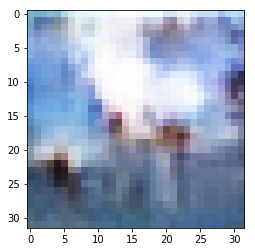

Epoch: [ 4 / 5 ],  Step: [ 530 / 781 ], D_loss:  1.8477634 , G_loss:  1.5514477
Epoch: [ 4 / 5 ],  Step: [ 531 / 781 ], D_loss:  1.5726644 , G_loss:  0.96426046
Epoch: [ 4 / 5 ],  Step: [ 532 / 781 ], D_loss:  1.525429 , G_loss:  0.85011095
Epoch: [ 4 / 5 ],  Step: [ 533 / 781 ], D_loss:  1.5669312 , G_loss:  1.2576342
Epoch: [ 4 / 5 ],  Step: [ 534 / 781 ], D_loss:  1.6318563 , G_loss:  1.2805717
Epoch: [ 4 / 5 ],  Step: [ 535 / 781 ], D_loss:  1.5756245 , G_loss:  1.0575268
Epoch: [ 4 / 5 ],  Step: [ 536 / 781 ], D_loss:  1.5350084 , G_loss:  0.8399493
Epoch: [ 4 / 5 ],  Step: [ 537 / 781 ], D_loss:  1.422787 , G_loss:  1.027694
Epoch: [ 4 / 5 ],  Step: [ 538 / 781 ], D_loss:  1.4430852 , G_loss:  0.9467663
Epoch: [ 4 / 5 ],  Step: [ 539 / 781 ], D_loss:  1.4475865 , G_loss:  0.8324863
(196, 32, 32, 3)


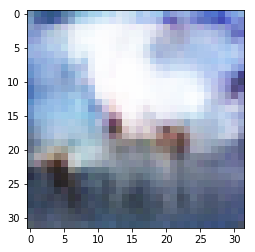

Epoch: [ 4 / 5 ],  Step: [ 540 / 781 ], D_loss:  1.3608863 , G_loss:  0.9224321
Epoch: [ 4 / 5 ],  Step: [ 541 / 781 ], D_loss:  1.4209492 , G_loss:  1.0294095
Epoch: [ 4 / 5 ],  Step: [ 542 / 781 ], D_loss:  1.3778725 , G_loss:  1.0113223
Epoch: [ 4 / 5 ],  Step: [ 543 / 781 ], D_loss:  1.3773723 , G_loss:  0.93645674
Epoch: [ 4 / 5 ],  Step: [ 544 / 781 ], D_loss:  1.3046994 , G_loss:  0.8465706
Epoch: [ 4 / 5 ],  Step: [ 545 / 781 ], D_loss:  1.4725604 , G_loss:  1.1068597
Epoch: [ 4 / 5 ],  Step: [ 546 / 781 ], D_loss:  1.3322209 , G_loss:  1.0774337
Epoch: [ 4 / 5 ],  Step: [ 547 / 781 ], D_loss:  1.3913624 , G_loss:  0.9237952
Epoch: [ 4 / 5 ],  Step: [ 548 / 781 ], D_loss:  1.4428217 , G_loss:  1.0867617
Epoch: [ 4 / 5 ],  Step: [ 549 / 781 ], D_loss:  1.3154368 , G_loss:  0.9720077
(196, 32, 32, 3)


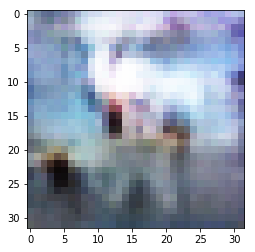

Epoch: [ 4 / 5 ],  Step: [ 550 / 781 ], D_loss:  1.4476902 , G_loss:  1.0179049
Epoch: [ 4 / 5 ],  Step: [ 551 / 781 ], D_loss:  1.4215038 , G_loss:  0.90494555
Epoch: [ 4 / 5 ],  Step: [ 552 / 781 ], D_loss:  1.2989485 , G_loss:  0.8965305
Epoch: [ 4 / 5 ],  Step: [ 553 / 781 ], D_loss:  1.201 , G_loss:  1.0003923
Epoch: [ 4 / 5 ],  Step: [ 554 / 781 ], D_loss:  1.1943831 , G_loss:  0.91251624
Epoch: [ 4 / 5 ],  Step: [ 555 / 781 ], D_loss:  1.2977298 , G_loss:  1.1086174
Epoch: [ 4 / 5 ],  Step: [ 556 / 781 ], D_loss:  1.349277 , G_loss:  1.0818464
Epoch: [ 4 / 5 ],  Step: [ 557 / 781 ], D_loss:  1.263597 , G_loss:  0.8836814
Epoch: [ 4 / 5 ],  Step: [ 558 / 781 ], D_loss:  1.2363249 , G_loss:  0.9813453
Epoch: [ 4 / 5 ],  Step: [ 559 / 781 ], D_loss:  1.3691508 , G_loss:  0.9236482
(196, 32, 32, 3)


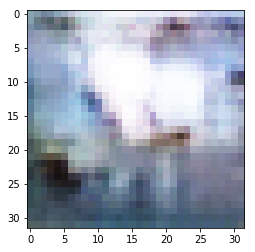

Epoch: [ 4 / 5 ],  Step: [ 560 / 781 ], D_loss:  1.2501341 , G_loss:  0.84361744
Epoch: [ 4 / 5 ],  Step: [ 561 / 781 ], D_loss:  1.3844144 , G_loss:  1.1577072
Epoch: [ 4 / 5 ],  Step: [ 562 / 781 ], D_loss:  1.4065553 , G_loss:  1.3207496
Epoch: [ 4 / 5 ],  Step: [ 563 / 781 ], D_loss:  1.3257139 , G_loss:  1.1076347
Epoch: [ 4 / 5 ],  Step: [ 564 / 781 ], D_loss:  1.2813685 , G_loss:  0.97230655
Epoch: [ 4 / 5 ],  Step: [ 565 / 781 ], D_loss:  1.2583395 , G_loss:  1.0197668
Epoch: [ 4 / 5 ],  Step: [ 566 / 781 ], D_loss:  1.1619012 , G_loss:  0.86078584
Epoch: [ 4 / 5 ],  Step: [ 567 / 781 ], D_loss:  1.1128929 , G_loss:  0.88577425
Epoch: [ 4 / 5 ],  Step: [ 568 / 781 ], D_loss:  1.1984327 , G_loss:  1.3974885
Epoch: [ 4 / 5 ],  Step: [ 569 / 781 ], D_loss:  1.2256646 , G_loss:  1.2136906
(196, 32, 32, 3)


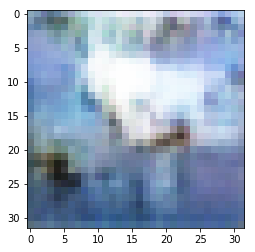

Epoch: [ 4 / 5 ],  Step: [ 570 / 781 ], D_loss:  1.1191 , G_loss:  0.9399532
Epoch: [ 4 / 5 ],  Step: [ 571 / 781 ], D_loss:  1.3579018 , G_loss:  1.3105611
Epoch: [ 4 / 5 ],  Step: [ 572 / 781 ], D_loss:  1.2019802 , G_loss:  1.2149577
Epoch: [ 4 / 5 ],  Step: [ 573 / 781 ], D_loss:  1.1840916 , G_loss:  1.0480913
Epoch: [ 4 / 5 ],  Step: [ 574 / 781 ], D_loss:  1.2916873 , G_loss:  1.1133872
Epoch: [ 4 / 5 ],  Step: [ 575 / 781 ], D_loss:  1.088933 , G_loss:  1.1437789
Epoch: [ 4 / 5 ],  Step: [ 576 / 781 ], D_loss:  1.0693566 , G_loss:  0.8111711
Epoch: [ 4 / 5 ],  Step: [ 577 / 781 ], D_loss:  0.99533296 , G_loss:  1.2457201
Epoch: [ 4 / 5 ],  Step: [ 578 / 781 ], D_loss:  0.9102399 , G_loss:  1.1207178
Epoch: [ 4 / 5 ],  Step: [ 579 / 781 ], D_loss:  1.0117365 , G_loss:  0.8848431
(196, 32, 32, 3)


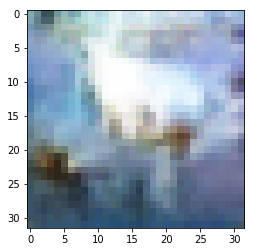

Epoch: [ 4 / 5 ],  Step: [ 580 / 781 ], D_loss:  0.87978154 , G_loss:  1.0900826
Epoch: [ 4 / 5 ],  Step: [ 581 / 781 ], D_loss:  0.8894401 , G_loss:  0.86942494
Epoch: [ 4 / 5 ],  Step: [ 582 / 781 ], D_loss:  0.85097927 , G_loss:  1.3534728
Epoch: [ 4 / 5 ],  Step: [ 583 / 781 ], D_loss:  0.8471422 , G_loss:  1.2411184
Epoch: [ 4 / 5 ],  Step: [ 584 / 781 ], D_loss:  1.1189252 , G_loss:  1.1346904
Epoch: [ 4 / 5 ],  Step: [ 585 / 781 ], D_loss:  0.6099176 , G_loss:  1.1474015
Epoch: [ 4 / 5 ],  Step: [ 586 / 781 ], D_loss:  0.8880713 , G_loss:  1.3181622
Epoch: [ 4 / 5 ],  Step: [ 587 / 781 ], D_loss:  1.1394591 , G_loss:  1.1925766
Epoch: [ 4 / 5 ],  Step: [ 588 / 781 ], D_loss:  0.82240176 , G_loss:  0.853332
Epoch: [ 4 / 5 ],  Step: [ 589 / 781 ], D_loss:  0.8804107 , G_loss:  1.2630605
(196, 32, 32, 3)


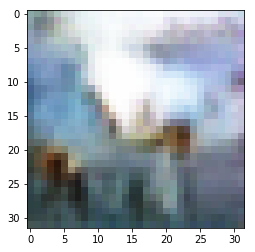

Epoch: [ 4 / 5 ],  Step: [ 590 / 781 ], D_loss:  0.7335322 , G_loss:  1.1940829
Epoch: [ 4 / 5 ],  Step: [ 591 / 781 ], D_loss:  0.782376 , G_loss:  1.0485823
Epoch: [ 4 / 5 ],  Step: [ 592 / 781 ], D_loss:  0.7287812 , G_loss:  1.083624
Epoch: [ 4 / 5 ],  Step: [ 593 / 781 ], D_loss:  0.66228503 , G_loss:  1.0867178
Epoch: [ 4 / 5 ],  Step: [ 594 / 781 ], D_loss:  0.6760522 , G_loss:  1.1495869
Epoch: [ 4 / 5 ],  Step: [ 595 / 781 ], D_loss:  0.6520211 , G_loss:  1.1552018
Epoch: [ 4 / 5 ],  Step: [ 596 / 781 ], D_loss:  0.59633803 , G_loss:  0.93372744
Epoch: [ 4 / 5 ],  Step: [ 597 / 781 ], D_loss:  0.71296203 , G_loss:  1.0733845
Epoch: [ 4 / 5 ],  Step: [ 598 / 781 ], D_loss:  0.9334595 , G_loss:  1.2834995
Epoch: [ 4 / 5 ],  Step: [ 599 / 781 ], D_loss:  1.075089 , G_loss:  1.1417043
(196, 32, 32, 3)


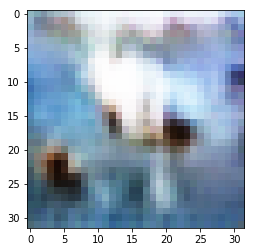

Epoch: [ 4 / 5 ],  Step: [ 600 / 781 ], D_loss:  1.0182635 , G_loss:  0.7769507
Epoch: [ 4 / 5 ],  Step: [ 601 / 781 ], D_loss:  0.89229536 , G_loss:  1.0825858
Epoch: [ 4 / 5 ],  Step: [ 602 / 781 ], D_loss:  0.72426957 , G_loss:  1.2669368
Epoch: [ 4 / 5 ],  Step: [ 603 / 781 ], D_loss:  0.776146 , G_loss:  1.1913025
Epoch: [ 4 / 5 ],  Step: [ 604 / 781 ], D_loss:  0.66286933 , G_loss:  1.1405394
Epoch: [ 4 / 5 ],  Step: [ 605 / 781 ], D_loss:  0.72434384 , G_loss:  1.2221696
Epoch: [ 4 / 5 ],  Step: [ 606 / 781 ], D_loss:  0.51474553 , G_loss:  1.3714076
Epoch: [ 4 / 5 ],  Step: [ 607 / 781 ], D_loss:  0.6894283 , G_loss:  0.9668616
Epoch: [ 4 / 5 ],  Step: [ 608 / 781 ], D_loss:  0.38199264 , G_loss:  1.5123165
Epoch: [ 4 / 5 ],  Step: [ 609 / 781 ], D_loss:  0.56321555 , G_loss:  1.2587324
(196, 32, 32, 3)


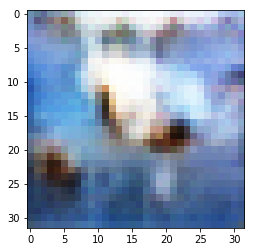

Epoch: [ 4 / 5 ],  Step: [ 610 / 781 ], D_loss:  0.38657504 , G_loss:  1.4839264
Epoch: [ 4 / 5 ],  Step: [ 611 / 781 ], D_loss:  0.55007064 , G_loss:  1.1542635
Epoch: [ 4 / 5 ],  Step: [ 612 / 781 ], D_loss:  0.41496688 , G_loss:  1.5491711
Epoch: [ 4 / 5 ],  Step: [ 613 / 781 ], D_loss:  0.44385448 , G_loss:  1.2238894
Epoch: [ 4 / 5 ],  Step: [ 614 / 781 ], D_loss:  0.56264627 , G_loss:  1.2098284
Epoch: [ 4 / 5 ],  Step: [ 615 / 781 ], D_loss:  0.75995165 , G_loss:  1.4929488
Epoch: [ 4 / 5 ],  Step: [ 616 / 781 ], D_loss:  0.89512277 , G_loss:  1.6175194
Epoch: [ 4 / 5 ],  Step: [ 617 / 781 ], D_loss:  0.9372572 , G_loss:  0.9992942
Epoch: [ 4 / 5 ],  Step: [ 618 / 781 ], D_loss:  1.059145 , G_loss:  1.0847863
Epoch: [ 4 / 5 ],  Step: [ 619 / 781 ], D_loss:  0.7645868 , G_loss:  1.0334101
(196, 32, 32, 3)


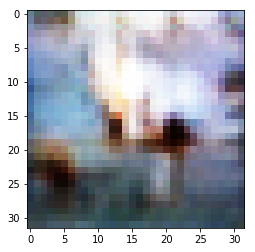

Epoch: [ 4 / 5 ],  Step: [ 620 / 781 ], D_loss:  0.6392096 , G_loss:  1.4151653
Epoch: [ 4 / 5 ],  Step: [ 621 / 781 ], D_loss:  0.8348007 , G_loss:  0.9598924
Epoch: [ 4 / 5 ],  Step: [ 622 / 781 ], D_loss:  0.9165765 , G_loss:  1.6039345
Epoch: [ 4 / 5 ],  Step: [ 623 / 781 ], D_loss:  0.9493347 , G_loss:  1.4161029
Epoch: [ 4 / 5 ],  Step: [ 624 / 781 ], D_loss:  0.8452363 , G_loss:  1.0194947
Epoch: [ 4 / 5 ],  Step: [ 625 / 781 ], D_loss:  0.8196658 , G_loss:  1.0322766
Epoch: [ 4 / 5 ],  Step: [ 626 / 781 ], D_loss:  0.7404962 , G_loss:  1.1657927
Epoch: [ 4 / 5 ],  Step: [ 627 / 781 ], D_loss:  0.5742122 , G_loss:  1.4886061
Epoch: [ 4 / 5 ],  Step: [ 628 / 781 ], D_loss:  0.9218877 , G_loss:  0.9673986
Epoch: [ 4 / 5 ],  Step: [ 629 / 781 ], D_loss:  0.85437405 , G_loss:  1.6169205
(196, 32, 32, 3)


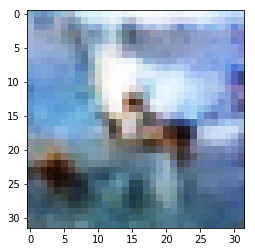

Epoch: [ 4 / 5 ],  Step: [ 630 / 781 ], D_loss:  1.0593324 , G_loss:  1.5917711
Epoch: [ 4 / 5 ],  Step: [ 631 / 781 ], D_loss:  0.8250861 , G_loss:  1.1110564
Epoch: [ 4 / 5 ],  Step: [ 632 / 781 ], D_loss:  1.2427244 , G_loss:  1.5203847
Epoch: [ 4 / 5 ],  Step: [ 633 / 781 ], D_loss:  1.0986068 , G_loss:  1.327917
Epoch: [ 4 / 5 ],  Step: [ 634 / 781 ], D_loss:  1.2705655 , G_loss:  1.0188131
Epoch: [ 4 / 5 ],  Step: [ 635 / 781 ], D_loss:  1.3015133 , G_loss:  1.4296215
Epoch: [ 4 / 5 ],  Step: [ 636 / 781 ], D_loss:  0.9535661 , G_loss:  1.3662633
Epoch: [ 4 / 5 ],  Step: [ 637 / 781 ], D_loss:  1.0521413 , G_loss:  1.2195932
Epoch: [ 4 / 5 ],  Step: [ 638 / 781 ], D_loss:  1.1292341 , G_loss:  0.91035265
Epoch: [ 4 / 5 ],  Step: [ 639 / 781 ], D_loss:  1.3572768 , G_loss:  1.8726338
(196, 32, 32, 3)


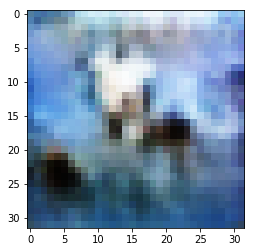

Epoch: [ 4 / 5 ],  Step: [ 640 / 781 ], D_loss:  1.4191378 , G_loss:  1.8533427
Epoch: [ 4 / 5 ],  Step: [ 641 / 781 ], D_loss:  1.2291561 , G_loss:  1.1951555
Epoch: [ 4 / 5 ],  Step: [ 642 / 781 ], D_loss:  1.4655073 , G_loss:  1.4168682
Epoch: [ 4 / 5 ],  Step: [ 643 / 781 ], D_loss:  1.1250243 , G_loss:  1.2139293
Epoch: [ 4 / 5 ],  Step: [ 644 / 781 ], D_loss:  0.9506968 , G_loss:  1.0779039
Epoch: [ 4 / 5 ],  Step: [ 645 / 781 ], D_loss:  1.1347173 , G_loss:  1.3666766
Epoch: [ 4 / 5 ],  Step: [ 646 / 781 ], D_loss:  1.0271412 , G_loss:  1.154357
Epoch: [ 4 / 5 ],  Step: [ 647 / 781 ], D_loss:  0.9350879 , G_loss:  0.974414
Epoch: [ 4 / 5 ],  Step: [ 648 / 781 ], D_loss:  1.1730394 , G_loss:  1.4137663
Epoch: [ 4 / 5 ],  Step: [ 649 / 781 ], D_loss:  0.99560755 , G_loss:  1.1864656
(196, 32, 32, 3)


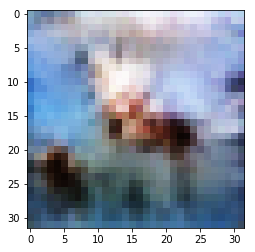

Epoch: [ 4 / 5 ],  Step: [ 650 / 781 ], D_loss:  1.0036207 , G_loss:  0.9005219
Epoch: [ 4 / 5 ],  Step: [ 651 / 781 ], D_loss:  0.97936976 , G_loss:  1.3381819
Epoch: [ 4 / 5 ],  Step: [ 652 / 781 ], D_loss:  0.95138085 , G_loss:  1.2625865
Epoch: [ 4 / 5 ],  Step: [ 653 / 781 ], D_loss:  0.9197783 , G_loss:  1.0716643
Epoch: [ 4 / 5 ],  Step: [ 654 / 781 ], D_loss:  0.8591201 , G_loss:  1.2612506
Epoch: [ 4 / 5 ],  Step: [ 655 / 781 ], D_loss:  0.67813313 , G_loss:  1.1465826
Epoch: [ 4 / 5 ],  Step: [ 656 / 781 ], D_loss:  0.6172895 , G_loss:  1.0200272
Epoch: [ 4 / 5 ],  Step: [ 657 / 781 ], D_loss:  0.7180432 , G_loss:  1.2442538
Epoch: [ 4 / 5 ],  Step: [ 658 / 781 ], D_loss:  0.62037677 , G_loss:  1.1401632
Epoch: [ 4 / 5 ],  Step: [ 659 / 781 ], D_loss:  0.8095752 , G_loss:  1.2573069
(196, 32, 32, 3)


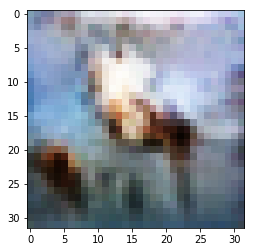

Epoch: [ 4 / 5 ],  Step: [ 660 / 781 ], D_loss:  0.951074 , G_loss:  1.1208961
Epoch: [ 4 / 5 ],  Step: [ 661 / 781 ], D_loss:  0.78766286 , G_loss:  0.9716046
Epoch: [ 4 / 5 ],  Step: [ 662 / 781 ], D_loss:  0.56388044 , G_loss:  1.1915791
Epoch: [ 4 / 5 ],  Step: [ 663 / 781 ], D_loss:  1.161223 , G_loss:  1.7961259
Epoch: [ 4 / 5 ],  Step: [ 664 / 781 ], D_loss:  1.3983299 , G_loss:  1.7221502
Epoch: [ 4 / 5 ],  Step: [ 665 / 781 ], D_loss:  1.1106737 , G_loss:  1.2839004
Epoch: [ 4 / 5 ],  Step: [ 666 / 781 ], D_loss:  1.115031 , G_loss:  1.2505804
Epoch: [ 4 / 5 ],  Step: [ 667 / 781 ], D_loss:  1.0540565 , G_loss:  1.0736542
Epoch: [ 4 / 5 ],  Step: [ 668 / 781 ], D_loss:  0.988627 , G_loss:  0.76607555
Epoch: [ 4 / 5 ],  Step: [ 669 / 781 ], D_loss:  0.88035226 , G_loss:  1.3085485
(196, 32, 32, 3)


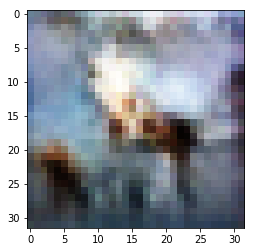

Epoch: [ 4 / 5 ],  Step: [ 670 / 781 ], D_loss:  0.8811743 , G_loss:  1.4022473
Epoch: [ 4 / 5 ],  Step: [ 671 / 781 ], D_loss:  0.9426478 , G_loss:  1.0911436
Epoch: [ 4 / 5 ],  Step: [ 672 / 781 ], D_loss:  0.7477583 , G_loss:  1.1839838
Epoch: [ 4 / 5 ],  Step: [ 673 / 781 ], D_loss:  0.89552164 , G_loss:  1.6413262
Epoch: [ 4 / 5 ],  Step: [ 674 / 781 ], D_loss:  1.0588627 , G_loss:  1.4585162
Epoch: [ 4 / 5 ],  Step: [ 675 / 781 ], D_loss:  0.5575148 , G_loss:  1.1402421
Epoch: [ 4 / 5 ],  Step: [ 676 / 781 ], D_loss:  1.0231783 , G_loss:  1.605965
Epoch: [ 4 / 5 ],  Step: [ 677 / 781 ], D_loss:  1.1354709 , G_loss:  1.6766436
Epoch: [ 4 / 5 ],  Step: [ 678 / 781 ], D_loss:  1.0577064 , G_loss:  1.130634
Epoch: [ 4 / 5 ],  Step: [ 679 / 781 ], D_loss:  1.0734481 , G_loss:  1.2854831
(196, 32, 32, 3)


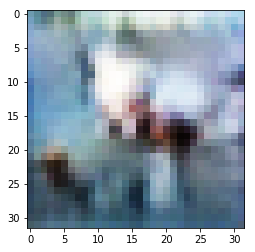

Epoch: [ 4 / 5 ],  Step: [ 680 / 781 ], D_loss:  0.9354513 , G_loss:  1.2151262
Epoch: [ 4 / 5 ],  Step: [ 681 / 781 ], D_loss:  0.75311124 , G_loss:  1.2413051
Epoch: [ 4 / 5 ],  Step: [ 682 / 781 ], D_loss:  0.99041426 , G_loss:  1.97914
Epoch: [ 4 / 5 ],  Step: [ 683 / 781 ], D_loss:  1.3245372 , G_loss:  2.046809
Epoch: [ 4 / 5 ],  Step: [ 684 / 781 ], D_loss:  1.4649704 , G_loss:  1.407588
Epoch: [ 4 / 5 ],  Step: [ 685 / 781 ], D_loss:  1.4254545 , G_loss:  0.8759115
Epoch: [ 4 / 5 ],  Step: [ 686 / 781 ], D_loss:  1.2509549 , G_loss:  1.2927853
Epoch: [ 4 / 5 ],  Step: [ 687 / 781 ], D_loss:  1.2588427 , G_loss:  1.1768622
Epoch: [ 4 / 5 ],  Step: [ 688 / 781 ], D_loss:  1.4680912 , G_loss:  1.0510538
Epoch: [ 4 / 5 ],  Step: [ 689 / 781 ], D_loss:  1.1126244 , G_loss:  1.0652586
(196, 32, 32, 3)


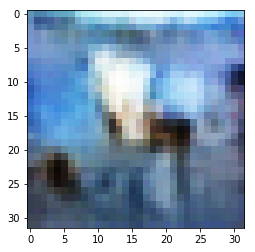

Epoch: [ 4 / 5 ],  Step: [ 690 / 781 ], D_loss:  1.141686 , G_loss:  1.0238549
Epoch: [ 4 / 5 ],  Step: [ 691 / 781 ], D_loss:  0.86707515 , G_loss:  0.9275387
Epoch: [ 4 / 5 ],  Step: [ 692 / 781 ], D_loss:  1.0421828 , G_loss:  1.2389308
Epoch: [ 4 / 5 ],  Step: [ 693 / 781 ], D_loss:  0.910753 , G_loss:  1.1718433
Epoch: [ 4 / 5 ],  Step: [ 694 / 781 ], D_loss:  1.0793914 , G_loss:  1.2944975
Epoch: [ 4 / 5 ],  Step: [ 695 / 781 ], D_loss:  1.2136701 , G_loss:  0.994992
Epoch: [ 4 / 5 ],  Step: [ 696 / 781 ], D_loss:  0.9281218 , G_loss:  1.0950403
Epoch: [ 4 / 5 ],  Step: [ 697 / 781 ], D_loss:  0.9046332 , G_loss:  0.92462397
Epoch: [ 4 / 5 ],  Step: [ 698 / 781 ], D_loss:  1.1676137 , G_loss:  1.161283
Epoch: [ 4 / 5 ],  Step: [ 699 / 781 ], D_loss:  1.1039379 , G_loss:  0.93336546
(196, 32, 32, 3)


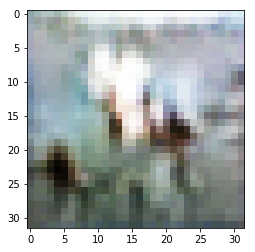

Epoch: [ 4 / 5 ],  Step: [ 700 / 781 ], D_loss:  1.1473565 , G_loss:  1.367706
Epoch: [ 4 / 5 ],  Step: [ 701 / 781 ], D_loss:  0.97303784 , G_loss:  1.3309526
Epoch: [ 4 / 5 ],  Step: [ 702 / 781 ], D_loss:  0.7729713 , G_loss:  1.14778
Epoch: [ 4 / 5 ],  Step: [ 703 / 781 ], D_loss:  0.7194204 , G_loss:  1.3151009
Epoch: [ 4 / 5 ],  Step: [ 704 / 781 ], D_loss:  0.8561366 , G_loss:  1.1180928
Epoch: [ 4 / 5 ],  Step: [ 705 / 781 ], D_loss:  0.6878788 , G_loss:  1.1299504
Epoch: [ 4 / 5 ],  Step: [ 706 / 781 ], D_loss:  0.891921 , G_loss:  0.9708962
Epoch: [ 4 / 5 ],  Step: [ 707 / 781 ], D_loss:  0.6526873 , G_loss:  1.1311456
Epoch: [ 4 / 5 ],  Step: [ 708 / 781 ], D_loss:  0.8534969 , G_loss:  1.7998585
Epoch: [ 4 / 5 ],  Step: [ 709 / 781 ], D_loss:  0.9121478 , G_loss:  1.4125923
(196, 32, 32, 3)


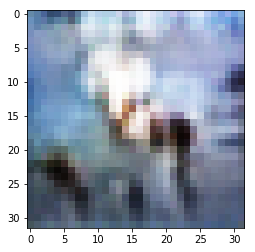

Epoch: [ 4 / 5 ],  Step: [ 710 / 781 ], D_loss:  0.79649013 , G_loss:  1.0923989
Epoch: [ 4 / 5 ],  Step: [ 711 / 781 ], D_loss:  1.0941331 , G_loss:  1.8175988
Epoch: [ 4 / 5 ],  Step: [ 712 / 781 ], D_loss:  1.1504116 , G_loss:  1.6254541
Epoch: [ 4 / 5 ],  Step: [ 713 / 781 ], D_loss:  0.85930413 , G_loss:  0.95960283
Epoch: [ 4 / 5 ],  Step: [ 714 / 781 ], D_loss:  0.8728441 , G_loss:  0.85236275
Epoch: [ 4 / 5 ],  Step: [ 715 / 781 ], D_loss:  1.230119 , G_loss:  1.9617348
Epoch: [ 4 / 5 ],  Step: [ 716 / 781 ], D_loss:  1.0541942 , G_loss:  1.5257459
Epoch: [ 4 / 5 ],  Step: [ 717 / 781 ], D_loss:  0.876788 , G_loss:  1.2749841
Epoch: [ 4 / 5 ],  Step: [ 718 / 781 ], D_loss:  1.0751911 , G_loss:  1.2529378
Epoch: [ 4 / 5 ],  Step: [ 719 / 781 ], D_loss:  0.7841865 , G_loss:  1.1295218
(196, 32, 32, 3)


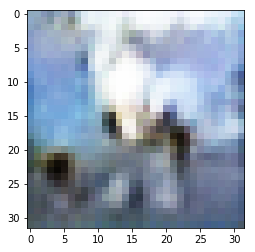

Epoch: [ 4 / 5 ],  Step: [ 720 / 781 ], D_loss:  1.0690721 , G_loss:  0.8625093
Epoch: [ 4 / 5 ],  Step: [ 721 / 781 ], D_loss:  0.591664 , G_loss:  1.1509424
Epoch: [ 4 / 5 ],  Step: [ 722 / 781 ], D_loss:  1.0246946 , G_loss:  1.9207693
Epoch: [ 4 / 5 ],  Step: [ 723 / 781 ], D_loss:  1.4160357 , G_loss:  1.7083356
Epoch: [ 4 / 5 ],  Step: [ 724 / 781 ], D_loss:  1.2769122 , G_loss:  1.0492393
Epoch: [ 4 / 5 ],  Step: [ 725 / 781 ], D_loss:  0.97729224 , G_loss:  0.54691577
Epoch: [ 4 / 5 ],  Step: [ 726 / 781 ], D_loss:  1.4013201 , G_loss:  1.9867213
Epoch: [ 4 / 5 ],  Step: [ 727 / 781 ], D_loss:  1.2279997 , G_loss:  1.6638596
Epoch: [ 4 / 5 ],  Step: [ 728 / 781 ], D_loss:  1.2201043 , G_loss:  1.0844194
Epoch: [ 4 / 5 ],  Step: [ 729 / 781 ], D_loss:  0.9305378 , G_loss:  0.84945714
(196, 32, 32, 3)


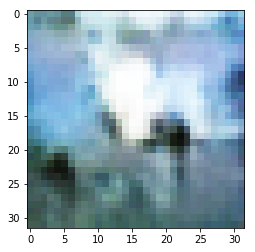

Epoch: [ 4 / 5 ],  Step: [ 730 / 781 ], D_loss:  1.36237 , G_loss:  2.1954057
Epoch: [ 4 / 5 ],  Step: [ 731 / 781 ], D_loss:  1.659051 , G_loss:  2.2369413
Epoch: [ 4 / 5 ],  Step: [ 732 / 781 ], D_loss:  1.5701334 , G_loss:  1.6374311
Epoch: [ 4 / 5 ],  Step: [ 733 / 781 ], D_loss:  1.4985076 , G_loss:  1.2599742
Epoch: [ 4 / 5 ],  Step: [ 734 / 781 ], D_loss:  1.2597787 , G_loss:  0.91198605
Epoch: [ 4 / 5 ],  Step: [ 735 / 781 ], D_loss:  1.108701 , G_loss:  1.0090985
Epoch: [ 4 / 5 ],  Step: [ 736 / 781 ], D_loss:  1.0223923 , G_loss:  1.0838584
Epoch: [ 4 / 5 ],  Step: [ 737 / 781 ], D_loss:  1.1161542 , G_loss:  0.971637
Epoch: [ 4 / 5 ],  Step: [ 738 / 781 ], D_loss:  0.9333706 , G_loss:  1.1253558
Epoch: [ 4 / 5 ],  Step: [ 739 / 781 ], D_loss:  0.8108029 , G_loss:  0.9344715
(196, 32, 32, 3)


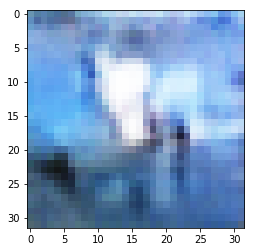

Epoch: [ 4 / 5 ],  Step: [ 740 / 781 ], D_loss:  0.7859532 , G_loss:  1.0369792
Epoch: [ 4 / 5 ],  Step: [ 741 / 781 ], D_loss:  0.81927234 , G_loss:  0.92697656
Epoch: [ 4 / 5 ],  Step: [ 742 / 781 ], D_loss:  0.81912863 , G_loss:  1.0323825
Epoch: [ 4 / 5 ],  Step: [ 743 / 781 ], D_loss:  0.77851975 , G_loss:  1.02302
Epoch: [ 4 / 5 ],  Step: [ 744 / 781 ], D_loss:  0.7146558 , G_loss:  1.0660684
Epoch: [ 4 / 5 ],  Step: [ 745 / 781 ], D_loss:  0.60970455 , G_loss:  1.0812024
Epoch: [ 4 / 5 ],  Step: [ 746 / 781 ], D_loss:  0.6920692 , G_loss:  1.0322504
Epoch: [ 4 / 5 ],  Step: [ 747 / 781 ], D_loss:  0.6049772 , G_loss:  1.2376218
Epoch: [ 4 / 5 ],  Step: [ 748 / 781 ], D_loss:  0.53846467 , G_loss:  1.1672924
Epoch: [ 4 / 5 ],  Step: [ 749 / 781 ], D_loss:  1.4018227 , G_loss:  1.928929
(196, 32, 32, 3)


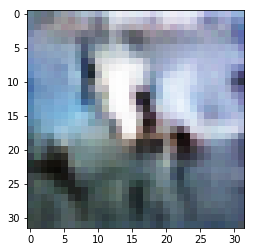

Epoch: [ 4 / 5 ],  Step: [ 750 / 781 ], D_loss:  1.4000833 , G_loss:  2.0701022
Epoch: [ 4 / 5 ],  Step: [ 751 / 781 ], D_loss:  1.4396183 , G_loss:  1.6021384
Epoch: [ 4 / 5 ],  Step: [ 752 / 781 ], D_loss:  1.2142746 , G_loss:  0.985016
Epoch: [ 4 / 5 ],  Step: [ 753 / 781 ], D_loss:  0.7614604 , G_loss:  1.1598378
Epoch: [ 4 / 5 ],  Step: [ 754 / 781 ], D_loss:  1.2047758 , G_loss:  1.7351692
Epoch: [ 4 / 5 ],  Step: [ 755 / 781 ], D_loss:  1.3940306 , G_loss:  1.7974787
Epoch: [ 4 / 5 ],  Step: [ 756 / 781 ], D_loss:  1.3282547 , G_loss:  1.1918316
Epoch: [ 4 / 5 ],  Step: [ 757 / 781 ], D_loss:  1.3043718 , G_loss:  0.8898065
Epoch: [ 4 / 5 ],  Step: [ 758 / 781 ], D_loss:  1.4381353 , G_loss:  1.5369296
Epoch: [ 4 / 5 ],  Step: [ 759 / 781 ], D_loss:  1.3181243 , G_loss:  1.5579383
(196, 32, 32, 3)


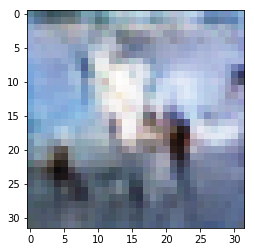

Epoch: [ 4 / 5 ],  Step: [ 760 / 781 ], D_loss:  1.0786246 , G_loss:  1.2987524
Epoch: [ 4 / 5 ],  Step: [ 761 / 781 ], D_loss:  1.0138552 , G_loss:  1.1237442
Epoch: [ 4 / 5 ],  Step: [ 762 / 781 ], D_loss:  0.9658066 , G_loss:  1.0589691
Epoch: [ 4 / 5 ],  Step: [ 763 / 781 ], D_loss:  0.7085088 , G_loss:  1.0790906
Epoch: [ 4 / 5 ],  Step: [ 764 / 781 ], D_loss:  0.56228054 , G_loss:  1.2377268
Epoch: [ 4 / 5 ],  Step: [ 765 / 781 ], D_loss:  1.0867155 , G_loss:  1.6420058
Epoch: [ 4 / 5 ],  Step: [ 766 / 781 ], D_loss:  0.85477823 , G_loss:  1.609549
Epoch: [ 4 / 5 ],  Step: [ 767 / 781 ], D_loss:  0.83631754 , G_loss:  1.0056148
Epoch: [ 4 / 5 ],  Step: [ 768 / 781 ], D_loss:  0.803385 , G_loss:  1.2357262
Epoch: [ 4 / 5 ],  Step: [ 769 / 781 ], D_loss:  0.999121 , G_loss:  1.6971211
(196, 32, 32, 3)


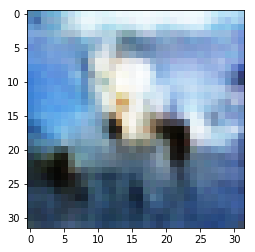

Epoch: [ 4 / 5 ],  Step: [ 770 / 781 ], D_loss:  1.1840316 , G_loss:  1.8776274
Epoch: [ 4 / 5 ],  Step: [ 771 / 781 ], D_loss:  1.0897231 , G_loss:  1.6053357
Epoch: [ 4 / 5 ],  Step: [ 772 / 781 ], D_loss:  0.9631213 , G_loss:  0.70885384
Epoch: [ 4 / 5 ],  Step: [ 773 / 781 ], D_loss:  0.57981765 , G_loss:  1.1680915
Epoch: [ 4 / 5 ],  Step: [ 774 / 781 ], D_loss:  0.802183 , G_loss:  1.5808415
Epoch: [ 4 / 5 ],  Step: [ 775 / 781 ], D_loss:  0.9090712 , G_loss:  1.4753684
Epoch: [ 4 / 5 ],  Step: [ 776 / 781 ], D_loss:  1.0652639 , G_loss:  1.1189475
Epoch: [ 4 / 5 ],  Step: [ 777 / 781 ], D_loss:  0.5826632 , G_loss:  1.2938027
Epoch: [ 4 / 5 ],  Step: [ 778 / 781 ], D_loss:  0.85524935 , G_loss:  0.86168706
Epoch: [ 4 / 5 ],  Step: [ 779 / 781 ], D_loss:  0.5422777 , G_loss:  1.1719475
(196, 32, 32, 3)


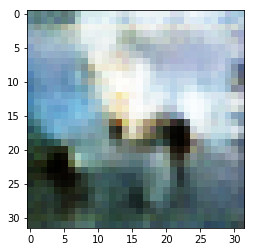

Epoch: [ 4 / 5 ],  Step: [ 780 / 781 ], D_loss:  0.5278314 , G_loss:  1.2540859


In [0]:
def main():
    total_epoch = 5
    batch_size = 64
    n_noise = 100

    sess = tf.Session()
    model = DCGAN(sess, batch_size)
    sess.run(tf.global_variables_initializer())

    total_batch = int(x_train.shape[0] / batch_size)
    print('total_batch: ', total_batch)

    visualization_num = 14 * 14
    noise_test = np.random.normal(size=(visualization_num, n_noise))

    loss_D = 0.0
    loss_G = 0.0
    for epoch in range(total_epoch):
        for step in range(total_batch):
            batch_xs = x_train[step * batch_size:(step+1) * batch_size]      # Get the next batch
            batch_xs = batch_xs * (2.0 / 255.0) - 1     # normalization
            noise_g = np.random.normal(size=(batch_size, n_noise))
            noise_d = np.random.normal(size=(batch_size, n_noise))

            # Train Generator twice while training Discriminator once for first 200 steps
            if epoch == 0 and step < 200:
                adventage = 2
            else:
                adventage = 1

            if step % adventage == 0:
                # Train Discriminator and get the loss value
                loss_D = model.train_discrim(batch_xs, noise_d)     
            # Train Generator and get the loss value
            loss_G = model.train_gen(noise_g)

            print('Epoch: [', epoch, '/', total_epoch, '], ', 'Step: [', step, '/', total_batch, '], D_loss: ',
                  loss_D, ', G_loss: ', loss_G)

            if step == 0 or (step + 1) % 10 == 0:
                generated_samples = model.sample_generator(noise_test, batch_size=visualization_num)
                print(generated_samples.shape)
                plt.imshow(generated_samples[0])
                plt.show()
#                 print(generated_samples)
#                 savepath = output_dir + '/output_' + 'EP' + str(epoch).zfill(3) + "_Batch" + str(step).zfill(6) + '.jpg'
#                 save_visualization(generated_samples, (14, 14), save_path=savepath)


main()
